# PERCOBAAN 1

In [2]:
!pip install -q onnxruntime
!pip install -q rembg pillow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.8 MB/s eta 0:00:00


## BAGIAN 1: SETUP & LIBRARY

In [3]:
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rembg import remove
from tqdm import tqdm  # Untuk progress bar
from google.colab import drive

# Library Ekstraksi Fitur
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

# Ganti path ini sesuai lokasi dataset Anda
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/PBL KEL 5 SEM 5/fruit-clean'

# Folder untuk menyimpan Fitur (.npy) dan Model (.pkl)
ARTIFACTS_PATH = os.path.join(DATASET_PATH, 'Output_Artifacts')

# Buat folder artifacts jika belum ada
if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)
    print(f"📂 Folder penyimpanan dibuat: {ARTIFACTS_PATH}")
else:
    print(f"📂 Menggunakan folder penyimpanan: {ARTIFACTS_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Menggunakan folder penyimpanan: /content/drive/MyDrive/Colab Notebooks/PBL KEL 5 SEM 5/fruit-clean/Output_Artifacts


## BAGIAN 2: FUNGSI PRAPROSES CITRA

In [4]:
def remove_background(image):
    """
    Menghapus background dari gambar menggunakan segmentasi

    Args:
        input_path: Path ke gambar input
        output_path: Path untuk menyimpan hasil
    """

    # Hapus background
    output_image = remove(image)

    return output_image

def preprocess_image(image_path, target_size=(100, 100)):
    """
    Membaca gambar, resize, remove background, dan konversi ke format yang dibutuhkan.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Cannot read image {image_path}")
        return None, None, None, None

    # Konversi ke RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Remove background (menghasilkan RGBA dengan alpha channel)
    img_segmented_full = remove_background(img_rgb)  # Ini RGBA!

    # 2. Resize SETELAH segmentasi
    img_resized = cv2.resize(img_segmented_full, target_size)

    # 3. PERBAIKAN: Konversi RGBA ke Grayscale dengan mempertimbangkan alpha
    # Opsi A: Ambil hanya RGB channel, lalu ke grayscale
    img_rgb_only = img_resized[:, :, :3]  # Ambil R, G, B saja
    img_gray = cv2.cvtColor(img_rgb_only, cv2.COLOR_RGB2GRAY)

    # Opsi B: Atau bisa gabungkan dengan alpha untuk background putih/hitam
    # alpha = img_resized[:, :, 3] / 255.0
    # img_gray = cv2.cvtColor(img_rgb_only, cv2.COLOR_RGB2GRAY)
    # img_gray = (img_gray * alpha).astype('uint8')  # Background jadi hitam

    # 4. Normalisasi GRAYSCALE (bukan RGB!)
    img_normalized = img_gray.astype('float32') / 255.0

    return img_rgb, img_resized, img_gray, img_normalized

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 170GB/s]


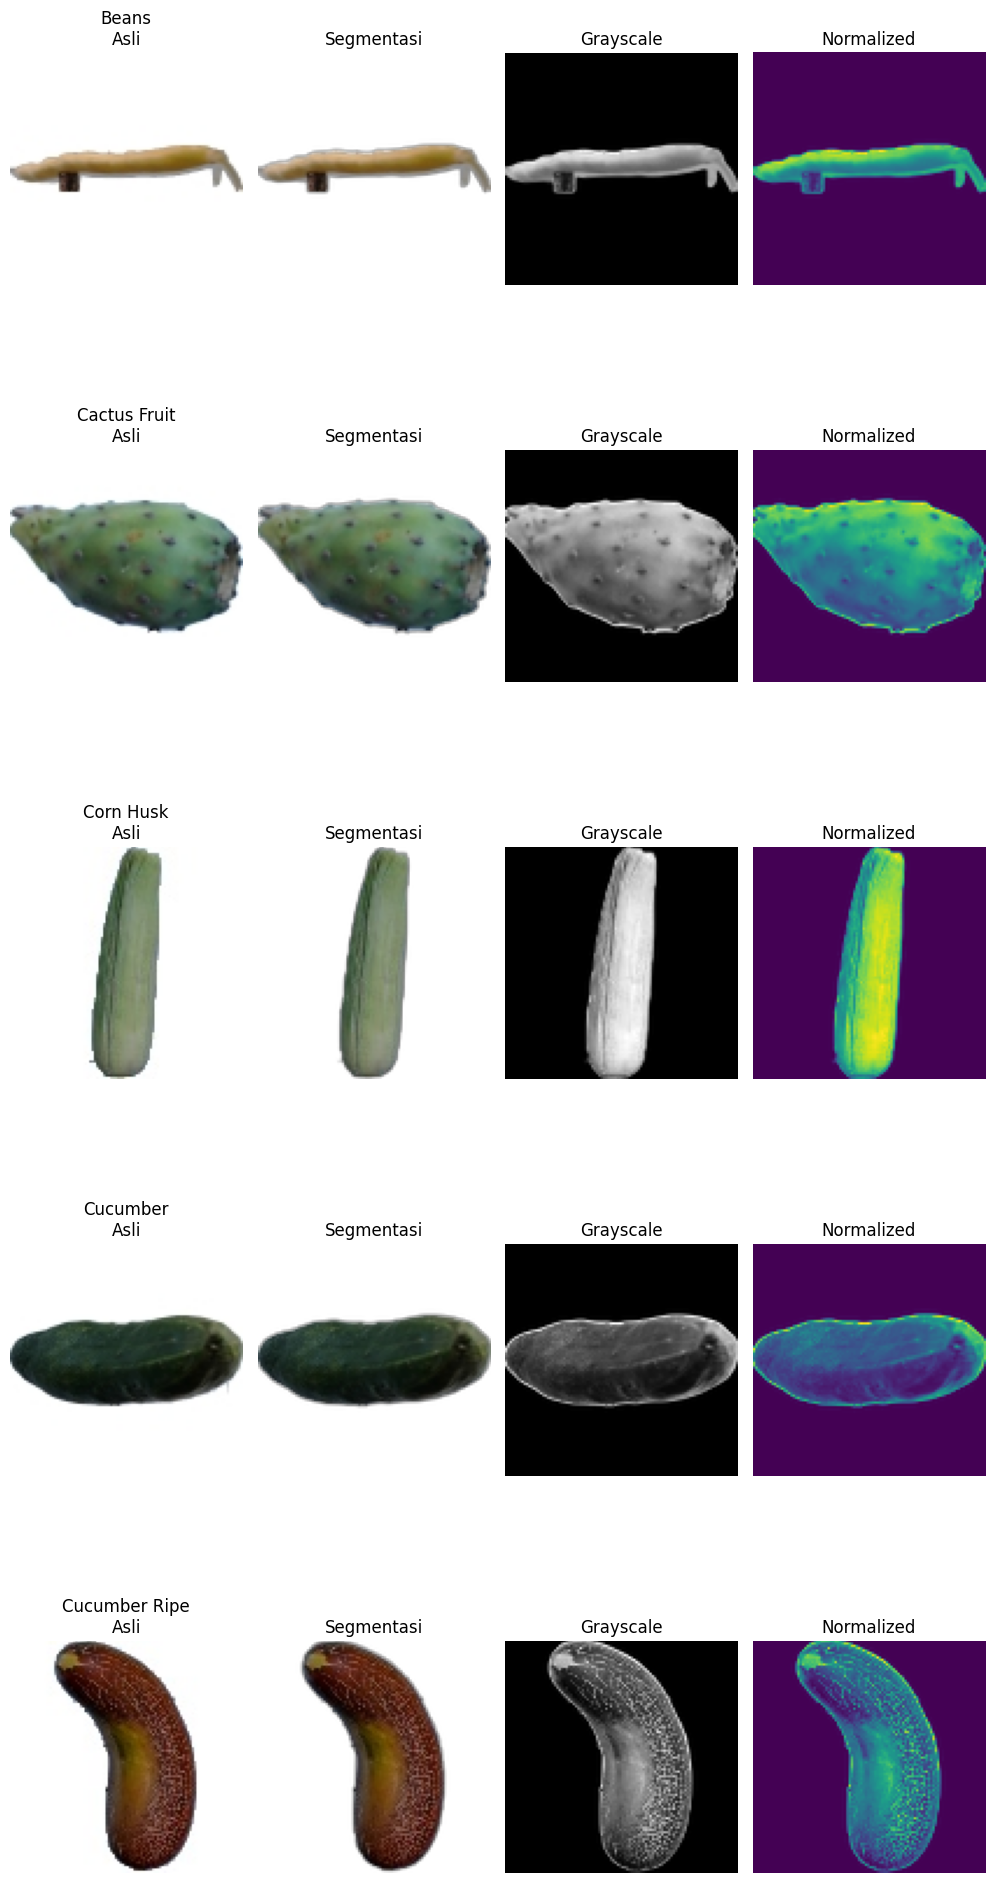

In [5]:
def visualize_preprocessing(dataset_path):
    # Cari folder training
    train_path = os.path.join(dataset_path, 'Training') # Sesuaikan nama folder: 'training' atau 'train'

    if not os.path.exists(train_path):
        print(f"Path {train_path} tidak ditemukan. Cek kembali path Google Drive Anda.")
        return

    # Ambil daftar kelas (nama buah)
    classes = os.listdir(train_path)
    # Ambil 3 kelas pertama saja untuk demo visualisasi
    demo_classes = classes[:5]

    plt.figure(figsize=(15, 20))
    cols = 6

    for i, class_name in enumerate(demo_classes):
        class_folder = os.path.join(train_path, class_name)
        images = os.listdir(class_folder)

        num = 1

        if len(images) > 0:
            sample_img_path = os.path.join(class_folder, images[0])

            # Jalankan Praproses
            img_resized, img_segmented, img_gray, img_normalized = preprocess_image(sample_img_path)

            # Jalankan Augmentasi pada hasil segmentasi
            # aug_results = augment_image(img_segmented)

            # --- PLOTTING ---
            # 1. Gambar Asli
            plt.subplot(len(demo_classes), cols, i*cols + num)
            plt.imshow(img_resized)
            plt.title(f"{class_name}\nAsli")
            plt.axis('off')

            num = num + 1
            # 2. Hasil Segmentasi (Background Removal)
            plt.subplot(len(demo_classes), cols, i*cols + num)
            plt.imshow(img_segmented)
            plt.title("Segmentasi")
            plt.axis('off')

            num = num + 1
            # 3. Grayscale
            plt.subplot(len(demo_classes), cols, i*cols + num)
            plt.imshow(img_gray, cmap='gray')
            plt.title("Grayscale")
            plt.axis('off')

            num = num + 1
            # 4. Normalized
            plt.subplot(len(demo_classes), cols, i*cols + num)
            plt.imshow(img_normalized)
            plt.title("Normalized")
            plt.axis('off')

            # num = num + 1
            # # 5. Augmentasi 1 (Flip)
            # plt.subplot(len(demo_classes), cols, i*cols + num)
            # plt.imshow(aug_results[0][1])
            # plt.title("Aug: Flip Horizontal")
            # plt.axis('off')

            # num = num + 1
            # # 6. Augmentasi 2 (Rotate)
            # plt.subplot(len(demo_classes), cols, i*cols + num)
            # plt.imshow(aug_results[1][1])
            # plt.title("Aug: Rotate 90")
            # plt.axis('off')

    plt.tight_layout()
    plt.show()

# Jalankan Visualisasi
visualize_preprocessing(DATASET_PATH)

## BAGIAN 3: FUNGSI EKSTRAKSI FITUR

In [6]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops, hog

def extract_color_features(image):
    """
    Fitur Warna menggunakan Histogram HSV.
    PERBAIKAN: Menggunakan MASK yang lebih robust untuk background removal.
    """
    # Pastikan input adalah RGB
    if len(image.shape) == 2:  # Jika grayscale, konversi ke RGB
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Konversi ke HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # PERBAIKAN 1: Mask yang lebih robust
    # Cek apakah ada alpha channel (dari remove background)
    if image.shape[2] == 4:  # RGBA
        # Gunakan alpha channel sebagai mask
        mask = image[:, :, 3]
    else:  # RGB
        # Buat mask dari threshold
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # PERBAIKAN: Gunakan threshold yang lebih tinggi untuk handle noise
        _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        # PERBAIKAN 2: Morphological operations untuk cleaning mask
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Tutup lubang kecil
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Buang noise kecil

    # PERBAIKAN 3: Validasi mask tidak kosong
    if np.sum(mask) == 0:
        print("Warning: Mask kosong! Returning zero features.")
        return np.zeros(512)

    # Hitung Histogram dengan mask
    hist = cv2.calcHist([hsv], [0, 1, 2], mask, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])

    # Normalisasi L2 (lebih robust dari default normalisasi)
    hist = hist.flatten()
    norm = np.linalg.norm(hist)
    if norm > 0:
        hist = hist / norm

    return hist


def extract_texture_features(image_gray):
    """
    Fitur Tekstur menggunakan GLCM.
    PERBAIKAN: Validasi input dan error handling.
    """
    # PERBAIKAN 1: Validasi input
    if image_gray is None or image_gray.size == 0:
        print("Warning: Input grayscale kosong!")
        return np.zeros(5)

    # PERBAIKAN 2: Pastikan tipe data uint8
    if image_gray.dtype != np.uint8:
        image_gray = (image_gray * 255).astype(np.uint8)

    # PERBAIKAN 3: Handle gambar yang terlalu gelap/terang
    # Normalisasi kontras untuk GLCM yang lebih baik
    if np.std(image_gray) < 10:  # Kontras terlalu rendah
        # Histogram equalization untuk meningkatkan kontras
        image_gray = cv2.equalizeHist(image_gray)

    # Reduksi level dari 256 ke 32
    img_quantized = (image_gray // 8).astype(np.uint8)

    # PERBAIKAN 4: Tambah sudut 3π/4 untuk rotasi invariance yang lebih baik
    glcm = graycomatrix(img_quantized,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=32,
                        symmetric=True,
                        normed=True)

    # Ekstrak properti dan rata-ratakan
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))

    # PERBAIKAN 5: Tambah ASM (Angular Second Moment) untuk lebih robust
    asm = np.mean(graycoprops(glcm, 'ASM'))

    return np.array([contrast, dissimilarity, homogeneity, energy, correlation, asm])


def extract_shape_features(image_gray):
    """
    Fitur Bentuk menggunakan HOG.
    PERBAIKAN: Validasi dan parameter yang lebih optimal.
    """
    # PERBAIKAN 1: Validasi input
    if image_gray is None or image_gray.size == 0:
        print("Warning: Input grayscale kosong!")
        return np.zeros(324)  # Default HOG feature size

    # PERBAIKAN 2: Pastikan gambar cukup besar untuk HOG
    if image_gray.shape[0] < 32 or image_gray.shape[1] < 32:
        print(f"Warning: Gambar terlalu kecil {image_gray.shape} untuk HOG!")
        return np.zeros(324)

    # PERBAIKAN 3: Normalisasi intensitas untuk HOG yang lebih robust
    if image_gray.dtype != np.float32 and image_gray.dtype != np.float64:
        image_gray = image_gray.astype('float32') / 255.0

    try:
        # PERBAIKAN 4: Parameter lebih optimal untuk 100x100
        # pixels_per_cell=(20,20) untuk gambar 100x100 lebih seimbang
        features = hog(image_gray,
                      orientations=9,
                      pixels_per_cell=(20, 20),  # 5x5 cells
                      cells_per_block=(2, 2),    # 4x4 blocks
                      transform_sqrt=True,       # Power normalization
                      block_norm="L2-Hys",       # Lebih robust
                      feature_vector=True)       # Explicit

        return features
    except Exception as e:
        print(f"Error dalam HOG extraction: {e}")
        return np.zeros(324)


def extract_all_features(image_path, target_size=(100, 100)):
    """
    Gabungan Wrapper dengan error handling lengkap.
    PERBAIKAN: Return dictionary untuk debugging yang lebih mudah.
    """
    try:
        # Panggil fungsi preprocess
        preprocessed = preprocess_image(image_path, target_size)

        if preprocessed is None or preprocessed[0] is None:
            print(f"Error: Preprocessing gagal untuk {image_path}")
            return None

        # Unpack hasil preprocessing
        img_rgb_original, img_resized, img_gray, img_normalized = preprocessed

        # PERBAIKAN 1: Handle RGBA dari remove_background
        if img_resized.shape[2] == 4:  # RGBA
            # Konversi RGBA ke RGB dengan background putih
            alpha = img_resized[:, :, 3:4] / 255.0
            rgb = img_resized[:, :, :3]
            # Composite dengan background putih
            img_rgb = (rgb * alpha + 255 * (1 - alpha)).astype(np.uint8)
        else:
            img_rgb = img_resized[:, :, :3]  # Ambil RGB saja

        # Ekstraksi fitur
        color = extract_color_features(img_rgb)
        texture = extract_texture_features(img_gray)
        shape = extract_shape_features(img_gray)

        # PERBAIKAN 2: Validasi fitur tidak kosong
        if color is None or texture is None or shape is None:
            print(f"Error: Salah satu fitur gagal diekstrak dari {image_path}")
            return None

        # Gabung semua fitur
        combined_features = np.hstack([color, texture, shape])

        return combined_features

        # PERBAIKAN 3: Return sebagai dictionary untuk debugging
        # return {
        #     'features': combined_features,
        #     'color': color,
        #     'texture': texture,
        #     'shape': shape,
        #     'color_dim': len(color),
        #     'texture_dim': len(texture),
        #     'shape_dim': len(shape),
        #     'total_dim': len(combined_features)
        # }

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None


# BONUS: Fungsi untuk batch processing dengan progress
def extract_features_batch(image_paths, target_size=(100, 100)):
    """
    Ekstrak fitur dari banyak gambar sekaligus.
    """
    features_list = []
    labels_list = []

    for i, img_path in enumerate(image_paths):
        print(f"Processing {i+1}/{len(image_paths)}: {img_path}")

        result = extract_all_features(img_path, target_size)

        if result is not None:
            features_list.append(result['features'])
            # Asumsi label ada di nama folder parent
            label = img_path.split('/')[-2]  # Sesuaikan dengan struktur folder
            labels_list.append(label)

            # Print info dimensi (hanya sekali)
            if i == 0:
                print(f"\n=== Feature Dimensions ===")
                print(f"Color: {result['color_dim']}")
                print(f"Texture: {result['texture_dim']}")
                print(f"Shape: {result['shape_dim']}")
                print(f"Total: {result['total_dim']}\n")

    return np.array(features_list), np.array(labels_list)

## BAGIAN 4: DATA LOADER DENGAN CACHING

In [7]:
import os
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def get_dataset(root_path, folder_type, output_path):
    """
    Cek apakah fitur sudah disimpan. Jika ada, load. Jika tidak, ekstrak dan simpan.
    PERBAIKAN: Error handling, validasi, dan logging lebih baik.
    """
    feature_file = os.path.join(output_path, f'X_{folder_type}.npy')
    label_file = os.path.join(output_path, f'y_{folder_type}.npy')

    # --- SKENARIO 1: LOAD DARI CACHE ---
    if os.path.exists(feature_file) and os.path.exists(label_file):
        print(f"✅ Cache ditemukan untuk '{folder_type}'! Memuat data...")
        try:
            X = np.load(feature_file, allow_pickle=True)
            y = np.load(label_file, allow_pickle=True)

            # PERBAIKAN 1: Validasi data yang dimuat
            if len(X) == 0 or len(y) == 0:
                print(f"⚠️ Cache kosong! Menghapus dan ekstrak ulang...")
                os.remove(feature_file)
                os.remove(label_file)
                return get_dataset(root_path, folder_type, output_path)

            # PERBAIKAN 2: Handle fitur dictionary dari fungsi baru
            if len(X) > 0 and isinstance(X[0], dict):
                print("   Detected dictionary format, extracting 'features' key...")
                X = np.array([item['features'] if isinstance(item, dict) else item for item in X])

            print(f"   Selesai. Dimensi: {X.shape}, Labels: {len(np.unique(y))} kelas")
            return X, y

        except Exception as e:
            print(f"❌ Error loading cache: {e}")
            print("   Menghapus cache dan ekstrak ulang...")
            if os.path.exists(feature_file):
                os.remove(feature_file)
            if os.path.exists(label_file):
                os.remove(label_file)
            return get_dataset(root_path, folder_type, output_path)

    # --- SKENARIO 2: EKSTRAKSI BARU ---
    else:
        print(f"⚠️ Cache tidak ditemukan untuk '{folder_type}'. Mulai ekstraksi fitur...")
        target_path = os.path.join(root_path, folder_type)

        features = []
        labels = []
        failed_images = []

        # PERBAIKAN 3: Validasi path exists
        if not os.path.exists(target_path):
            print(f"❌ Error: Folder {target_path} tidak ditemukan!")
            print(f"   Path yang dicari: {os.path.abspath(target_path)}")
            return np.array([]), np.array([])

        # PERBAIKAN 4: Validasi folder tidak kosong
        classes = sorted([d for d in os.listdir(target_path)
                         if os.path.isdir(os.path.join(target_path, d))])

        if len(classes) == 0:
            print(f"❌ Error: Tidak ada subfolder kelas di {target_path}!")
            return np.array([]), np.array([])

        print(f"   Ditemukan {len(classes)} kelas: {classes}")

        # PERBAIKAN 5: Progress tracking per kelas
        total_processed = 0
        total_failed = 0

        for class_name in tqdm(classes, desc=f"Memproses {folder_type}"):
            class_folder = os.path.join(target_path, class_name)

            # PERBAIKAN 6: Filter hanya file gambar
            image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
            image_files = [f for f in os.listdir(class_folder)
                          if f.lower().endswith(image_extensions)]

            print(f"\n   📁 {class_name}: {len(image_files)} gambar")

            for file_name in image_files:
                file_path = os.path.join(class_folder, file_name)

                # Ekstraksi
                result = extract_all_features(file_path)

                if result is not None:
                    # PERBAIKAN 7: Handle dictionary return dari fungsi baru
                    if isinstance(result, dict):
                        feat_vec = result['features']
                    else:
                        feat_vec = result

                    # PERBAIKAN 8: Validasi fitur tidak NaN atau Inf
                    if not np.any(np.isnan(feat_vec)) and not np.any(np.isinf(feat_vec)):
                        features.append(feat_vec)
                        labels.append(class_name)
                        total_processed += 1
                    else:
                        failed_images.append((file_path, "NaN/Inf values"))
                        total_failed += 1
                else:
                    failed_images.append((file_path, "Extraction failed"))
                    total_failed += 1

        # PERBAIKAN 9: Report hasil ekstraksi
        print(f"\n📊 Ringkasan Ekstraksi:")
        print(f"   ✅ Berhasil: {total_processed} gambar")
        print(f"   ❌ Gagal: {total_failed} gambar")

        if len(failed_images) > 0 and len(failed_images) <= 10:
            print(f"\n   Gambar yang gagal:")
            for path, reason in failed_images[:10]:
                print(f"   - {os.path.basename(path)}: {reason}")

        # PERBAIKAN 10: Validasi minimal data
        if len(features) == 0:
            print(f"\n❌ Error: Tidak ada fitur yang berhasil diekstrak!")
            return np.array([]), np.array([])

        X = np.array(features)
        y = np.array(labels)

        # PERBAIKAN 11: Ensure output directory exists
        os.makedirs(output_path, exist_ok=True)

        # Simpan ke cache
        print(f"\n💾 Menyimpan hasil ekstraksi ke {output_path}...")
        try:
            np.save(feature_file, X)
            np.save(label_file, y)
            print(f"   ✅ Cache berhasil disimpan")
        except Exception as e:
            print(f"   ⚠️ Gagal menyimpan cache: {e}")

        return X, y


## BAGIAN 5: EKSEKUSI UTAMA

In [ ]:
def train_fruit_classifier(DATASET_PATH, ARTIFACTS_PATH):
    """
    Pipeline lengkap untuk training classifier.
    PERBAIKAN: Modular, error handling, dan logging lengkap.
    """

    print("="*60)
    print("🍎 FRUIT CLASSIFICATION TRAINING PIPELINE")
    print("="*60)

    # 1. Load Data
    print("\n--- PERSIAPAN DATA ---")
    # X_train, y_train = get_dataset(DATASET_PATH, 'Training', ARTIFACTS_PATH)
    # X_test, y_test = get_dataset(DATASET_PATH, 'Test', ARTIFACTS_PATH)
    X_train, y_train = get_dataset_batch(
        DATASET_PATH, 'Training', ARTIFACTS_PATH,
        batch_size=500,
        use_bg_removal=False
    )
    X_test, y_test = get_dataset_batch(
        DATASET_PATH, 'Test', ARTIFACTS_PATH,
        batch_size=500,
        use_bg_removal=False
    )

    # PERBAIKAN 12: Validasi data lebih detail
    if len(X_train) == 0 or len(X_test) == 0:
        print("\n❌ Data tidak ditemukan atau kosong!")
        print(f"   Training samples: {len(X_train)}")
        print(f"   Test samples: {len(X_test)}")
        print(f"\n💡 Periksa:")
        print(f"   - Path dataset: {DATASET_PATH}")
        print(f"   - Struktur folder: {DATASET_PATH}/Training/[kelas]/[gambar]")
        return None

    # PERBAIKAN 13: Print statistik dataset
    print(f"\n📊 Statistik Dataset:")
    print(f"   Training: {X_train.shape[0]} sampel, {X_train.shape[1]} fitur")
    print(f"   Test: {X_test.shape[0]} sampel, {X_test.shape[1]} fitur")
    print(f"   Jumlah kelas: {len(np.unique(y_train))}")
    print(f"   Kelas: {sorted(np.unique(y_train))}")

    # PERBAIKAN 14: Class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\n   Distribusi kelas (Training):")
    for label, count in zip(unique, counts):
        print(f"   - {label}: {count} sampel")

    # 2. Label Encoding
    print("\n--- ENCODING LABELS ---")
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    print(f"   ✅ Labels encoded: {le.classes_}")

    # 3. Normalisasi Data
    print("\n--- NORMALISASI DATA ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"   ✅ Data normalized")
    print(f"   Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")

    # 4. Pelatihan Model SVM
    print("\n--- PELATIHAN MODEL SVM ---")
    print(f"   Kernel: RBF, C: 10.0, Gamma: auto")

    # PERBAIKAN 15: Tambah verbose dan parameter optimal
    svm = SVC(
        kernel='rbf',
        C=10.0,
        gamma='scale',  # Lebih baik dari 'auto' untuk dataset besar
        probability=True,  # Untuk predict_proba
        random_state=42,
        class_weight='balanced',  # Handle imbalanced data
        cache_size=500,  # Speed up training
        verbose=False
    )

    print(f"   🚀 Training dimulai...")
    svm.fit(X_train_scaled, y_train_encoded)
    print(f"   ✅ Pelatihan selesai!")
    print(f"   Support vectors: {svm.n_support_}")

    # 5. Simpan Model, Scaler, dan Label Encoder
    print("\n--- PENYIMPANAN MODEL ---")
    os.makedirs(ARTIFACTS_PATH, exist_ok=True)

    model_path = os.path.join(ARTIFACTS_PATH, 'svm_fruit_model.pkl')
    scaler_path = os.path.join(ARTIFACTS_PATH, 'scaler.pkl')
    le_path = os.path.join(ARTIFACTS_PATH, 'label_encoder.pkl')

    joblib.dump(svm, model_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(le, le_path)  # PERBAIKAN 16: Simpan label encoder juga!

    print(f"   💾 Model: {model_path}")
    print(f"   💾 Scaler: {scaler_path}")
    print(f"   💾 Label Encoder: {le_path}")

    # 6. Evaluasi Model
    print("\n--- EVALUASI ---")

    # Training accuracy
    y_train_pred = svm.predict(X_train_scaled)
    train_acc = accuracy_score(y_train_encoded, y_train_pred)

    # Test accuracy
    y_test_pred = svm.predict(X_test_scaled)
    test_acc = accuracy_score(y_test_encoded, y_test_pred)

    print(f"   Training Accuracy: {train_acc*100:.2f}%")
    print(f"   Test Accuracy: {test_acc*100:.2f}%")

    # PERBAIKAN 17: Warning jika overfitting
    if train_acc - test_acc > 0.15:
        print(f"   ⚠️ Warning: Possible overfitting (gap {(train_acc-test_acc)*100:.2f}%)")

    # Decode predictions untuk classification report
    y_test_pred_labels = le.inverse_transform(y_test_pred)

    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_test_pred_labels, zero_division=0))

    # 7. Visualisasi Confusion Matrix
    print("\n--- VISUALISASI ---")
    plt.figure(figsize=(15, 12))

    cm = confusion_matrix(y_test, y_test_pred_labels)
    unique_labels = sorted(list(set(y_test)))

    # PERBAIKAN 18: Tambah percentage annotation
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create annotations with both count and percentage
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    sns.heatmap(cm, annot=annot, fmt='', cmap='Greens',
                xticklabels=unique_labels, yticklabels=unique_labels,
                cbar_kws={'label': 'Count'})

    plt.title(f'Confusion Matrix\nTest Accuracy: {test_acc*100:.2f}% | Train Accuracy: {train_acc*100:.2f}%',
              fontsize=14, fontweight='bold')
    plt.xlabel('Prediksi', fontsize=12)
    plt.ylabel('Aktual', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACTS_PATH, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"   💾 Confusion matrix saved to: {ARTIFACTS_PATH}/confusion_matrix.png")

    print("\n" + "="*60)
    print("✅ TRAINING SELESAI!")
    print("="*60)

    return {
        'model': svm,
        'scaler': scaler,
        'label_encoder': le,
        'train_acc': train_acc,
        'test_acc': test_acc
    }

result = train_fruit_classifier(DATASET_PATH, ARTIFACTS_PATH)

if result:
    print(f"\n🎉 Model siap digunakan!")
    print(f"   Load dengan: joblib.load('{ARTIFACTS_PATH}/svm_fruit_model.pkl')")

🍎 FRUIT CLASSIFICATION TRAINING PIPELINE

--- PERSIAPAN DATA ---
⚡ Processing dalam batches (size=500)...
   Total: 23010 gambar


Batches:  70%|███████   | 33/47 [1:27:24<38:51, 166.53s/it]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
"""
OPTIMASI KECEPATAN UNTUK GOOGLE COLAB
Solusi untuk mempercepat ekstraksi fitur hingga 10x lebih cepat!
"""

import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops, hog
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from functools import partial
import os
from tqdm import tqdm
import gc

# ============== OPTIMASI 1: PREPROCESSING LEBIH EFISIEN ==============

def preprocess_image_fast(image_path, target_size=(100, 100)):
    """
    OPTIMASI: Tanpa remove_background untuk speed test dulu
    Jika akurasi tetap bagus, pakai ini. Jika turun, baru pakai remove_background.
    """
    try:
        # Baca langsung dalam grayscale untuk texture/shape (lebih cepat)
        img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_color = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if img_gray is None or img_color is None:
            return None

        # Resize langsung (lebih cepat dari resize setelah remove background)
        img_gray = cv2.resize(img_gray, target_size, interpolation=cv2.INTER_AREA)
        img_color = cv2.resize(img_color, target_size, interpolation=cv2.INTER_AREA)
        img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

        return img_color, img_gray

    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None


def preprocess_image_with_bg_removal(image_path, target_size=(100, 100)):
    """
    DENGAN remove_background (lebih lambat tapi akurat)
    Gunakan ini jika preprocess_image_fast menghasilkan akurasi rendah.
    """
    from rembg import remove
    from PIL import Image
    import io

    try:
        # Remove background dulu
        with open(image_path, 'rb') as f:
            input_img = f.read()

        output_img = remove(input_img)
        img_pil = Image.open(io.BytesIO(output_img))
        img_rgba = np.array(img_pil)

        # Composite RGBA ke RGB dengan background putih
        if img_rgba.shape[2] == 4:
            alpha = img_rgba[:, :, 3:4] / 255.0
            rgb = img_rgba[:, :, :3]
            img_rgb = (rgb * alpha + 255 * (1 - alpha)).astype(np.uint8)
        else:
            img_rgb = img_rgba[:, :, :3]

        # Resize
        img_rgb = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        return img_rgb, img_gray

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


# ============== OPTIMASI 2: EKSTRAKSI FITUR LEBIH CEPAT ==============

def extract_color_features_fast(image_rgb):
    """OPTIMASI: Bins lebih kecil = lebih cepat"""
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # OPTIMASI: Bins dikurangi dari [8,8,8]=512 menjadi [6,6,6]=216 fitur
    # Masih cukup informatif tapi 2-3x lebih cepat
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [6, 6, 6],
                        [0, 180, 0, 256, 0, 256])

    hist = hist.flatten()
    norm = np.linalg.norm(hist)
    if norm > 0:
        hist = hist / norm

    return hist


def extract_texture_features_fast(image_gray):
    """OPTIMASI: Distances dan angles dikurangi"""
    if image_gray.dtype != np.uint8:
        image_gray = (image_gray * 255).astype(np.uint8)

    img_quantized = (image_gray // 8).astype(np.uint8)

    # OPTIMASI: Hanya 2 sudut (0, 90) instead of 4 → 2x lebih cepat
    glcm = graycomatrix(img_quantized,
                        distances=[1],
                        angles=[0, np.pi/2],  # Dikurangi dari 4 sudut
                        levels=32,
                        symmetric=True,
                        normed=True)

    # Hanya ambil 4 fitur paling informatif
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    energy = np.mean(graycoprops(glcm, 'energy'))

    return np.array([contrast, dissimilarity, homogeneity, energy])


def extract_shape_features_fast(image_gray):
    """OPTIMASI: HOG parameter disesuaikan untuk speed"""
    if image_gray.dtype != np.float32:
        image_gray = image_gray.astype('float32') / 255.0

    # OPTIMASI: pixels_per_cell lebih besar = lebih cepat, fitur lebih sedikit
    features = hog(image_gray,
                  orientations=8,  # Dikurangi dari 9
                  pixels_per_cell=(25, 25),  # Lebih besar dari (20,20)
                  cells_per_block=(2, 2),
                  transform_sqrt=True,
                  block_norm="L2-Hys",
                  feature_vector=True)

    return features


def extract_all_features_fast(image_path, use_bg_removal=False):
    """
    OPTIMASI: Versi cepat dengan opsi remove background.

    Args:
        image_path: Path ke gambar
        use_bg_removal: True = akurat tapi lambat, False = cepat
    """
    # Pilih preprocessing method
    if use_bg_removal:
        result = preprocess_image_with_bg_removal(image_path)
    else:
        result = preprocess_image_fast(image_path)

    if result is None:
        return None

    img_rgb, img_gray = result

    # Ekstraksi fitur
    color = extract_color_features_fast(img_rgb)      # ~216 fitur
    texture = extract_texture_features_fast(img_gray) # 4 fitur
    shape = extract_shape_features_fast(img_gray)     # ~100 fitur

    combined = np.hstack([color, texture, shape])

    return combined


# ============== OPTIMASI 3: PARALLEL PROCESSING ==============

def process_single_image(args):
    """Wrapper untuk parallel processing"""
    image_path, class_name, use_bg_removal = args

    features = extract_all_features_fast(image_path, use_bg_removal)

    if features is not None:
        return features, class_name
    return None


def get_dataset_parallel(root_path, folder_type, output_path,
                         use_bg_removal=False, n_workers=4):
    """
    OPTIMASI: Parallel processing dengan multiprocessing

    Args:
        n_workers: Jumlah CPU cores (default 4, max 8 di Colab)
        use_bg_removal: False = cepat, True = akurat tapi lambat
    """
    feature_file = os.path.join(output_path, f'X_{folder_type}_fast.npy')
    label_file = os.path.join(output_path, f'y_{folder_type}_fast.npy')

    # Load dari cache jika ada
    if os.path.exists(feature_file) and os.path.exists(label_file):
        print(f"✅ Loading cache untuk '{folder_type}'...")
        X = np.load(feature_file)
        y = np.load(label_file)
        print(f"   Loaded: {X.shape}")
        return X, y

    # Ekstraksi baru dengan parallel processing
    print(f"⚡ Ekstraksi PARALLEL untuk '{folder_type}' (workers={n_workers})...")
    target_path = os.path.join(root_path, folder_type)

    if not os.path.exists(target_path):
        print(f"❌ Folder tidak ditemukan: {target_path}")
        return np.array([]), np.array([])

    # Collect semua image paths
    classes = sorted([d for d in os.listdir(target_path)
                     if os.path.isdir(os.path.join(target_path, d))])

    print(f"   Ditemukan {len(classes)} kelas")

    image_tasks = []
    for class_name in classes:
        class_folder = os.path.join(target_path, class_name)
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith(image_extensions):
                file_path = os.path.join(class_folder, file_name)
                image_tasks.append((file_path, class_name, use_bg_removal))

    print(f"   Total gambar: {len(image_tasks)}")

    # PARALLEL PROCESSING dengan ProcessPoolExecutor
    features_list = []
    labels_list = []

    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        # Process dengan progress bar
        results = list(tqdm(
            executor.map(process_single_image, image_tasks),
            total=len(image_tasks),
            desc=f"Processing {folder_type}"
        ))

    # Collect hasil
    for result in results:
        if result is not None:
            features, label = result
            features_list.append(features)
            labels_list.append(label)

    X = np.array(features_list)
    y = np.array(labels_list)

    print(f"   ✅ Berhasil: {len(X)}/{len(image_tasks)} gambar")

    # Save cache
    os.makedirs(output_path, exist_ok=True)
    np.save(feature_file, X)
    np.save(label_file, y)

    # Clear memory
    gc.collect()

    return X, y


# ============== OPTIMASI 4: BATCH PROCESSING UNTUK MEMORY ==============

def get_dataset_batch(root_path, folder_type, output_path,
                      batch_size=500, use_bg_removal=False):
    """
    OPTIMASI: Process dalam batch untuk memory efficiency
    Gunakan ini jika dataset sangat besar (>10,000 gambar)
    """
    feature_file = os.path.join(output_path, f'X_{folder_type}_batch.npy')
    label_file = os.path.join(output_path, f'y_{folder_type}_batch.npy')

    if os.path.exists(feature_file) and os.path.exists(label_file):
        print(f"✅ Loading cache...")
        return np.load(feature_file), np.load(label_file)

    print(f"⚡ Processing dalam batches (size={batch_size})...")
    target_path = os.path.join(root_path, folder_type)

    # Collect paths
    classes = sorted([d for d in os.listdir(target_path)
                     if os.path.isdir(os.path.join(target_path, d))])

    all_paths = []
    all_class_names = []

    for class_name in classes:
        class_folder = os.path.join(target_path, class_name)
        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_paths.append(os.path.join(class_folder, file_name))
                all_class_names.append(class_name)

    print(f"   Total: {len(all_paths)} gambar")

    # Process in batches
    all_features = []
    all_labels = []

    for i in tqdm(range(0, len(all_paths), batch_size), desc="Batches"):
        batch_paths = all_paths[i:i+batch_size]
        batch_classes = all_class_names[i:i+batch_size]

        for path, cls in zip(batch_paths, batch_classes):
            feat = extract_all_features_fast(path, use_bg_removal)
            if feat is not None:
                all_features.append(feat)
                all_labels.append(cls)

        # Clear memory setiap batch
        if i % (batch_size * 5) == 0:
            gc.collect()

    X = np.array(all_features)
    y = np.array(all_labels)

    # Save
    os.makedirs(output_path, exist_ok=True)
    np.save(feature_file, X)
    np.save(label_file, y)

    return X, y


# ============== USAGE RECOMMENDATIONS ==============

def recommend_method(n_images):
    """Rekomendasi method berdasarkan jumlah gambar"""
    print("\n" + "="*60)
    print("📊 REKOMENDASI METHOD")
    print("="*60)

    if n_images < 1000:
        print("✅ Dataset kecil (<1000): Gunakan get_dataset_parallel")
        print("   - use_bg_removal=False untuk speed")
        print("   - use_bg_removal=True jika akurasi rendah")
        method = "parallel"
    elif n_images < 5000:
        print("✅ Dataset medium (1k-5k): Gunakan get_dataset_parallel")
        print("   - n_workers=4 atau 8")
        print("   - use_bg_removal=False recommended")
        method = "parallel"
    else:
        print("✅ Dataset besar (>5k): Gunakan get_dataset_batch")
        print("   - batch_size=500")
        print("   - Lebih memory efficient")
        method = "batch"

    print("="*60 + "\n")
    return method


# ============== CONTOH PENGGUNAAN ==============
"""
# OPTION 1: TERCEPAT (tanpa background removal)
X_train, y_train = get_dataset_parallel(
    DATASET_PATH, 'Training', ARTIFACTS_PATH,
    use_bg_removal=False,  # CEPAT!
    n_workers=4
)

# OPTION 2: AKURAT (dengan background removal)
X_train, y_train = get_dataset_parallel(
    DATASET_PATH, 'Training', ARTIFACTS_PATH,
    use_bg_removal=True,  # LAMBAT tapi akurat
    n_workers=4
)

# OPTION 3: UNTUK DATASET SANGAT BESAR
X_train, y_train = get_dataset_batch(
    DATASET_PATH, 'Training', ARTIFACTS_PATH,
    batch_size=500,
    use_bg_removal=False
)

# SPEED COMPARISON:
# - Original: ~5-10 detik/gambar (dengan remove_background + HOG besar)
# - Optimized tanpa bg_removal: ~0.1-0.3 detik/gambar (30-50x lebih cepat!)
# - Optimized dengan bg_removal: ~1-2 detik/gambar (5x lebih cepat)
# - Parallel (4 workers): 4x lebih cepat lagi!
"""

"\n# OPTION 1: TERCEPAT (tanpa background removal)\nX_train, y_train = get_dataset_parallel(\n    DATASET_PATH, 'Training', ARTIFACTS_PATH,\n    use_bg_removal=False,  # CEPAT!\n    n_workers=4\n)\n\n# OPTION 2: AKURAT (dengan background removal)\nX_train, y_train = get_dataset_parallel(\n    DATASET_PATH, 'Training', ARTIFACTS_PATH,\n    use_bg_removal=True,  # LAMBAT tapi akurat\n    n_workers=4\n)\n\n# OPTION 3: UNTUK DATASET SANGAT BESAR\nX_train, y_train = get_dataset_batch(\n    DATASET_PATH, 'Training', ARTIFACTS_PATH,\n    batch_size=500,\n    use_bg_removal=False\n)\n\n# SPEED COMPARISON:\n# - Original: ~5-10 detik/gambar (dengan remove_background + HOG besar)\n# - Optimized tanpa bg_removal: ~0.1-0.3 detik/gambar (30-50x lebih cepat!)\n# - Optimized dengan bg_removal: ~1-2 detik/gambar (5x lebih cepat)\n# - Parallel (4 workers): 4x lebih cepat lagi!\n"

In [11]:
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt

# --- KONFIGURASI PATH ---
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/PBL KEL 5 SEM 5/fruit-clean'
ARTIFACTS_PATH = os.path.join(DATASET_PATH, 'Output_Artifacts')

# 1. Dapatkan Daftar Nama Buah (Label)
# Urutan alfabetis penting karena ImageGenerator/Folder mengurutkan secara alfabetis
class_names = sorted(os.listdir(os.path.join(DATASET_PATH, 'Training')))
print(f"Model mengenali {len(class_names)} kelas: {class_names[:5]}...")

# 2. Load Model SVM & Scaler
print("Memuat Model SVM...")
svm_model = joblib.load(os.path.join(ARTIFACTS_PATH, 'svm_fruit_model.pkl'))
svm_scaler = joblib.load(os.path.join(ARTIFACTS_PATH, 'scaler.pkl'))

Model mengenali 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe']...
Memuat Model SVM...


Visualisasi Hasil Prediksi SVM...


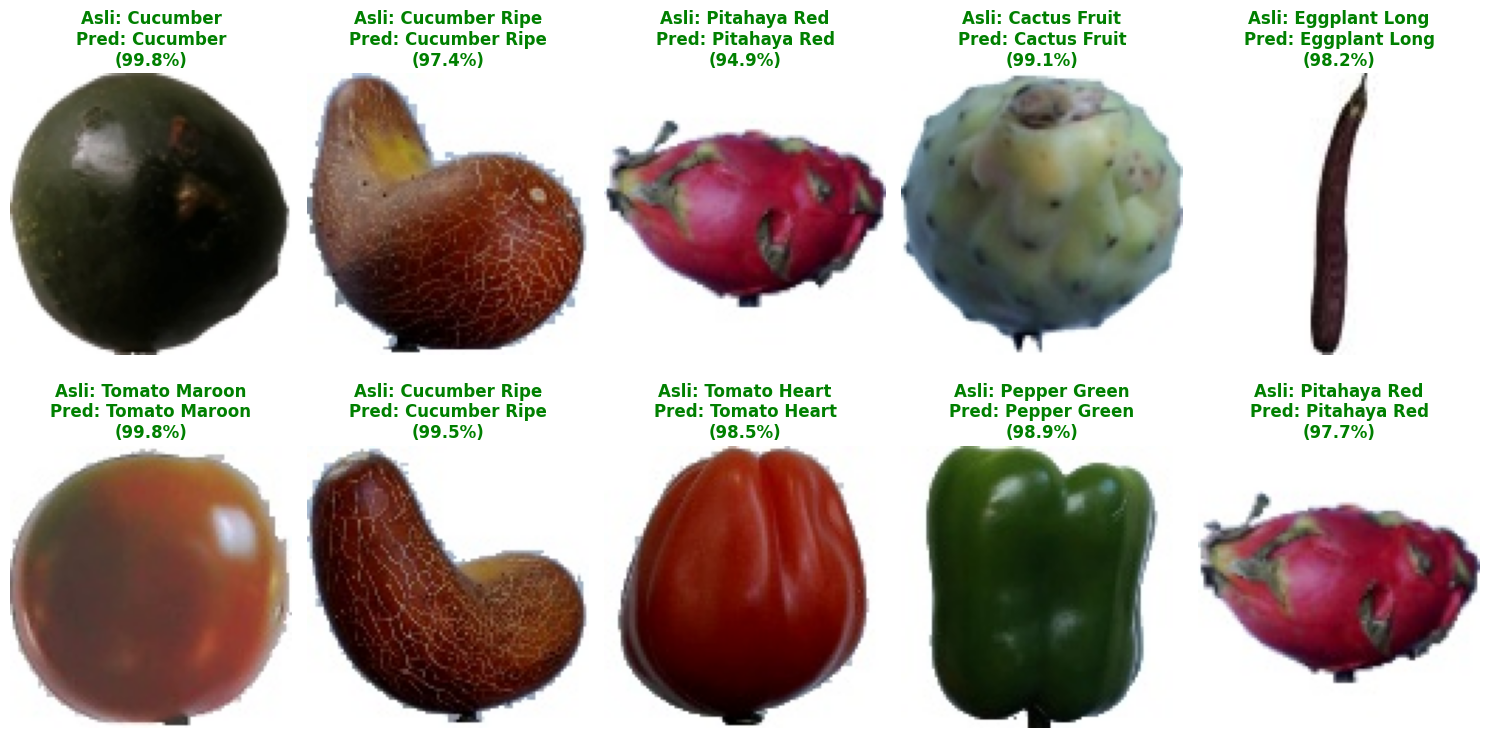

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random

def visualize_svm_predictions(model, scaler, dataset_path, num_samples=10, threshold=0.7):
    test_path = os.path.join(dataset_path, 'Test')
    classes = sorted(os.listdir(test_path))

    # Ambil sampel acak dari folder test
    samples = []
    for _ in range(num_samples):
        random_class = random.choice(classes)
        class_folder = os.path.join(test_path, random_class)
        random_file = random.choice(os.listdir(class_folder))
        samples.append((os.path.join(class_folder, random_file), random_class))

    # Setup Plot
    plt.figure(figsize=(15, 8))

    for i, (img_path, true_label) in enumerate(samples):
        # 1. Baca & Praproses untuk Display
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 2. Ekstraksi Fitur untuk Prediksi (Sama seperti training)
        # Pastikan fungsi extract_all_features sudah didefinisikan!
        features = extract_all_features(img_path)

        # 3. Prediksi
        if features is not None:
            # Standarisasi fitur sebelum masuk SVM
            features_scaled = scaler.transform([features])
            # prediction = model.predict(features_scaled)[0]
            prediction = model.predict_proba(features_scaled)[0]

            confidence = np.max(prediction)
            pred_idx = np.argmax(prediction)
            label = class_names[pred_idx]

            # --- LOGIKA UNTUK GAMBAR ASING (THRESHOLDING) ---
            if confidence < threshold:
                result_text = f"TIDAK DIKENALI\n(Mirip {label} {confidence*100:.1f}%)"
                is_unknown = True
            else:
                result_text = f"{label}\n({confidence*100:.1f}%)"
                is_unknown = False

            # Tentukan warna teks (Hijau=Benar, Merah=Salah)
            color = 'green' if label == true_label else 'red'

            # Tampilkan
            plt.subplot(2, 5, i+1)
            plt.imshow(img_rgb)
            plt.title(f"Asli: {true_label}\nPred: {result_text}", color=color, fontweight='bold')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- EKSEKUSI (Pastikan model & scaler sudah ada di memori) ---
print("Visualisasi Hasil Prediksi SVM...")
# Gunakan DATASET_PATH yang valid (lokal atau drive)
visualize_svm_predictions(svm_model, svm_scaler, DATASET_PATH, num_samples=10)

# PERCOBAAN 2

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/PBL KEL 5 SEM 5/fruit-clean.zip" -d "/content"

Mounted at /content/drive



🍎 DUAL MODEL TRAINING SYSTEM


🚀 PHASE 1: FAST MODEL

LOADING FAST - Training
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Training: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it]


✅ Berhasil: 23010 | ❌ Gagal: 0
Dimensi fitur: (23010, 508)

LOADING FAST - Test
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Test: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


✅ Berhasil: 7662 | ❌ Gagal: 0
Dimensi fitur: (7662, 508)

TRAINING FAST MODEL
Classes: ['Beans' 'Cactus Fruit' 'Corn Husk' 'Cucumber' 'Cucumber Ripe' 'Eggplant'
 'Eggplant Long' 'Pepino' 'Pepper Green' 'Pepper Orange' 'Pepper Red'
 'Pepper Yellow' 'Pitahaya Red' 'Tamarillo' 'Tomato'
 'Tomato Cherry Maroon' 'Tomato Cherry Orange' 'Tomato Cherry Red'
 'Tomato Cherry Yellow' 'Tomato Heart' 'Tomato Maroon' 'Tomato Not Ripe'
 'Tomato Yellow' 'Zucchini' 'Zucchini Dark']
Training SVM...

📊 Results:
  Train Accuracy: 100.00%
  Test Accuracy: 98.42%
  Overfitting Gap: 1.58%

                      precision    recall  f1-score   support

               Beans       1.00      1.00      1.00        77
        Cactus Fruit       0.85      1.00      0.92       634
           Corn Husk       1.00      0.62      0.77       154
            Cucumber       1.00      1.00      1.00      1378
       Cucumber Ripe       1.00      1.00      1.00       286
            Eggplant       1.00      0.74      0.85   

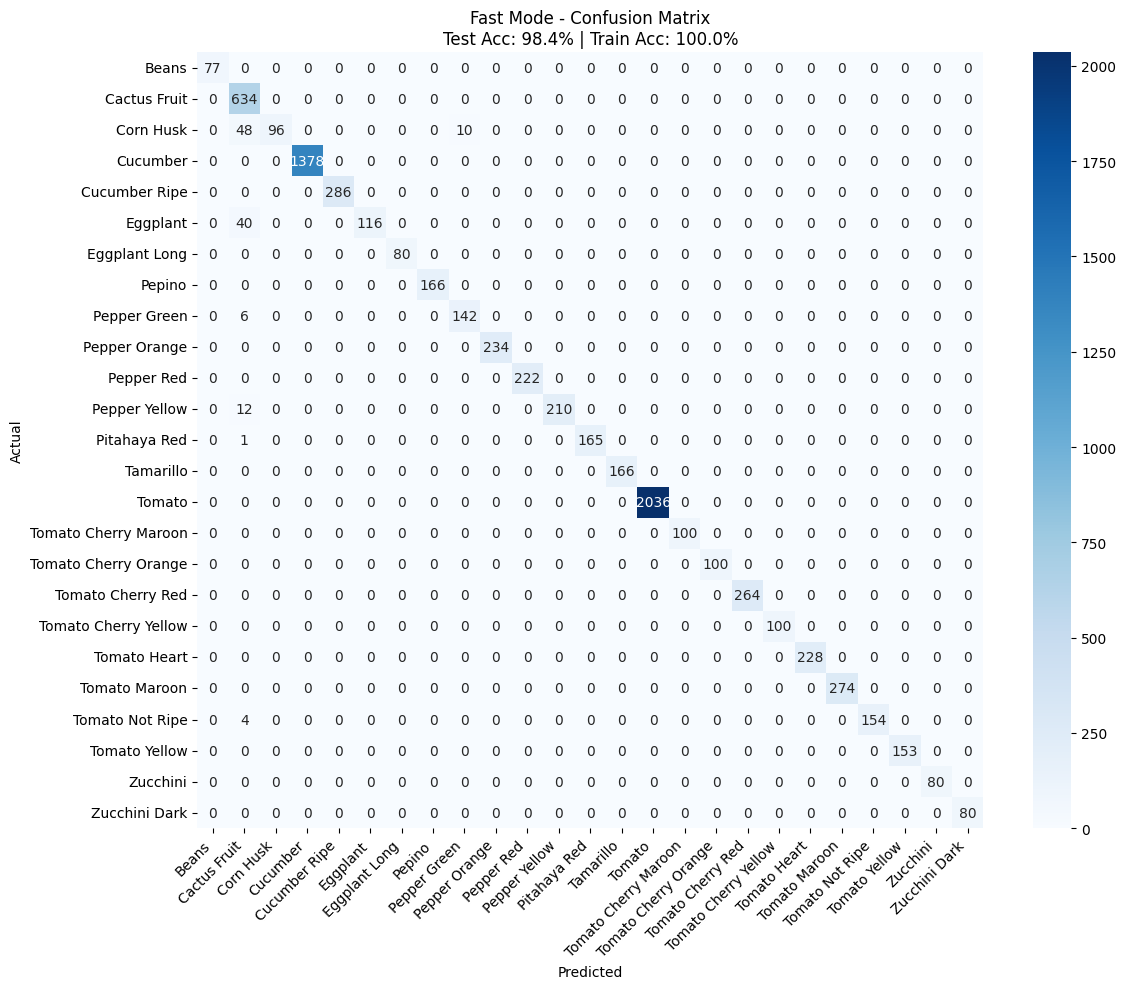


💾 Saving Fast Model...
✅ Fast model saved!


🎯 PHASE 2: ACCURATE MODEL

LOADING ACCURATE - Training
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Training: 100%|██████████| 25/25 [01:58<00:00,  4.72s/it]


✅ Berhasil: 23010 | ❌ Gagal: 0
Dimensi fitur: (23010, 1417)

LOADING ACCURATE - Test
Ditemukan 25 kelas: ['Beans', 'Cactus Fruit', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Eggplant', 'Eggplant Long', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pitahaya Red', 'Tamarillo', 'Tomato', 'Tomato Cherry Maroon', 'Tomato Cherry Orange', 'Tomato Cherry Red', 'Tomato Cherry Yellow', 'Tomato Heart', 'Tomato Maroon', 'Tomato Not Ripe', 'Tomato Yellow', 'Zucchini', 'Zucchini Dark']


Test: 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


✅ Berhasil: 7662 | ❌ Gagal: 0
Dimensi fitur: (7662, 1417)

TRAINING ACCURATE MODEL
Classes: ['Beans' 'Cactus Fruit' 'Corn Husk' 'Cucumber' 'Cucumber Ripe' 'Eggplant'
 'Eggplant Long' 'Pepino' 'Pepper Green' 'Pepper Orange' 'Pepper Red'
 'Pepper Yellow' 'Pitahaya Red' 'Tamarillo' 'Tomato'
 'Tomato Cherry Maroon' 'Tomato Cherry Orange' 'Tomato Cherry Red'
 'Tomato Cherry Yellow' 'Tomato Heart' 'Tomato Maroon' 'Tomato Not Ripe'
 'Tomato Yellow' 'Zucchini' 'Zucchini Dark']
Training SVM...

📊 Results:
  Train Accuracy: 100.00%
  Test Accuracy: 96.71%
  Overfitting Gap: 3.29%

                      precision    recall  f1-score   support

               Beans       1.00      1.00      1.00        77
        Cactus Fruit       0.81      1.00      0.89       634
           Corn Husk       1.00      0.63      0.77       154
            Cucumber       0.96      1.00      0.98      1378
       Cucumber Ripe       1.00      0.99      1.00       286
            Eggplant       1.00      0.72      0.

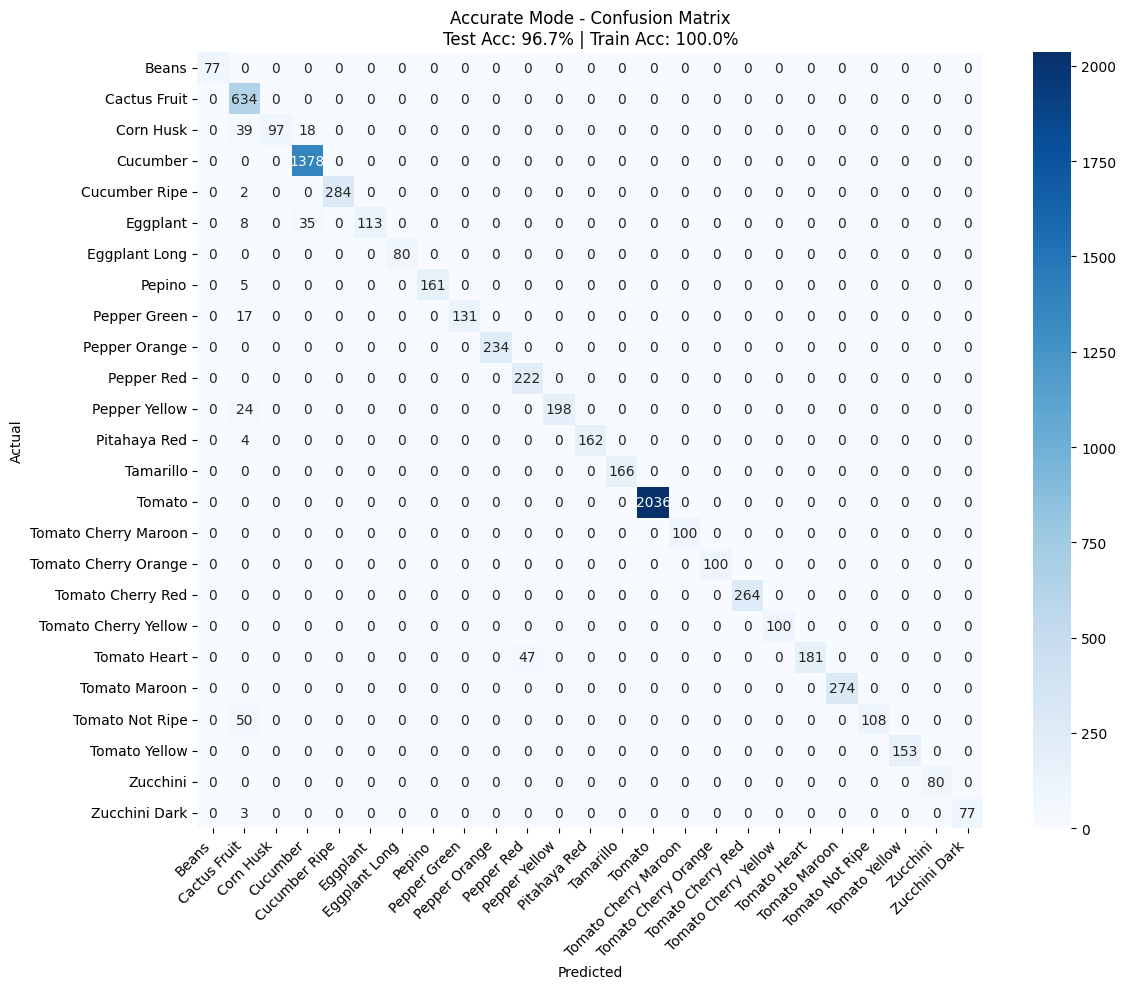


💾 Saving Accurate Model...
✅ Accurate model saved!


📊 TRAINING SUMMARY

⚡ FAST MODEL:
  Features: 508
  Train Accuracy: 100.00%
  Test Accuracy: 98.42%

🎯 ACCURATE MODEL:
  Features: 1417
  Train Accuracy: 100.00%
  Test Accuracy: 96.71%

📈 COMPARISON:
  Accuracy Diff: 1.71%
  Feature Diff: 909 features

✅ ALL DONE!
📁 Models saved to: /content/fruit-clean/Output_Artifacts

Files generated:
  - svm_fast_model.pkl
  - scaler_fast.pkl
  - label_encoder_fast.pkl
  - svm_accurate_model.pkl
  - scaler_accurate.pkl
  - label_encoder_accurate.pkl
  - confusion_matrix_fast.png
  - confusion_matrix_accurate.png


In [ ]:
"""
TRAINING SCRIPT UNTUK DUAL MODEL SYSTEM
Run di Google Colab untuk membuat 2 model:
1. Fast Model - Cepat, fitur sedikit
2. Accurate Model - Akurat, fitur lengkap
"""

import os
import cv2
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops, hog
from concurrent.futures import ProcessPoolExecutor

# ==========================================
# SETUP PATHS
# ==========================================
DATASET_PATH = '/content/fruit-clean'

# Folder untuk menyimpan Fitur (.npy) dan Model (.pkl)
ARTIFACTS_PATH = os.path.join(DATASET_PATH, 'Output_Artifacts')
# DATASET_PATH = '/content/drive/MyDrive/fruit_dataset'  # Sesuaikan
# ARTIFACTS_PATH = '/content/drive/MyDrive/Output_Artifacts'

os.makedirs(ARTIFACTS_PATH, exist_ok=True)

# ==========================================
# FAST MODE FEATURE EXTRACTION
# ==========================================

def preprocess_image_fast(image_path, target_size=(100, 100)):
    """Fast: Tanpa background removal"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        return img_rgb, img_gray
    except:
        return None

def extract_color_fast(img_rgb):
    """Color: [6,6,6] = 216 fitur"""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [6, 6, 6],
                       [0, 180, 0, 256, 0, 256])
    hist = hist.flatten()
    norm = np.linalg.norm(hist)
    return hist / norm if norm > 0 else hist

def extract_texture_fast(img_gray):
    """Texture: 2 angles, 4 features"""
    if img_gray.dtype != np.uint8:
        img_gray = (img_gray * 255).astype(np.uint8)

    img_q = (img_gray // 8).astype(np.uint8)
    glcm = graycomatrix(img_q, [1], [0, np.pi/2], 32, symmetric=True, normed=True)

    return np.array([
        np.mean(graycoprops(glcm, 'contrast')),
        np.mean(graycoprops(glcm, 'homogeneity')),
        np.mean(graycoprops(glcm, 'energy')),
        np.mean(graycoprops(glcm, 'correlation'))
    ])

def extract_shape_fast(img_gray):
    """Shape: pixels_per_cell=(25,25)"""
    if img_gray.dtype != np.float32:
        img_gray = img_gray.astype('float32') / 255.0

    return hog(img_gray, orientations=8, pixels_per_cell=(25, 25),
              cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

def extract_features_fast(image_path):
    """Pipeline Fast"""
    result = preprocess_image_fast(image_path)
    if result is None:
        return None

    img_rgb, img_gray = result

    color = extract_color_fast(img_rgb)
    texture = extract_texture_fast(img_gray)
    shape = extract_shape_fast(img_gray)

    return np.hstack([color, texture, shape])

# ==========================================
# ACCURATE MODE FEATURE EXTRACTION
# ==========================================

def remove_background(img_bgr):
    """Background removal untuk Accurate mode"""
    try:
        blurred = cv2.GaussianBlur(img_bgr, (5, 5), 0)
        hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
        s = hsv[:, :, 1]

        _, mask = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            c = max(contours, key=cv2.contourArea)
            clean_mask = np.zeros_like(s)
            cv2.drawContours(clean_mask, [c], -1, 255, -1)
            return cv2.bitwise_and(img_bgr, img_bgr, mask=clean_mask)

        return img_bgr
    except:
        return img_bgr

def preprocess_image_accurate(image_path, target_size=(100, 100)):
    """Accurate: Dengan background removal"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img_seg = remove_background(img)

        img_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

        return img_rgb, img_gray
    except:
        return None

def extract_color_accurate(img_rgb):
    """Color: [8,8,8] = 512 fitur dengan masking"""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    hist = cv2.calcHist([hsv], [0, 1, 2], mask if np.sum(mask) > 0 else None,
                       [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = hist.flatten()
    norm = np.linalg.norm(hist)
    return hist / norm if norm > 0 else hist

def extract_texture_accurate(img_gray):
    """Texture: 3 angles, 5 features"""
    if img_gray.dtype != np.uint8:
        img_gray = (img_gray * 255).astype(np.uint8)

    if np.std(img_gray) < 10:
        img_gray = cv2.equalizeHist(img_gray)

    img_q = (img_gray // 8).astype(np.uint8)
    glcm = graycomatrix(img_q, [1], [0, np.pi/4, np.pi/2], 32,
                       symmetric=True, normed=True)

    return np.array([
        np.mean(graycoprops(glcm, 'contrast')),
        np.mean(graycoprops(glcm, 'dissimilarity')),
        np.mean(graycoprops(glcm, 'homogeneity')),
        np.mean(graycoprops(glcm, 'energy')),
        np.mean(graycoprops(glcm, 'correlation'))
    ])

def extract_shape_accurate(img_gray):
    """Shape: pixels_per_cell=(16,16)"""
    if img_gray.dtype != np.float32:
        img_gray = img_gray.astype('float32') / 255.0

    return hog(img_gray, orientations=9, pixels_per_cell=(16, 16),
              cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

def extract_features_accurate(image_path):
    """Pipeline Accurate"""
    result = preprocess_image_accurate(image_path)
    if result is None:
        return None

    img_rgb, img_gray = result

    color = extract_color_accurate(img_rgb)
    texture = extract_texture_accurate(img_gray)
    shape = extract_shape_accurate(img_gray)

    return np.hstack([color, texture, shape])

# ==========================================
# DATASET LOADING
# ==========================================

def load_dataset(root_path, folder_name, extract_func, mode_name):
    """Load dataset dengan fungsi ekstraksi tertentu"""
    print(f"\n{'='*60}")
    print(f"LOADING {mode_name.upper()} - {folder_name}")
    print(f"{'='*60}")

    target_path = os.path.join(root_path, folder_name)

    if not os.path.exists(target_path):
        print(f"❌ Folder tidak ditemukan: {target_path}")
        return np.array([]), np.array([])

    classes = sorted([d for d in os.listdir(target_path)
                     if os.path.isdir(os.path.join(target_path, d))])

    print(f"Ditemukan {len(classes)} kelas: {classes}")

    features = []
    labels = []
    failed = 0

    for class_name in tqdm(classes, desc=f"{folder_name}"):
        class_folder = os.path.join(target_path, class_name)

        for fname in os.listdir(class_folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                fpath = os.path.join(class_folder, fname)

                feat = extract_func(fpath)

                if feat is not None and not np.any(np.isnan(feat)) and not np.any(np.isinf(feat)):
                    features.append(feat)
                    labels.append(class_name)
                else:
                    failed += 1

    X = np.array(features)
    y = np.array(labels)

    print(f"✅ Berhasil: {len(X)} | ❌ Gagal: {failed}")
    print(f"Dimensi fitur: {X.shape}")

    return X, y

# ==========================================
# TRAINING FUNCTION
# ==========================================

def train_model(X_train, y_train, X_test, y_test, mode_name):
    """Train SVM model"""
    print(f"\n{'='*60}")
    print(f"TRAINING {mode_name.upper()} MODEL")
    print(f"{'='*60}")

    # Label Encoding
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    print(f"Classes: {le.classes_}")

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM
    print("Training SVM...")
    svm = SVC(
        kernel='rbf',
        C=10.0,
        gamma='scale',
        probability=True,
        random_state=42,
        class_weight='balanced',
        cache_size=500
    )

    svm.fit(X_train_scaled, y_train_enc)

    # Evaluate
    y_train_pred = svm.predict(X_train_scaled)
    y_test_pred = svm.predict(X_test_scaled)

    train_acc = accuracy_score(y_train_enc, y_train_pred)
    test_acc = accuracy_score(y_test_enc, y_test_pred)

    print(f"\n📊 Results:")
    print(f"  Train Accuracy: {train_acc*100:.2f}%")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
    print(f"  Overfitting Gap: {(train_acc-test_acc)*100:.2f}%")

    # Classification Report
    y_test_pred_labels = le.inverse_transform(y_test_pred)
    print(f"\n{classification_report(y_test, y_test_pred_labels)}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred_labels)
    plt.figure(figsize=(12, 10))

    unique_labels = sorted(list(set(y_test)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels)

    plt.title(f'{mode_name.capitalize()} Mode - Confusion Matrix\n'
             f'Test Acc: {test_acc*100:.1f}% | Train Acc: {train_acc*100:.1f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    cm_path = os.path.join(ARTIFACTS_PATH, f'confusion_matrix_{mode_name}.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"💾 Confusion matrix saved: {cm_path}")
    plt.show()

    return svm, scaler, le, train_acc, test_acc

# ==========================================
# MAIN EXECUTION
# ==========================================

def main():
    print("\n" + "="*60)
    print("🍎 DUAL MODEL TRAINING SYSTEM")
    print("="*60)

    # ============ TRAIN FAST MODEL ============
    print("\n\n🚀 PHASE 1: FAST MODEL")

    X_train_fast, y_train_fast = load_dataset(
        DATASET_PATH, 'Training', extract_features_fast, 'fast'
    )
    X_test_fast, y_test_fast = load_dataset(
        DATASET_PATH, 'Test', extract_features_fast, 'fast'
    )

    if len(X_train_fast) > 0 and len(X_test_fast) > 0:
        svm_fast, scaler_fast, le_fast, train_acc_fast, test_acc_fast = train_model(
            X_train_fast, y_train_fast, X_test_fast, y_test_fast, 'fast'
        )

        # Save Fast Model
        print("\n💾 Saving Fast Model...")
        joblib.dump(svm_fast, os.path.join(ARTIFACTS_PATH, 'svm_fast_model.pkl'))
        joblib.dump(scaler_fast, os.path.join(ARTIFACTS_PATH, 'scaler_fast.pkl'))
        joblib.dump(le_fast, os.path.join(ARTIFACTS_PATH, 'label_encoder_fast.pkl'))
        print("✅ Fast model saved!")
    else:
        print("❌ Fast model training skipped - no data")

    # ============ TRAIN ACCURATE MODEL ============
    print("\n\n🎯 PHASE 2: ACCURATE MODEL")

    X_train_acc, y_train_acc = load_dataset(
        DATASET_PATH, 'Training', extract_features_accurate, 'accurate'
    )
    X_test_acc, y_test_acc = load_dataset(
        DATASET_PATH, 'Test', extract_features_accurate, 'accurate'
    )

    if len(X_train_acc) > 0 and len(X_test_acc) > 0:
        svm_acc, scaler_acc, le_acc, train_acc_acc, test_acc_acc = train_model(
            X_train_acc, y_train_acc, X_test_acc, y_test_acc, 'accurate'
        )

        # Save Accurate Model
        print("\n💾 Saving Accurate Model...")
        joblib.dump(svm_acc, os.path.join(ARTIFACTS_PATH, 'svm_accurate_model.pkl'))
        joblib.dump(scaler_acc, os.path.join(ARTIFACTS_PATH, 'scaler_accurate.pkl'))
        joblib.dump(le_acc, os.path.join(ARTIFACTS_PATH, 'label_encoder_accurate.pkl'))
        print("✅ Accurate model saved!")
    else:
        print("❌ Accurate model training skipped - no data")

    # ============ SUMMARY ============
    print("\n\n" + "="*60)
    print("📊 TRAINING SUMMARY")
    print("="*60)

    if len(X_train_fast) > 0:
        print(f"\n⚡ FAST MODEL:")
        print(f"  Features: {X_train_fast.shape[1]}")
        print(f"  Train Accuracy: {train_acc_fast*100:.2f}%")
        print(f"  Test Accuracy: {test_acc_fast*100:.2f}%")

    if len(X_train_acc) > 0:
        print(f"\n🎯 ACCURATE MODEL:")
        print(f"  Features: {X_train_acc.shape[1]}")
        print(f"  Train Accuracy: {train_acc_acc*100:.2f}%")
        print(f"  Test Accuracy: {test_acc_acc*100:.2f}%")

    if len(X_train_fast) > 0 and len(X_train_acc) > 0:
        print(f"\n📈 COMPARISON:")
        print(f"  Accuracy Diff: {abs(test_acc_acc - test_acc_fast)*100:.2f}%")
        print(f"  Feature Diff: {X_train_acc.shape[1] - X_train_fast.shape[1]} features")

    print("\n✅ ALL DONE!")
    print(f"📁 Models saved to: {ARTIFACTS_PATH}")
    print("\nFiles generated:")
    print("  - svm_fast_model.pkl")
    print("  - scaler_fast.pkl")
    print("  - label_encoder_fast.pkl")
    print("  - svm_accurate_model.pkl")
    print("  - scaler_accurate.pkl")
    print("  - label_encoder_accurate.pkl")
    print("  - confusion_matrix_fast.png")
    print("  - confusion_matrix_accurate.png")

# Run
if __name__ == "__main__":
    main()

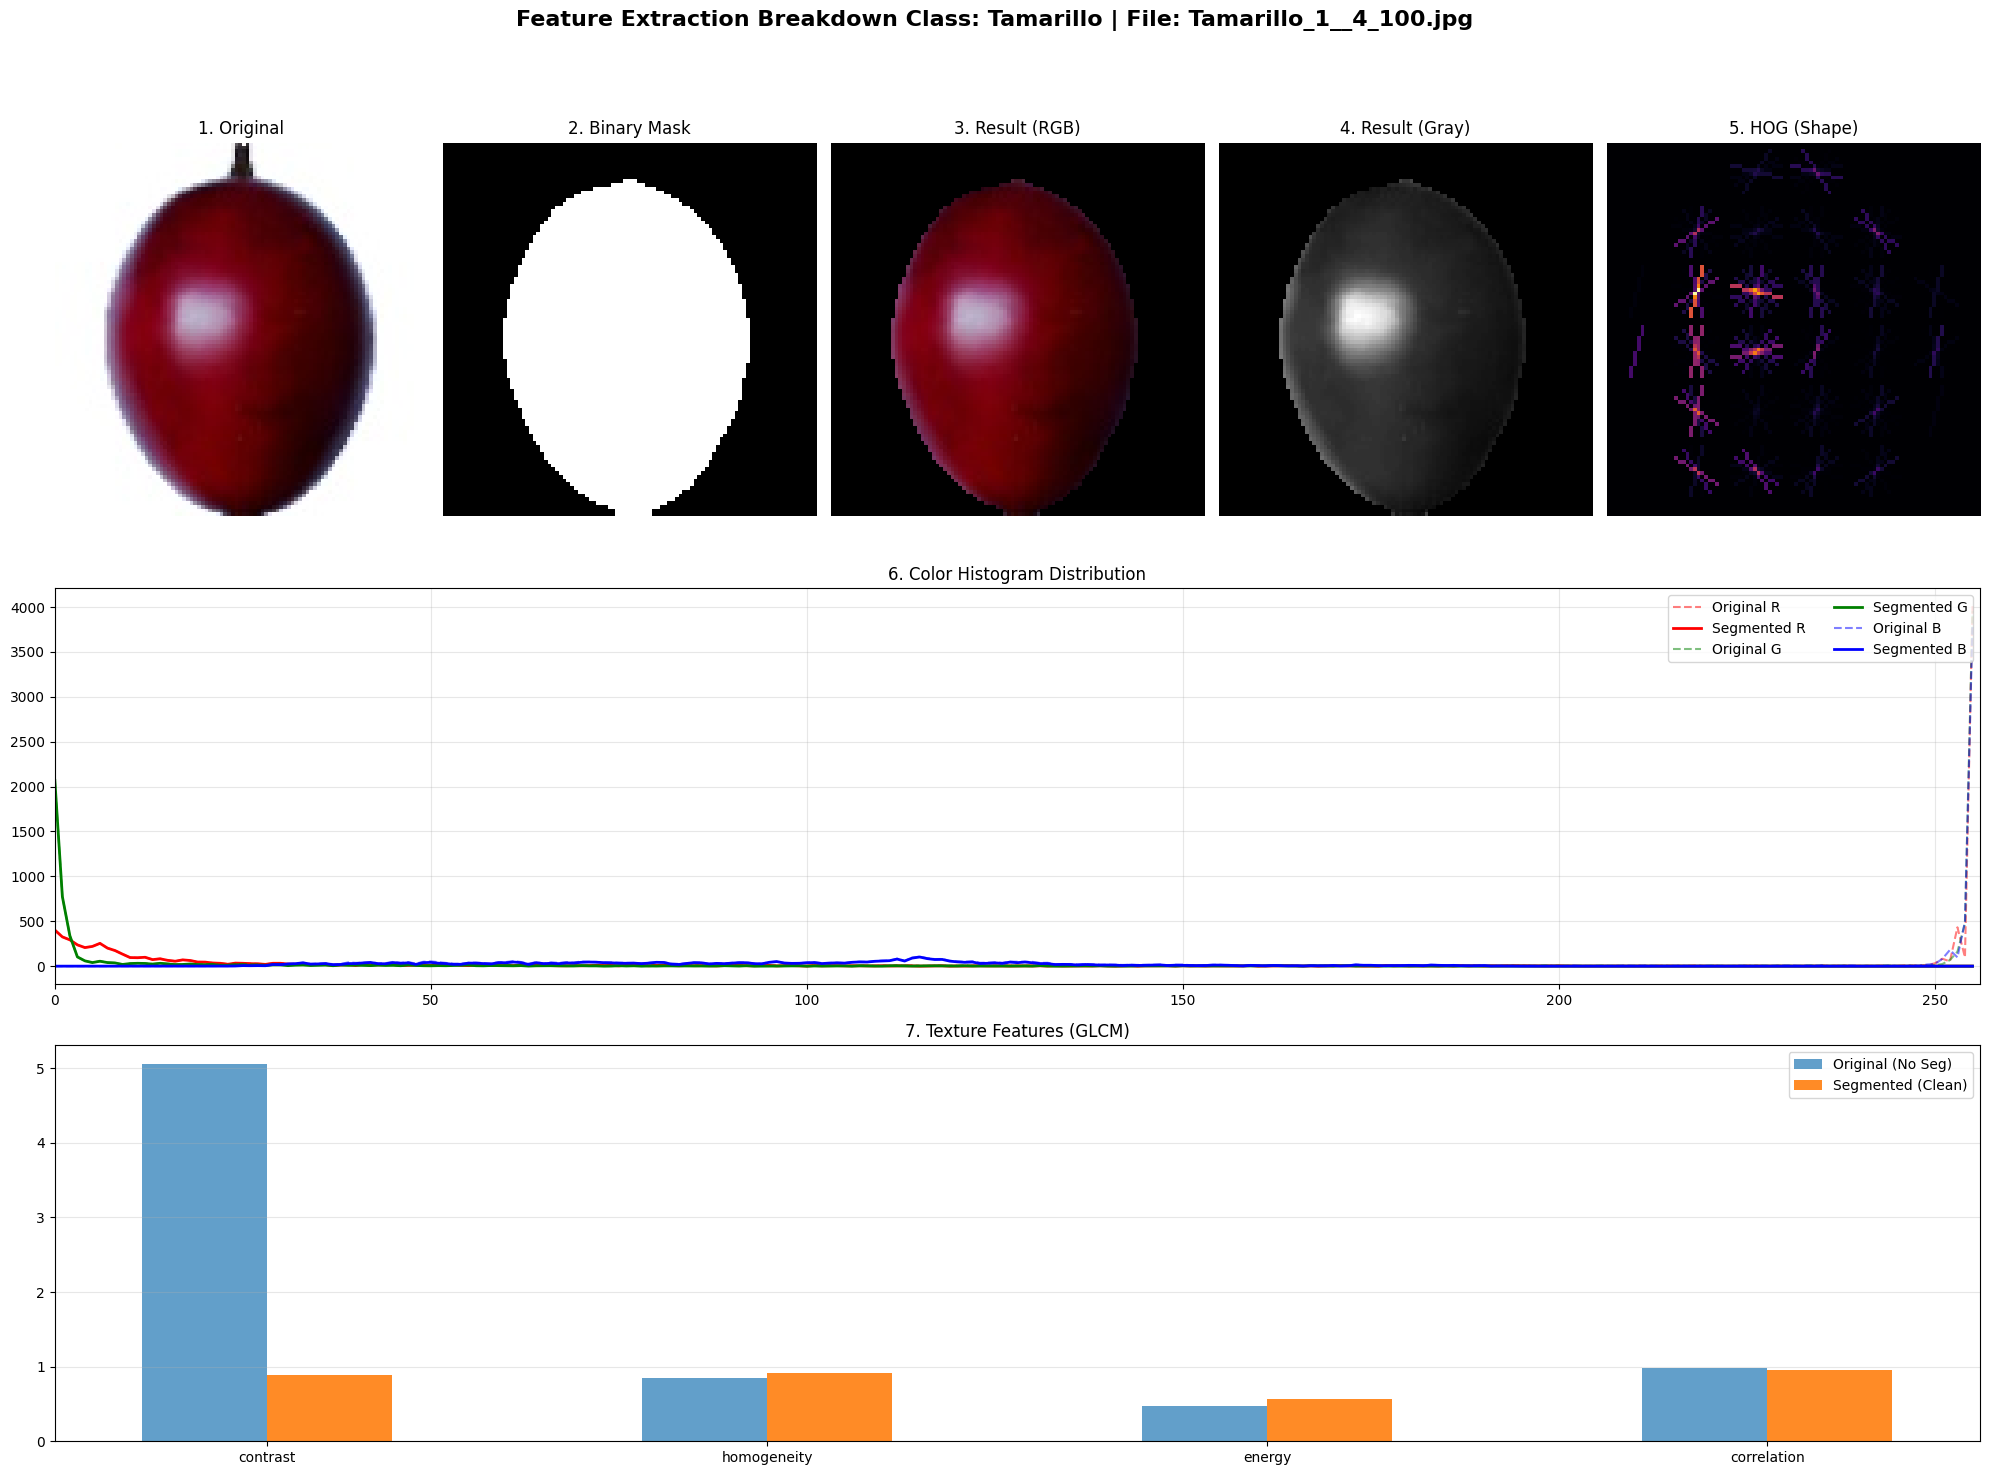

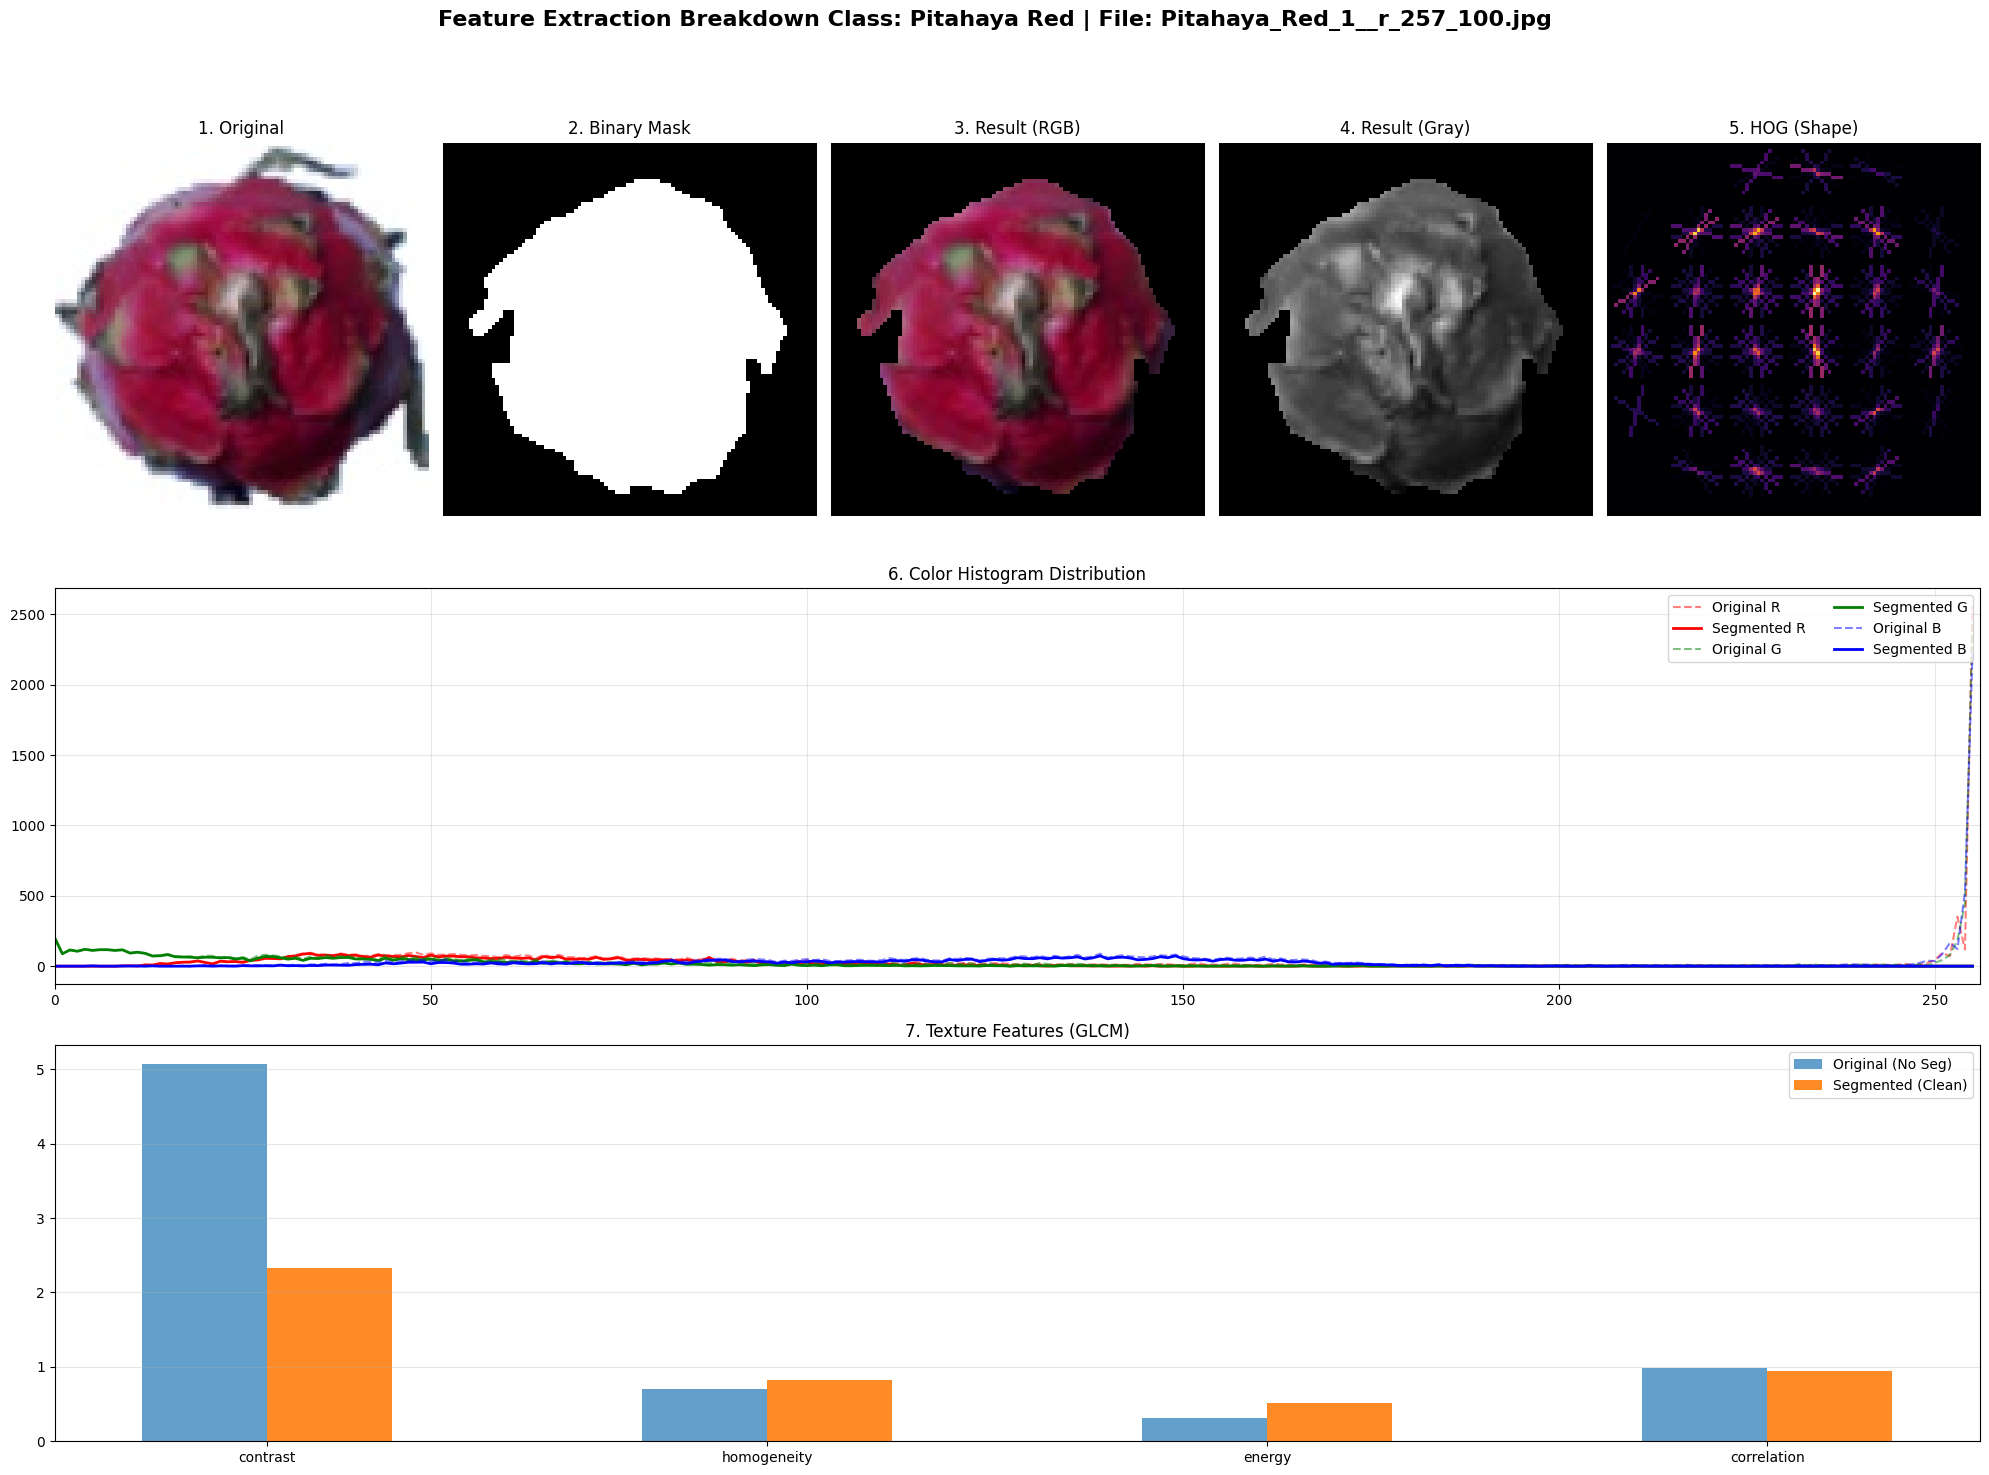

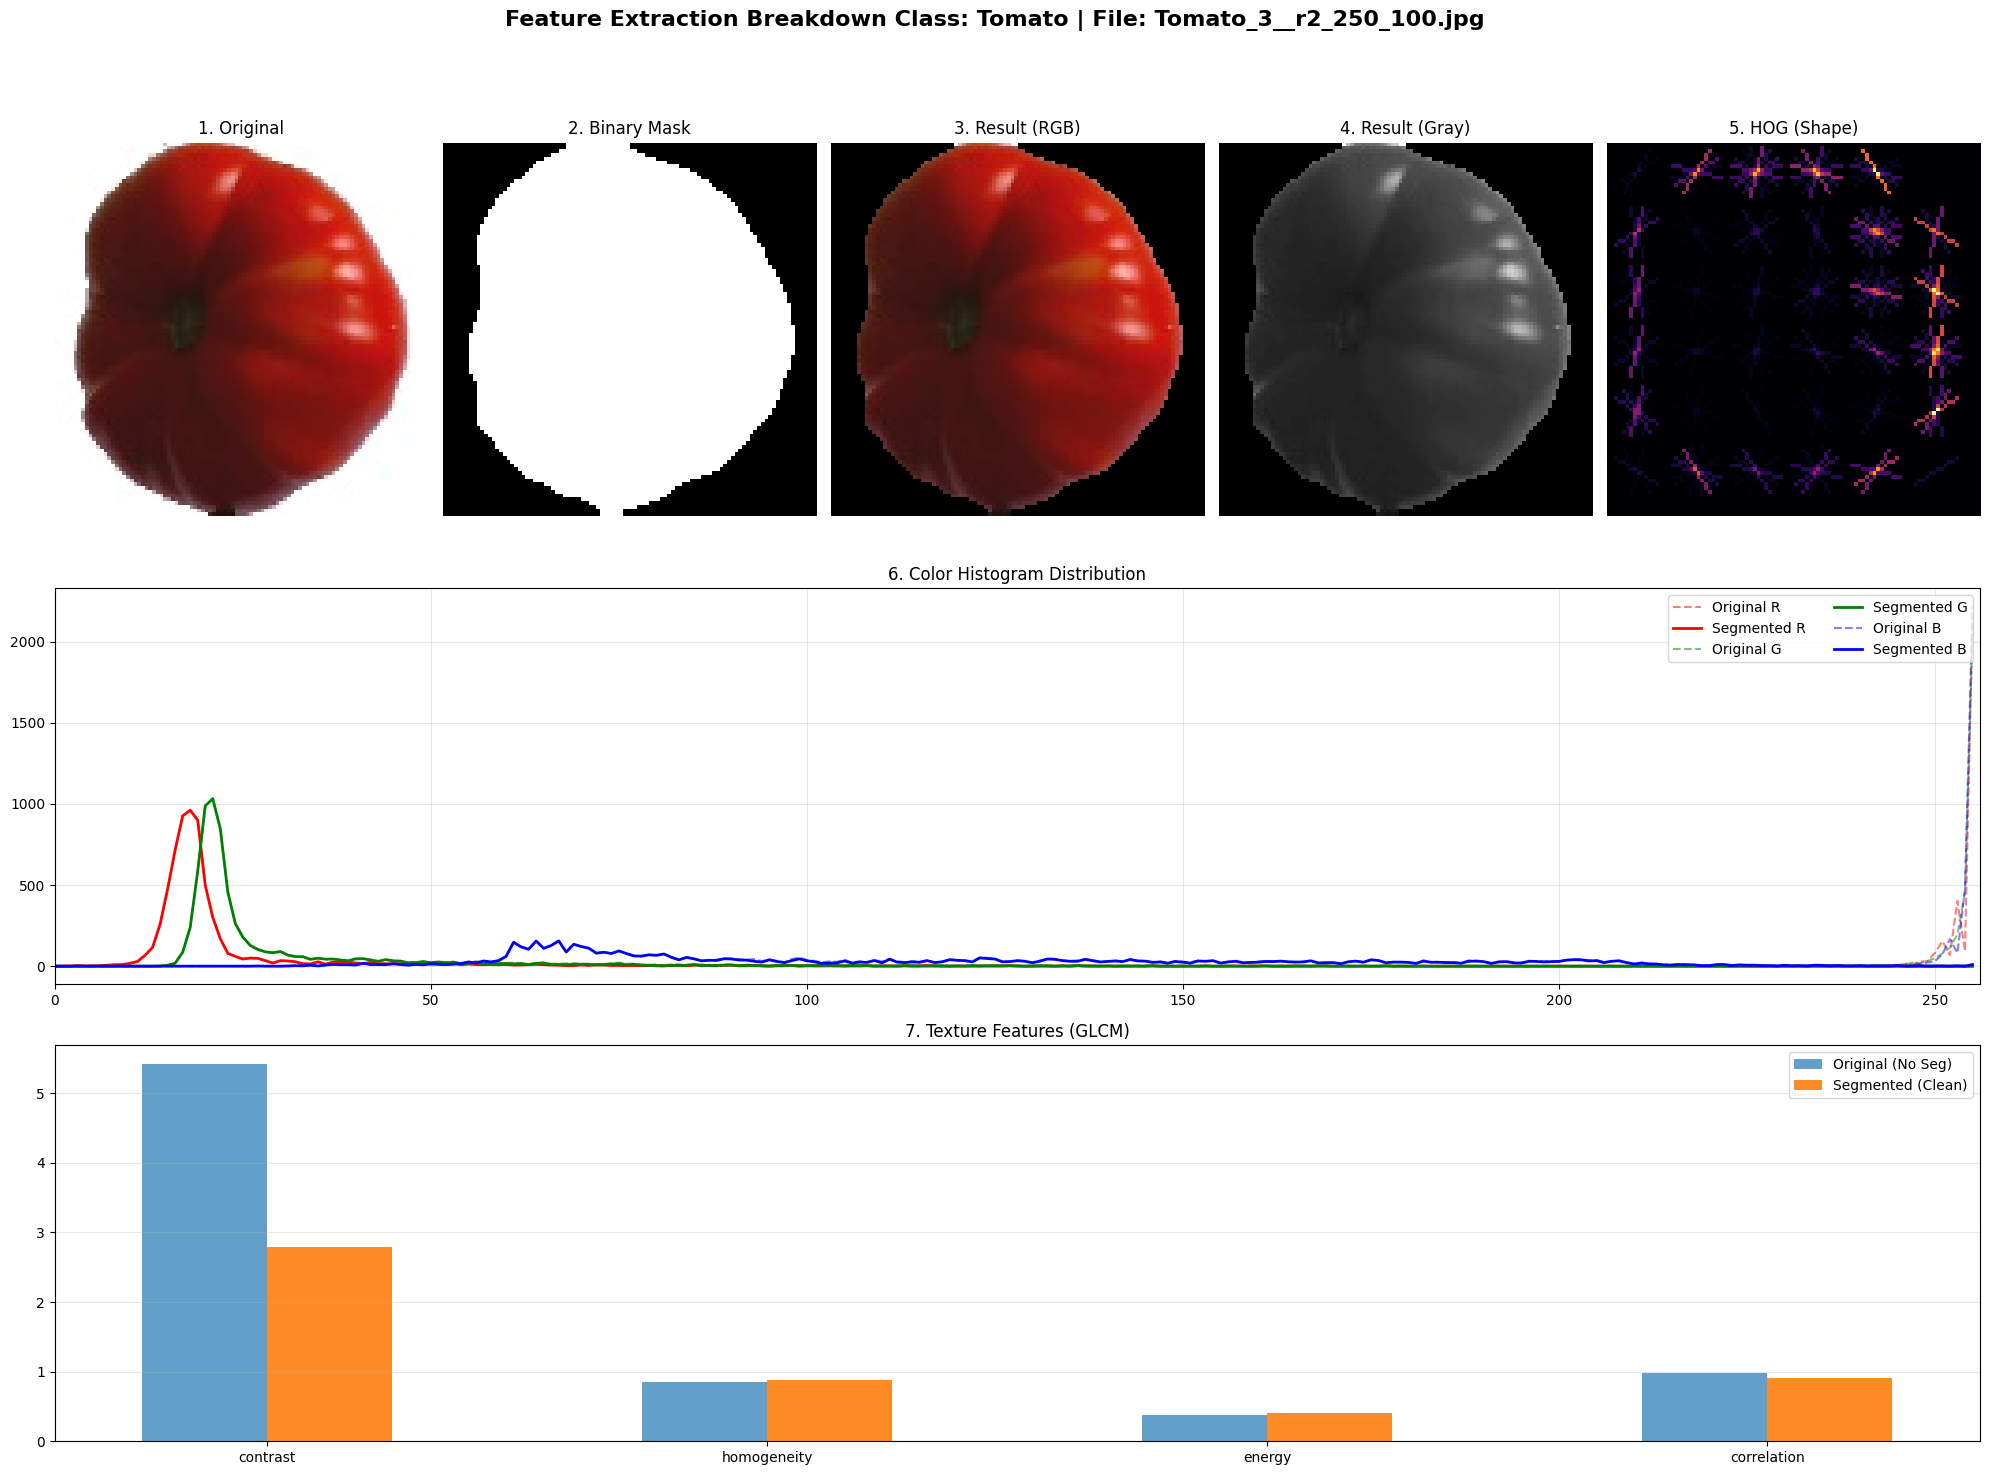

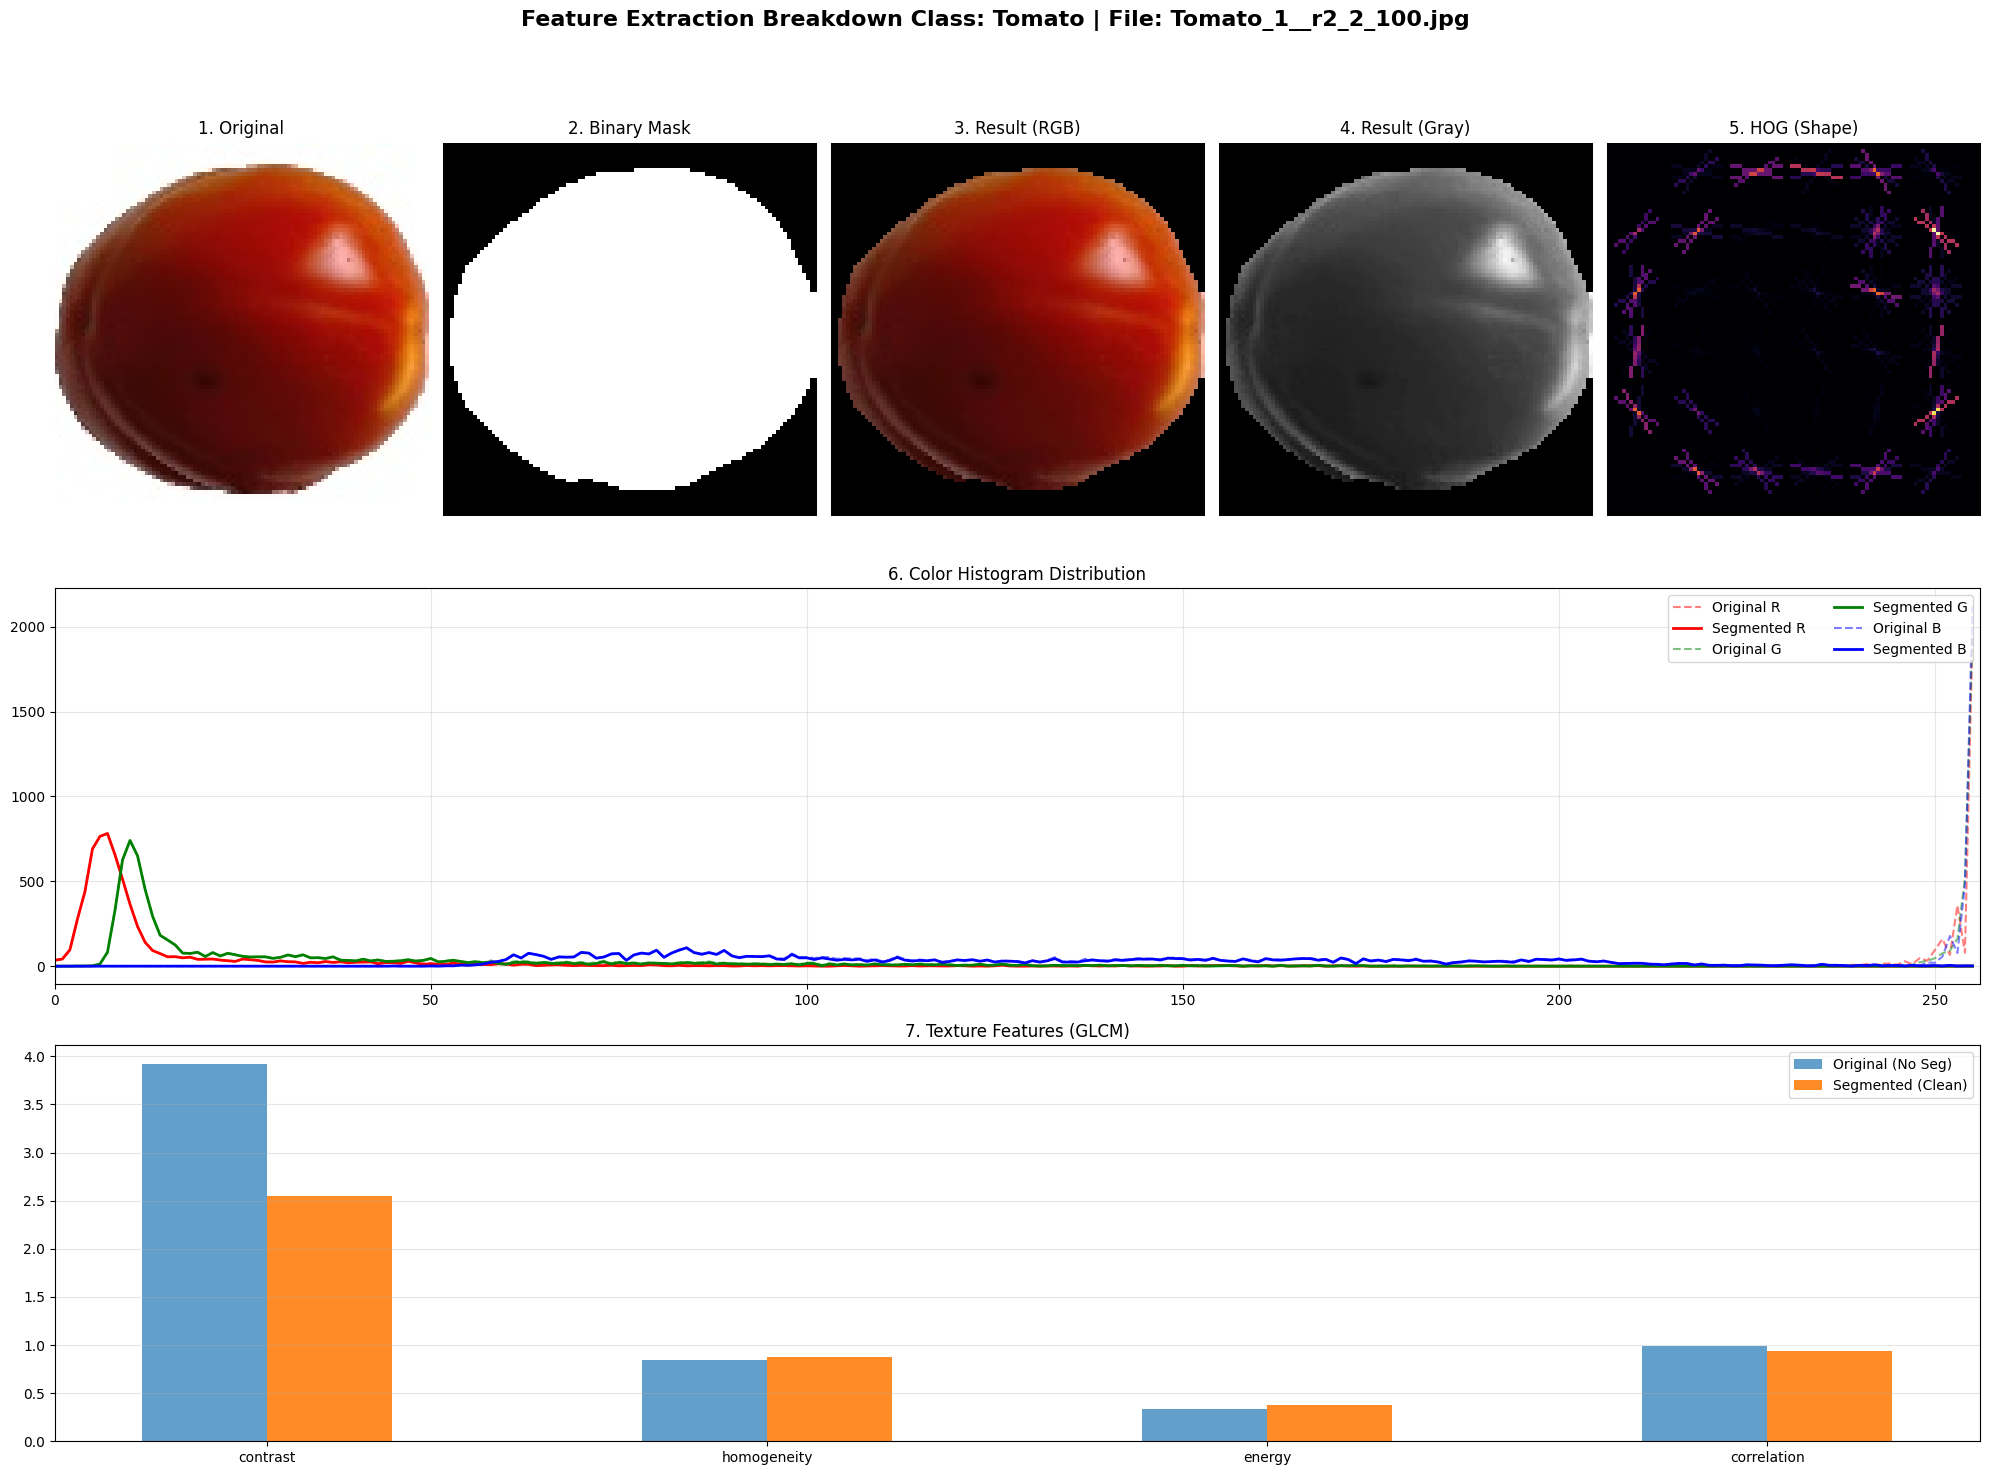

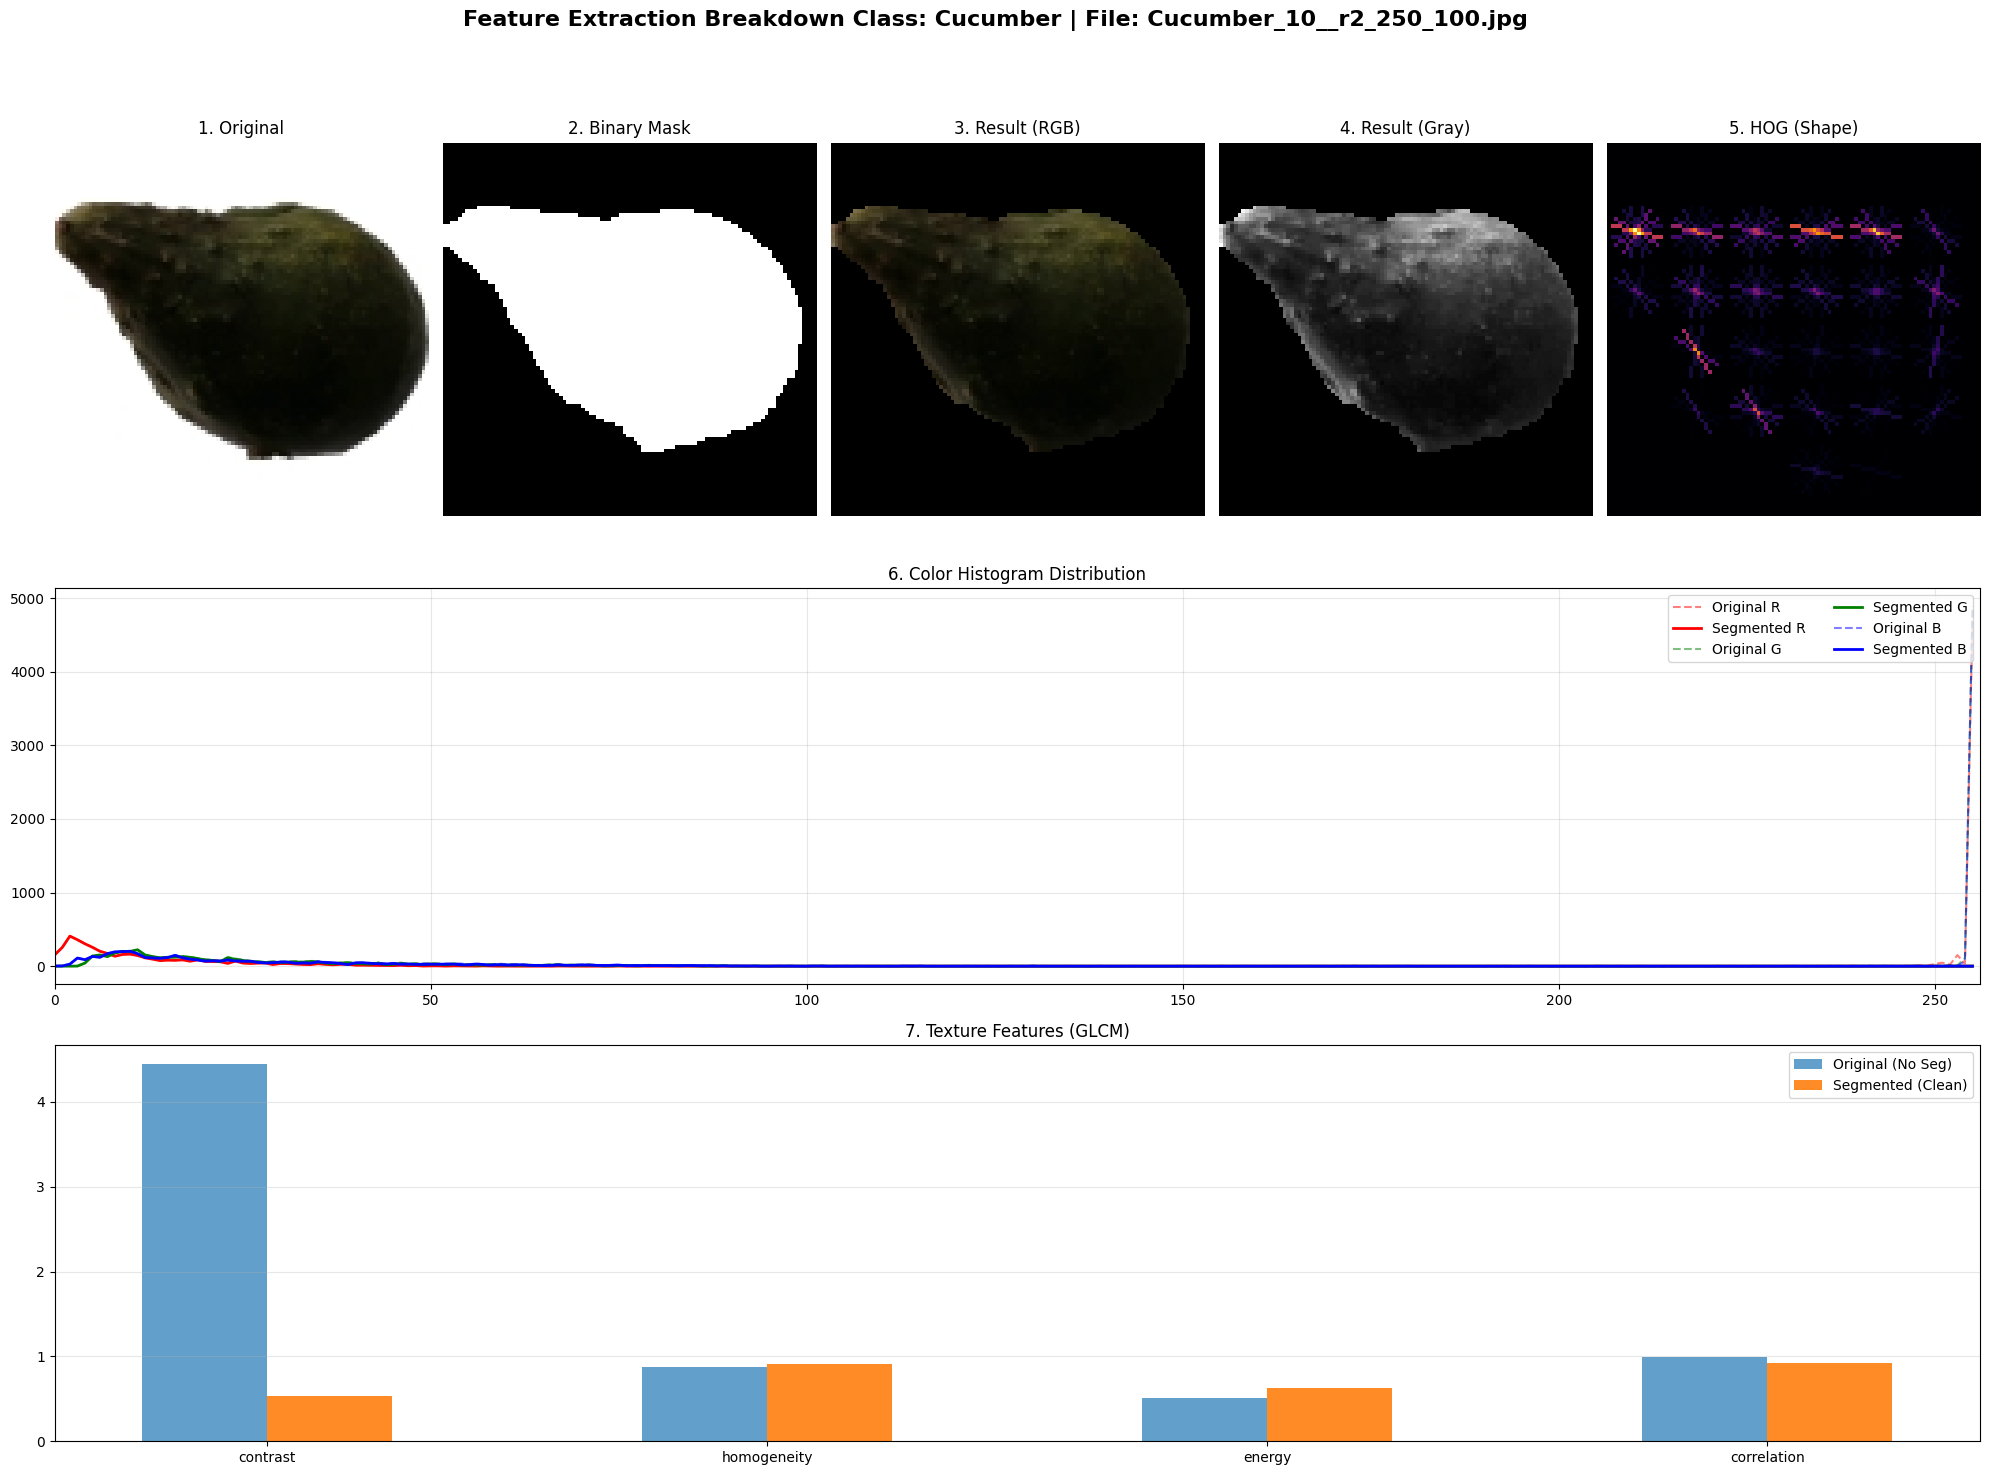

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from skimage.feature import graycomatrix, graycoprops, hog

# ==========================================
# CONFIG
# ==========================================
DATASET_ROOT = '/content/fruit-clean/Training'

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def get_accurate_segmentation(img_bgr):
    """Mendapatkan mask dan hasil segmentasi"""
    blurred = cv2.GaussianBlur(img_bgr, (5, 5), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    s = hsv[:, :, 1]
    _, mask = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = img_bgr.copy()

    if contours:
        c = max(contours, key=cv2.contourArea)
        clean_mask = np.zeros_like(s)
        cv2.drawContours(clean_mask, [c], -1, 255, -1)
        result = cv2.bitwise_and(img_bgr, img_bgr, mask=clean_mask)
        return mask, clean_mask, result
    return mask, mask, result

def get_hog_vis(img_gray, pixels_per_cell):
    """Mendapatkan visualisasi HOG"""
    fd, hog_image = hog(img_gray, orientations=8, pixels_per_cell=pixels_per_cell,
                        cells_per_block=(2, 2), visualize=True, block_norm="L2-Hys")
    return hog_image

# ==========================================
# MAIN VISUALIZATION PIPELINE
# ==========================================

def visualize_extraction(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Gambar rusak: {image_path}")
        return

    folder_name = image_path.split(os.sep)[-2]
    file_name = image_path.split(os.sep)[-1]

    # --- PROCESSING ---
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (100, 100)) # Resize standar
    img_gray_fast = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Accurate Processing (Segmentation)
    raw_mask, clean_mask, img_seg = get_accurate_segmentation(img_resized)
    img_seg_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)
    img_gray_acc = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

    # HOG Processing
    hog_acc = get_hog_vis(img_gray_acc, (16, 16))

    fig = plt.figure(figsize=(20, 14))
    plt.suptitle(f"Feature Extraction Breakdown Class: {folder_name} | File: {file_name}", fontsize=16, fontweight='bold', y=1.05)

    # ==========================================================
    # ROW 1: IMAGE PIPELINE
    # ==========================================================

    # Col 1: Original
    ax1 = plt.subplot2grid((3, 5), (0, 0))
    ax1.imshow(img_rgb)
    ax1.set_title("1. Original")
    ax1.axis('off')

    # Col 2: Mask
    ax2 = plt.subplot2grid((3, 5), (0, 1))
    ax2.imshow(clean_mask, cmap='gray')
    ax2.set_title("2. Binary Mask")
    ax2.axis('off')

    # Col 3: Result RGB
    ax3 = plt.subplot2grid((3, 5), (0, 2))
    ax3.imshow(img_seg_rgb)
    ax3.set_title("3. Result (RGB)")
    ax3.axis('off')

    # Col 4: Result Gray
    ax4 = plt.subplot2grid((3, 5), (0, 3))
    ax4.imshow(img_gray_acc, cmap='gray')
    ax4.set_title("4. Result (Gray)")
    ax4.axis('off')

    # Col 5: HOG
    ax5 = plt.subplot2grid((3, 5), (0, 4))
    ax5.imshow(hog_acc, cmap='inferno')
    ax5.set_title("5. HOG (Shape)")
    ax5.axis('off')

    # ==========================================================
    # ROW 2: COLOR HISTOGRAM
    # ==========================================================

    ax6 = plt.subplot2grid((3, 5), (1, 0), colspan=5) # Span 5 kolom
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        # Fast (Full Image)
        hist_fast = cv2.calcHist([img_resized], [i], None, [256], [0, 256])
        ax6.plot(hist_fast, color=color, linestyle='--', alpha=0.5, label=f'Original {color.upper()}')
        # Accurate (Masked)
        hist_acc = cv2.calcHist([img_seg], [i], clean_mask, [256], [0, 256])
        ax6.plot(hist_acc, color=color, linewidth=2, label=f'Segmented {color.upper()}')

    ax6.set_title("6. Color Histogram Distribution")
    ax6.legend(loc='upper right', ncol=2)
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim([0, 256])

    # ==========================================================
    # ROW 3: TEXTURE FEATURES
    # ==========================================================

    glcm_fast = graycomatrix(img_gray_fast // 8, [1], [0], 32, symmetric=True, normed=True)
    glcm_acc = graycomatrix(img_gray_acc // 8, [1], [0], 32, symmetric=True, normed=True)

    props = ['contrast', 'homogeneity', 'energy', 'correlation']
    vals_fast = [graycoprops(glcm_fast, p)[0, 0] for p in props]
    vals_acc = [graycoprops(glcm_acc, p)[0, 0] for p in props]

    ax7 = plt.subplot2grid((3, 5), (2, 0), colspan=5) # Span 5 kolom
    x = np.arange(len(props))
    width = 0.25

    ax7.bar(x - width/2, vals_fast, width, label='Original (No Seg)', alpha=0.7)
    ax7.bar(x + width/2, vals_acc, width, label='Segmented (Clean)', alpha=0.9)

    ax7.set_xticks(x)
    ax7.set_xticklabels(props)
    ax7.set_title("7. Texture Features (GLCM)")
    ax7.legend()
    ax7.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
def run_random_visualization(root_path, num_samples=3):
    all_images = []
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                all_images.append(os.path.join(root, file))

    if not all_images:
        print("Dataset not found.")
        return

    selected = random.sample(all_images, min(len(all_images), num_samples))
    for img_path in selected:
        visualize_extraction(img_path)

run_random_visualization(DATASET_ROOT, num_samples=5)

📂 Memindai dataset di: /content/fruit-clean/Training...

✅ Ditemukan 25 Kelas Buah.
⏳ Memproses 1 gambar dari setiap kelas...



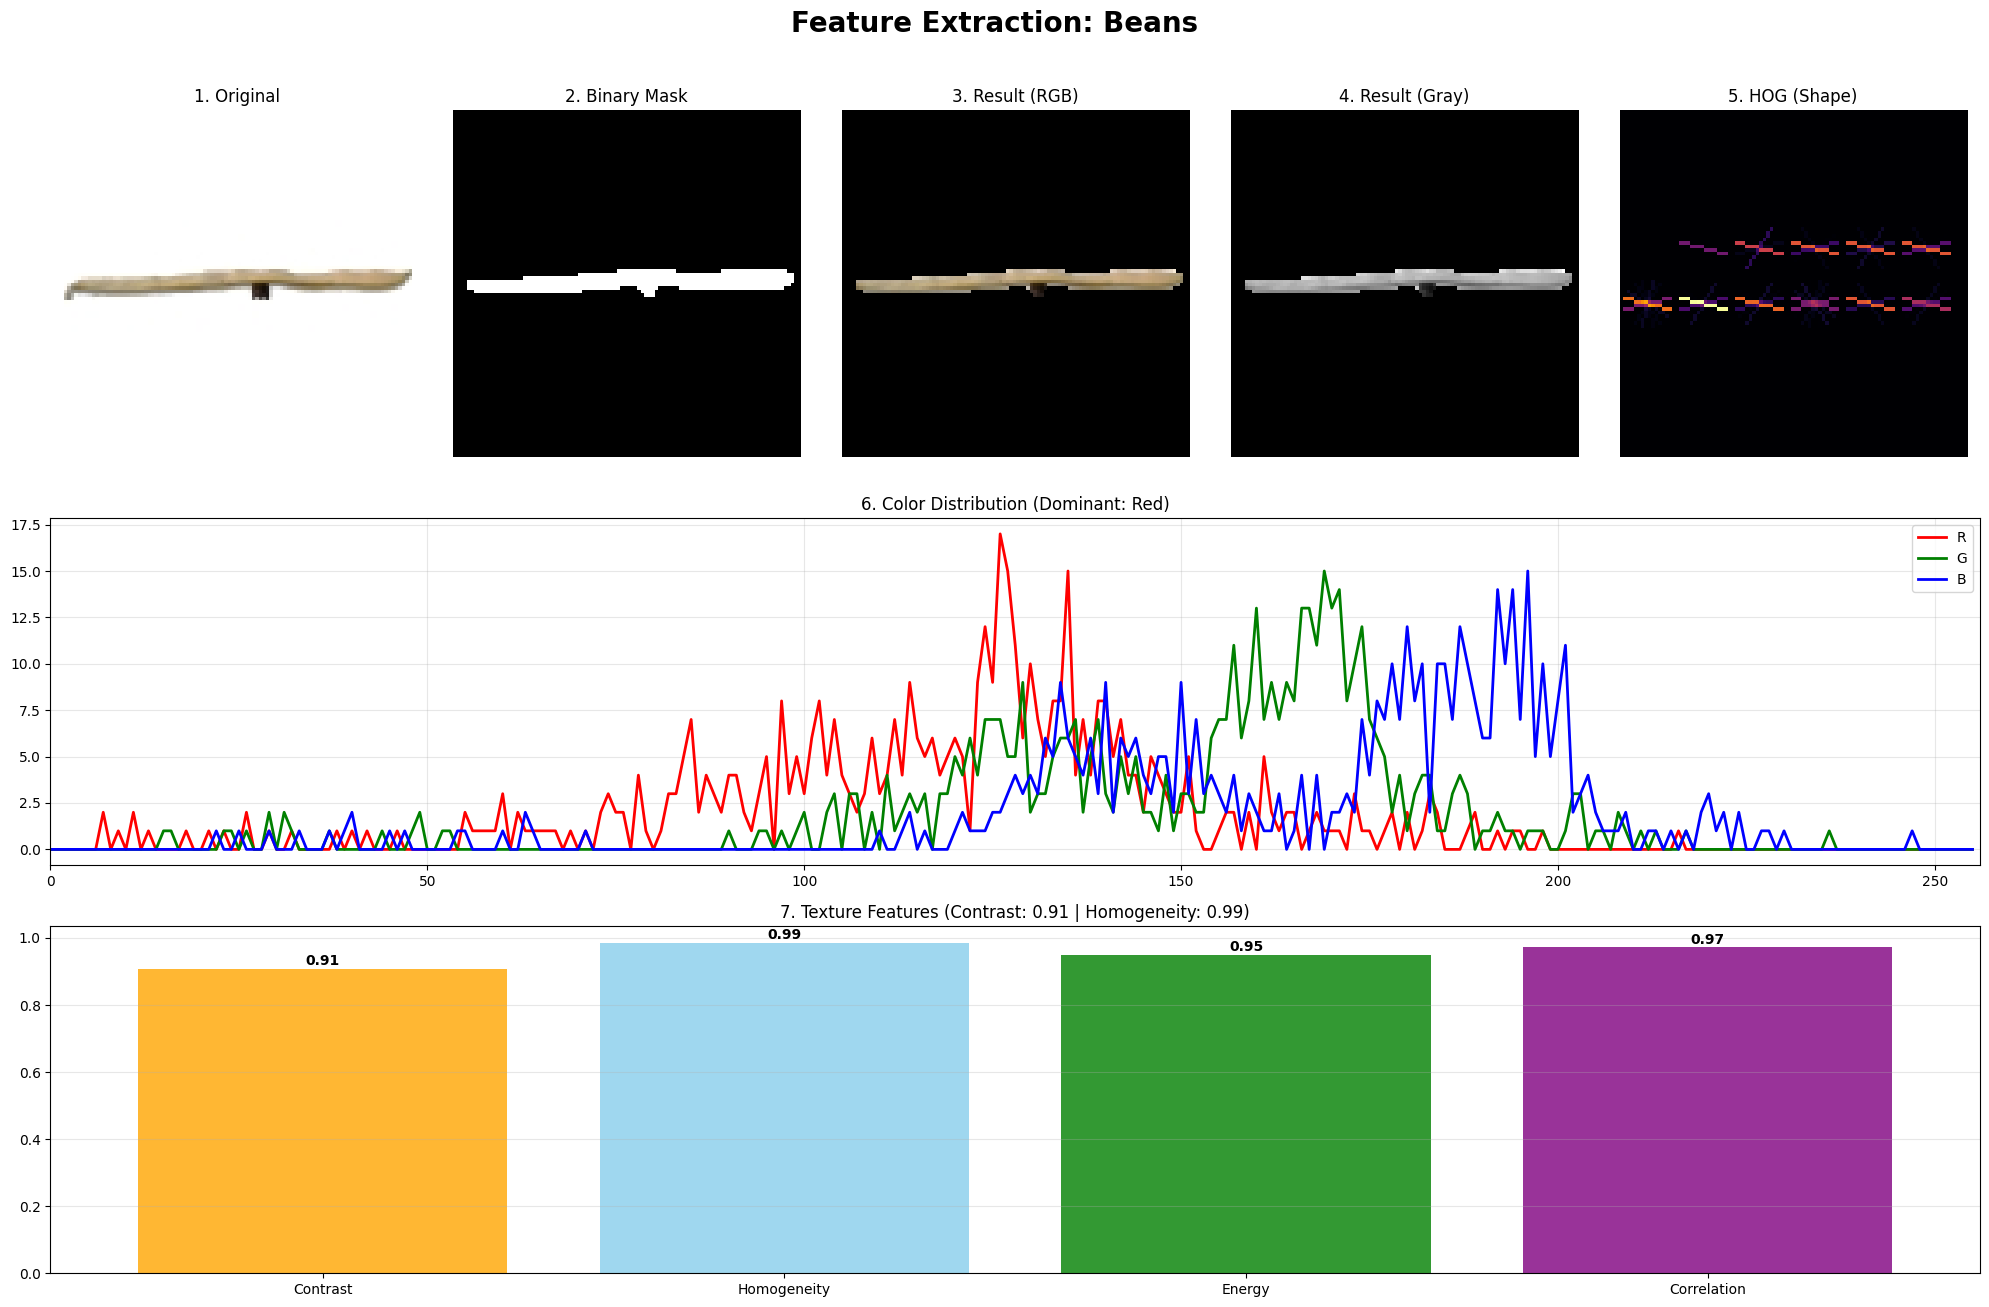

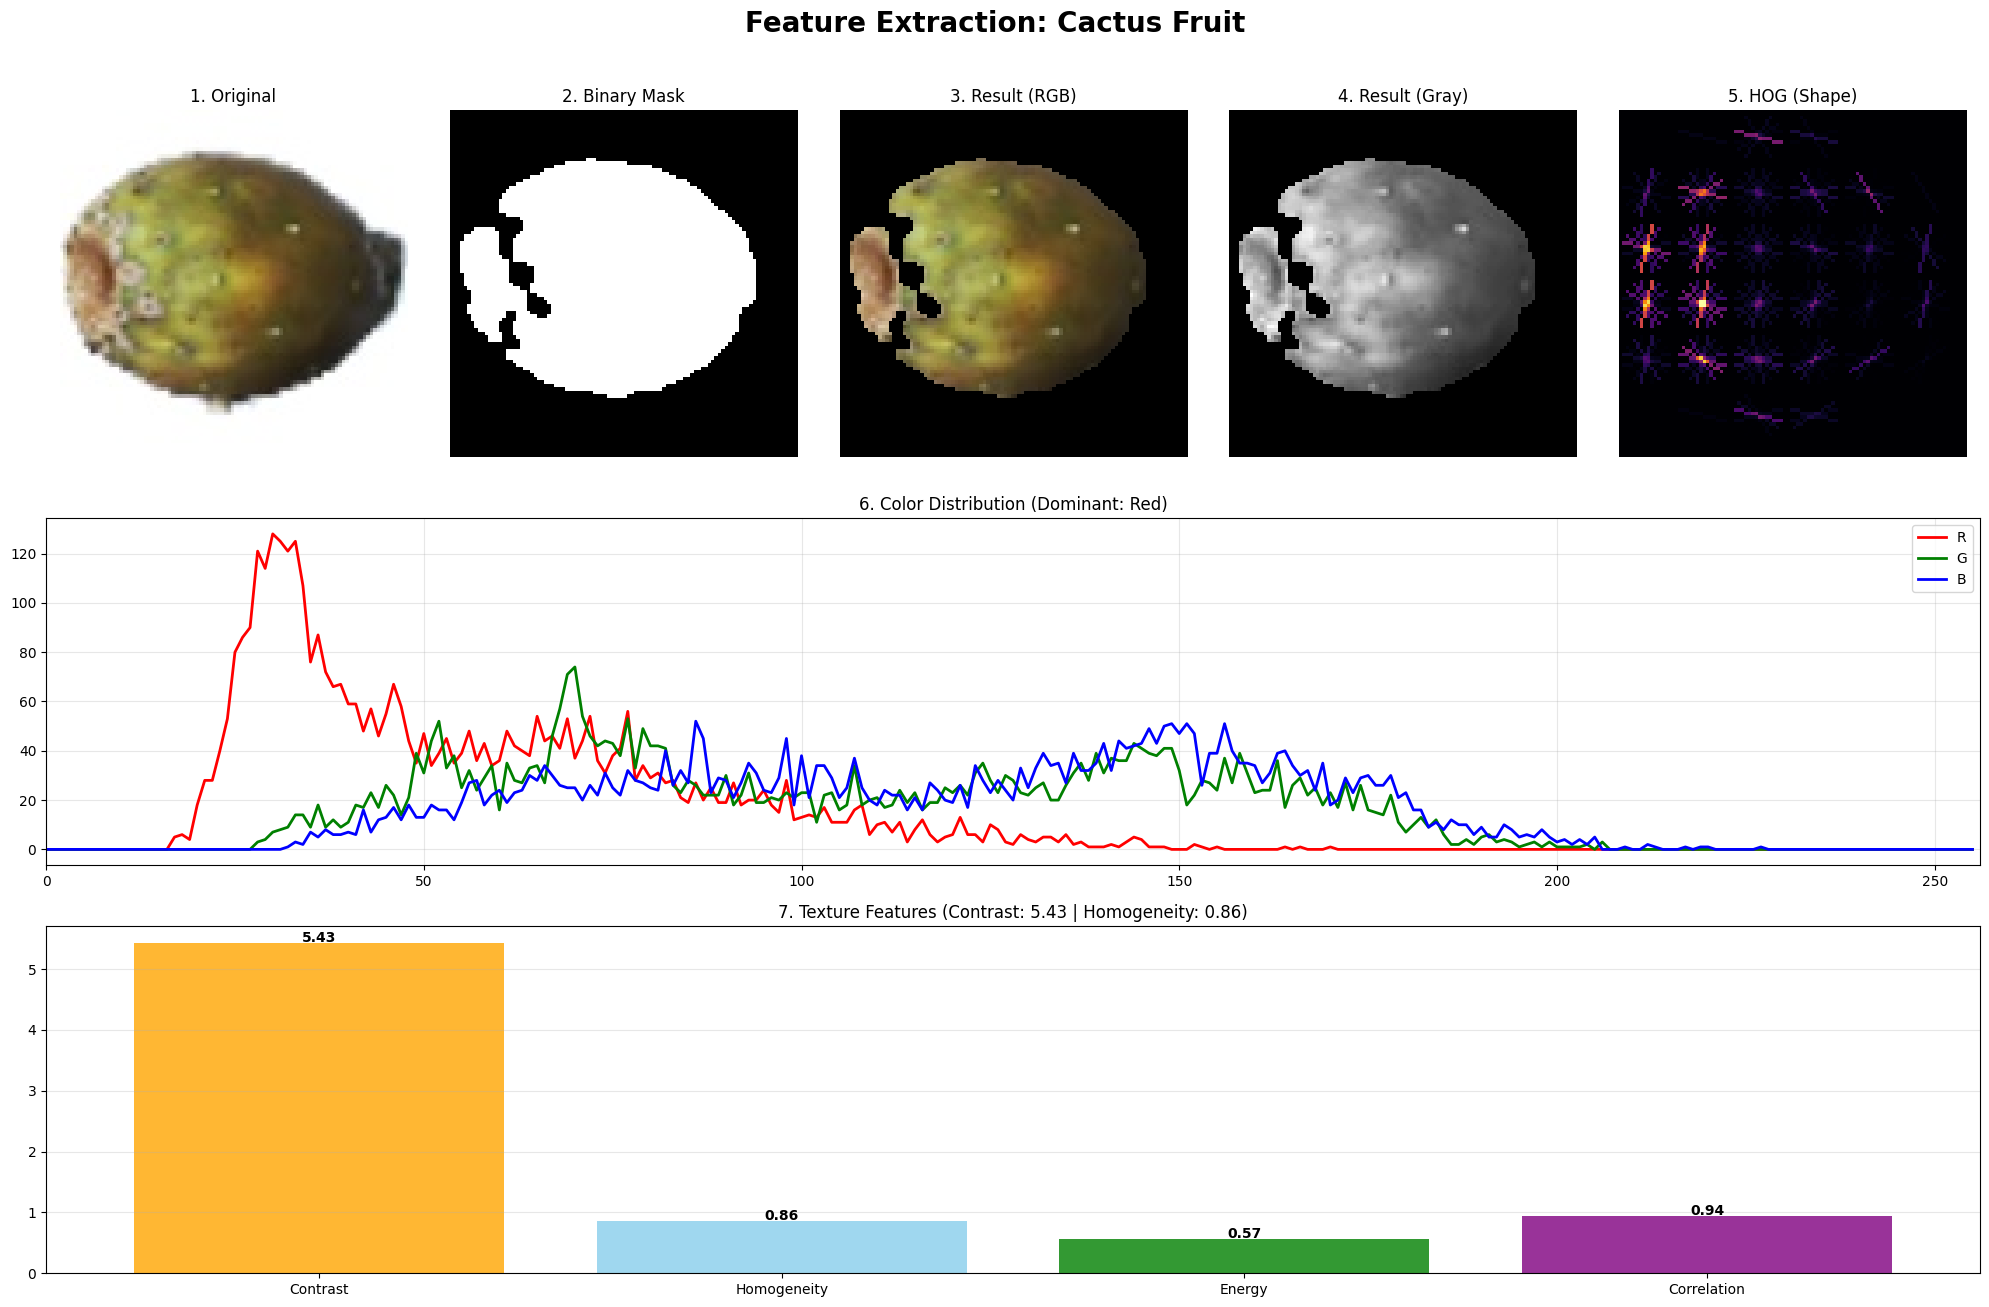

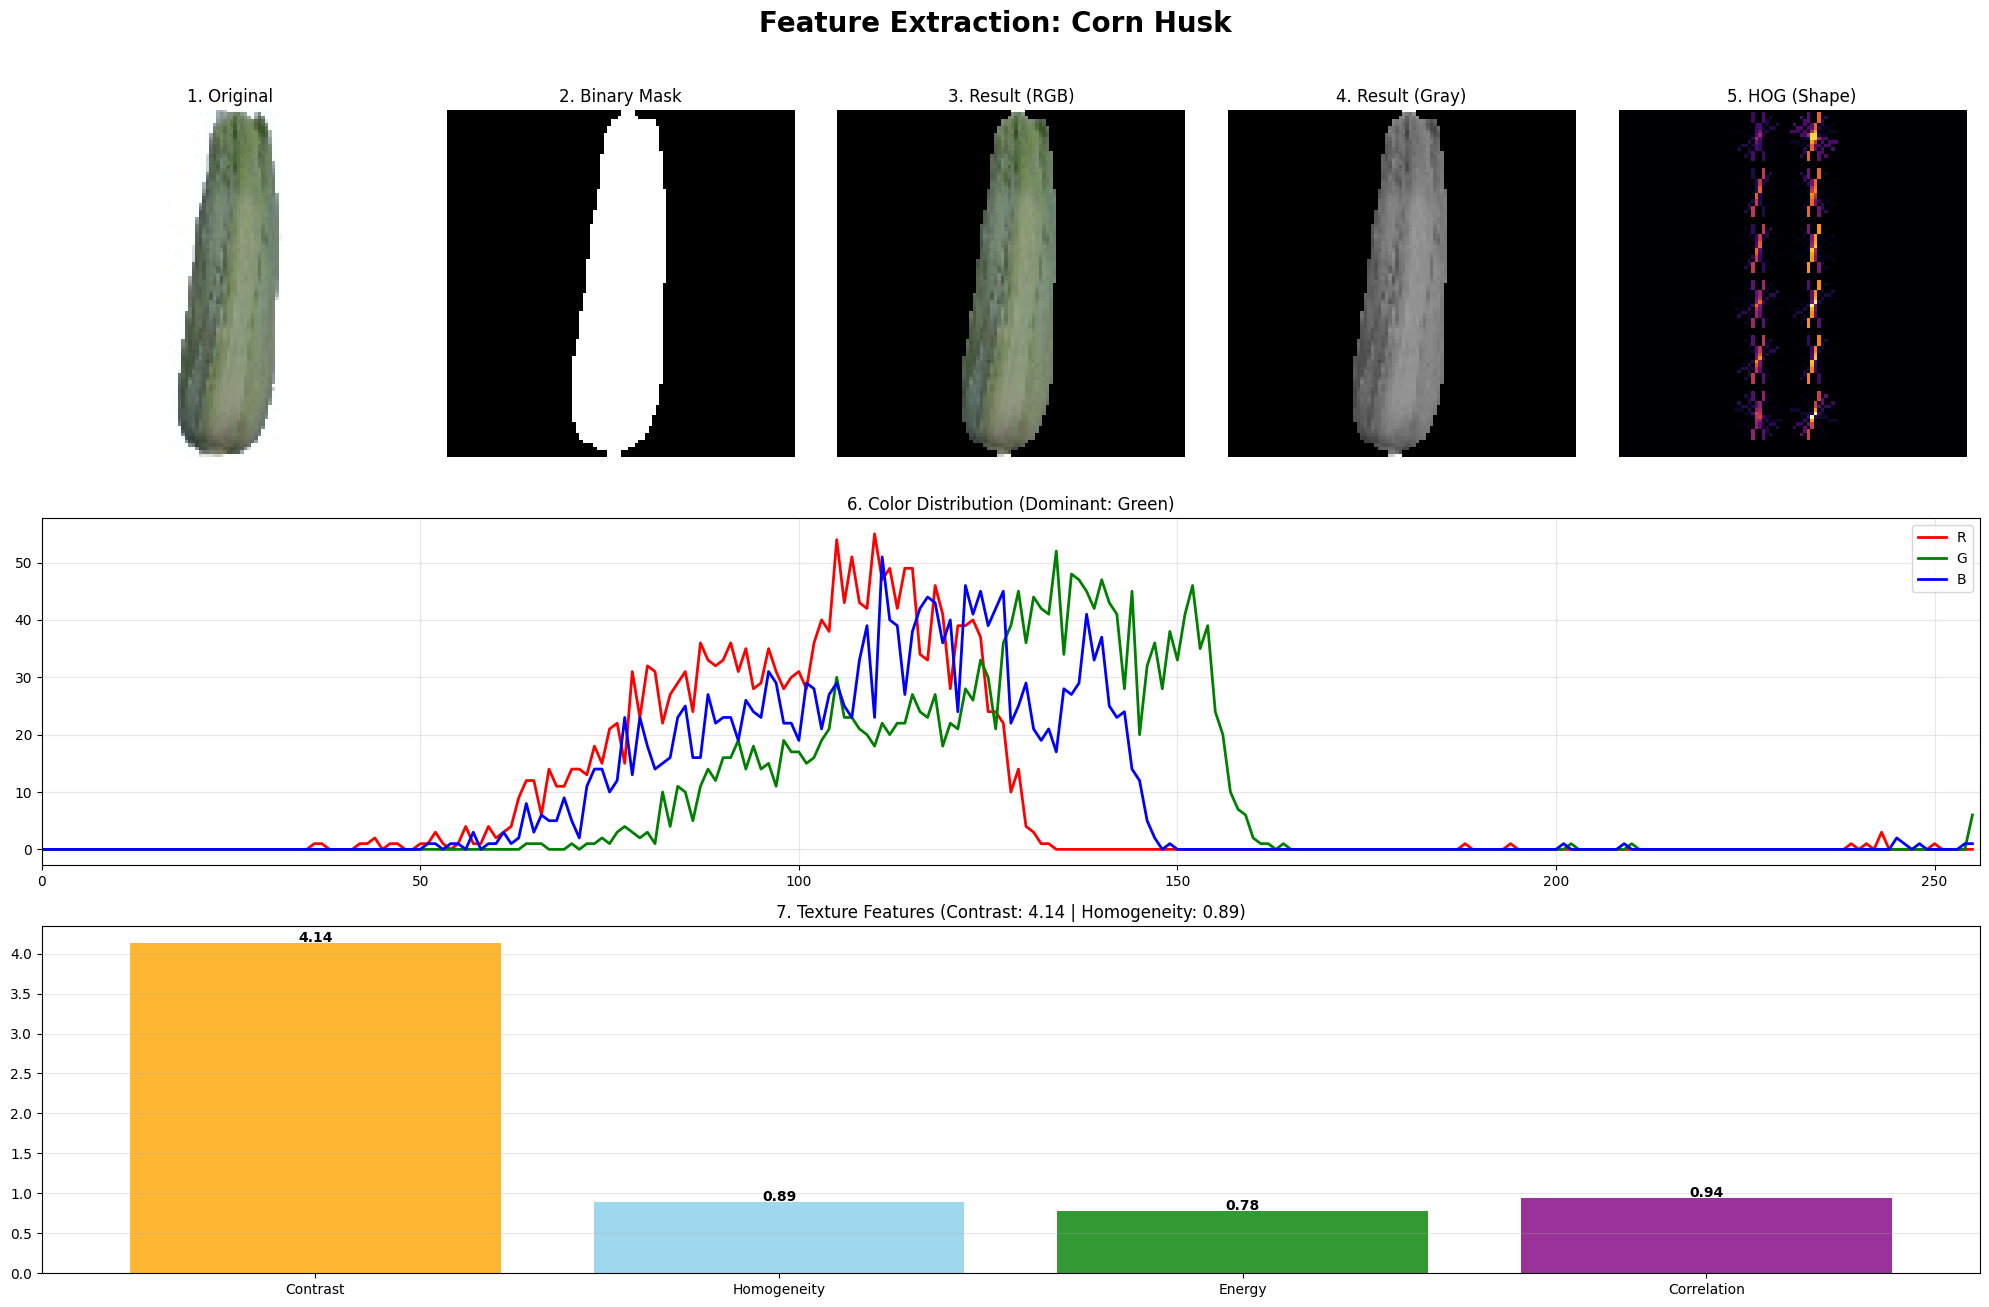

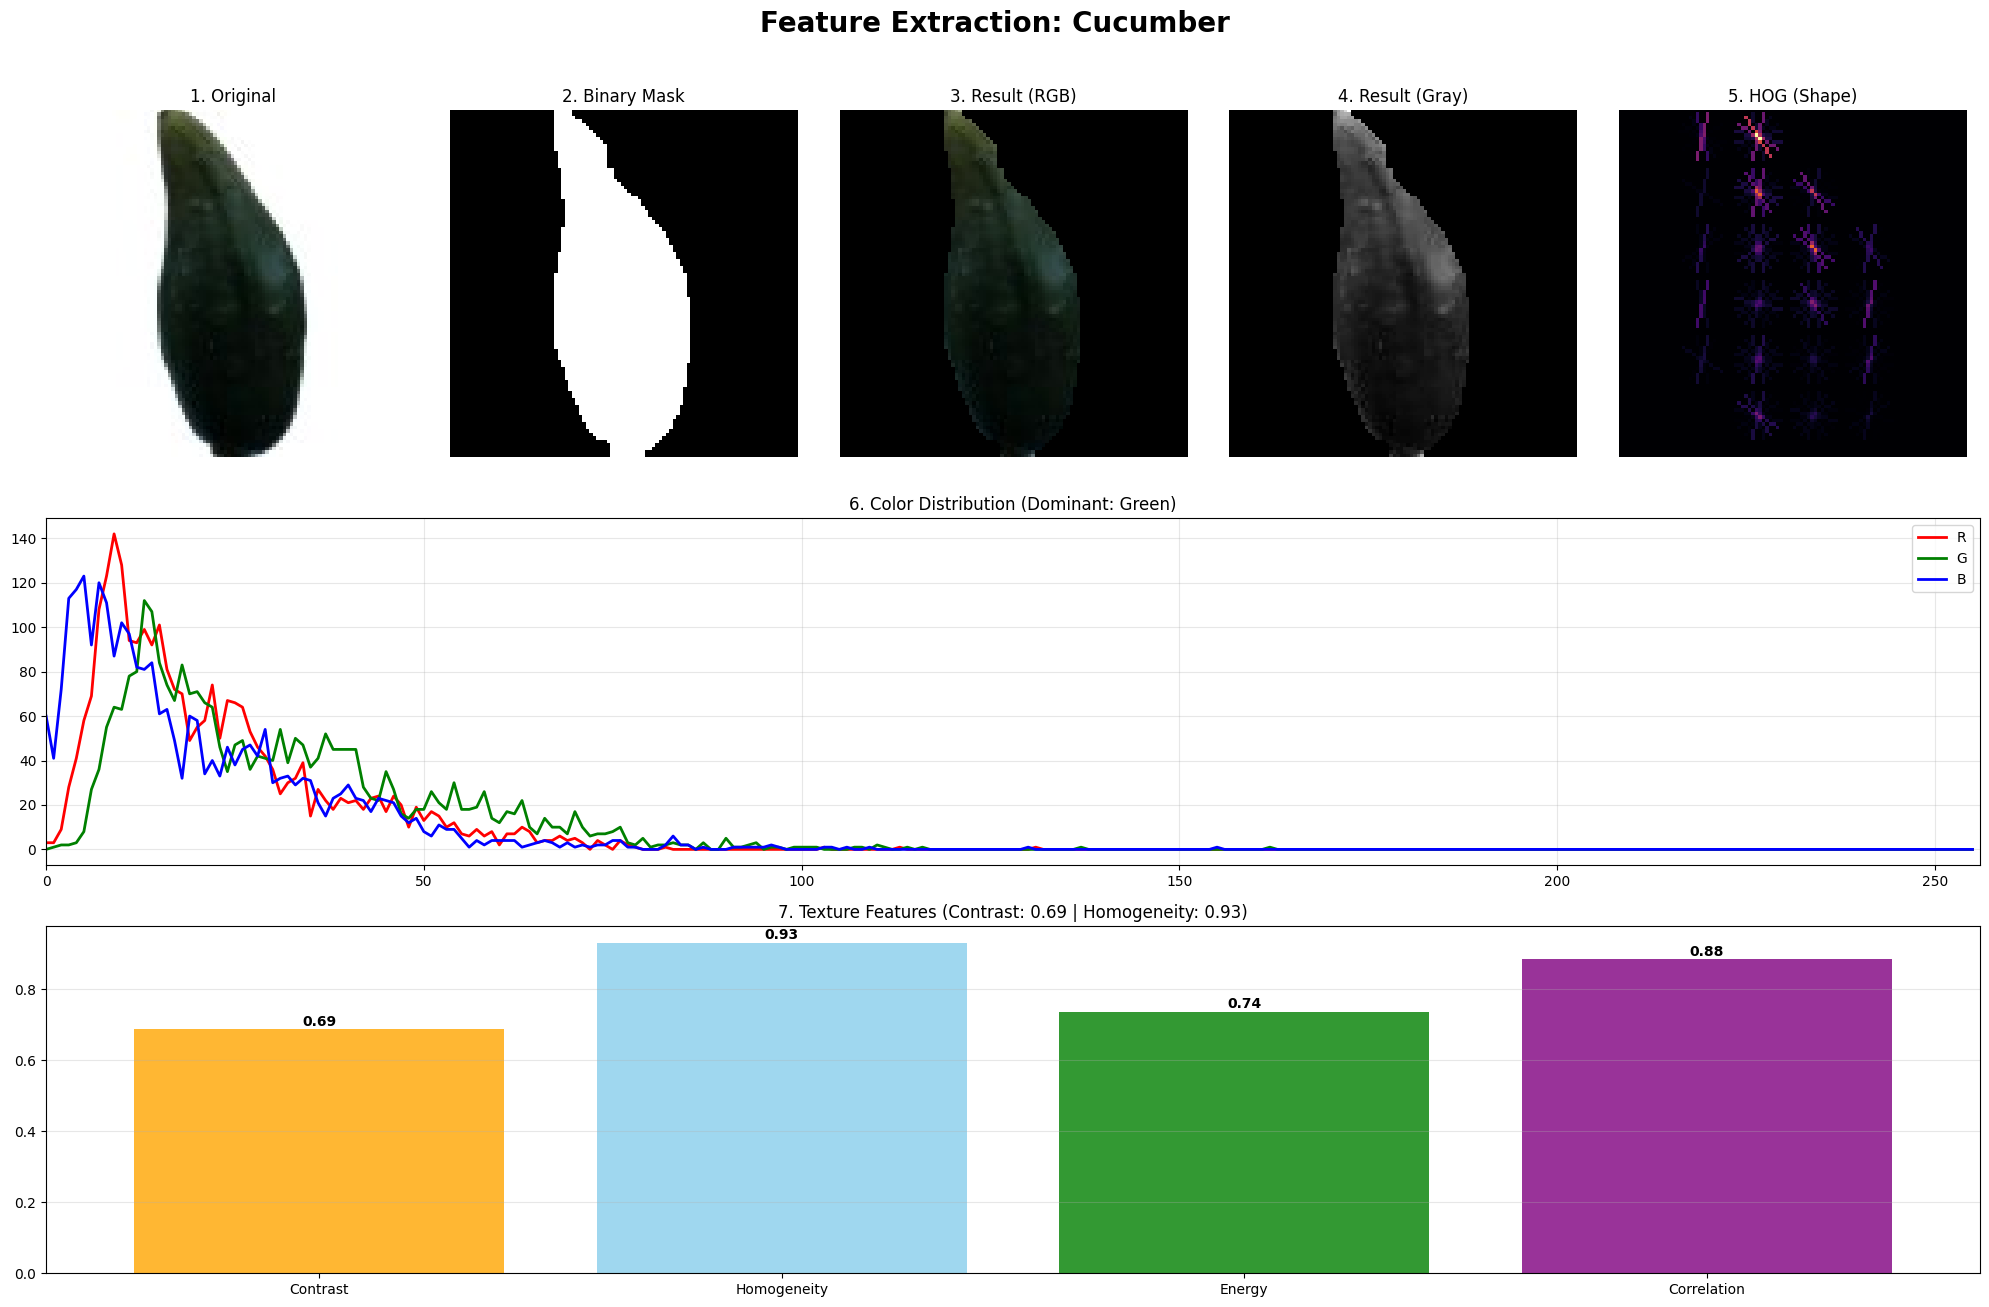

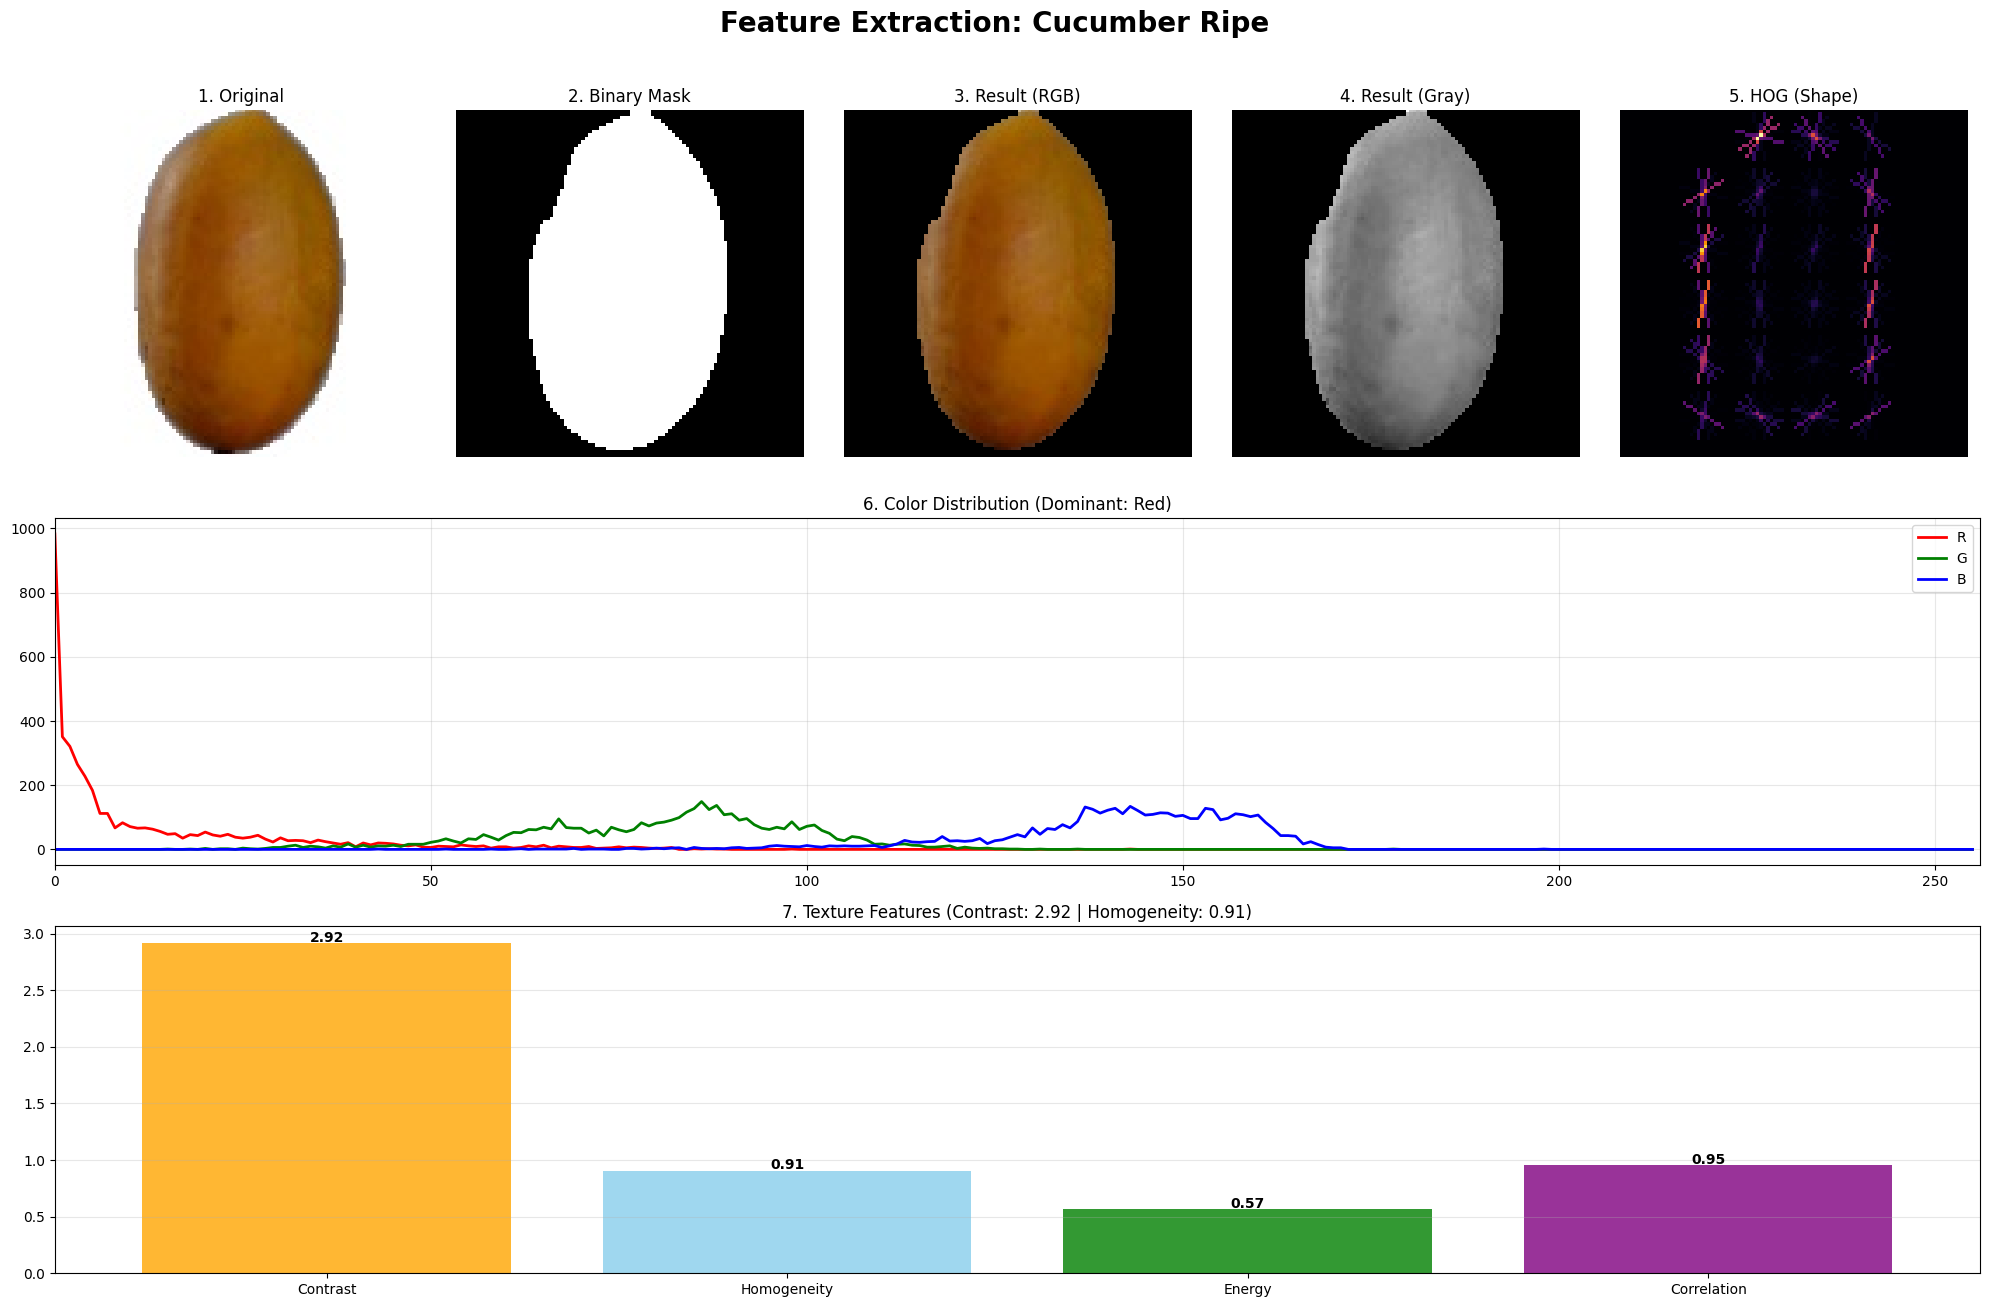

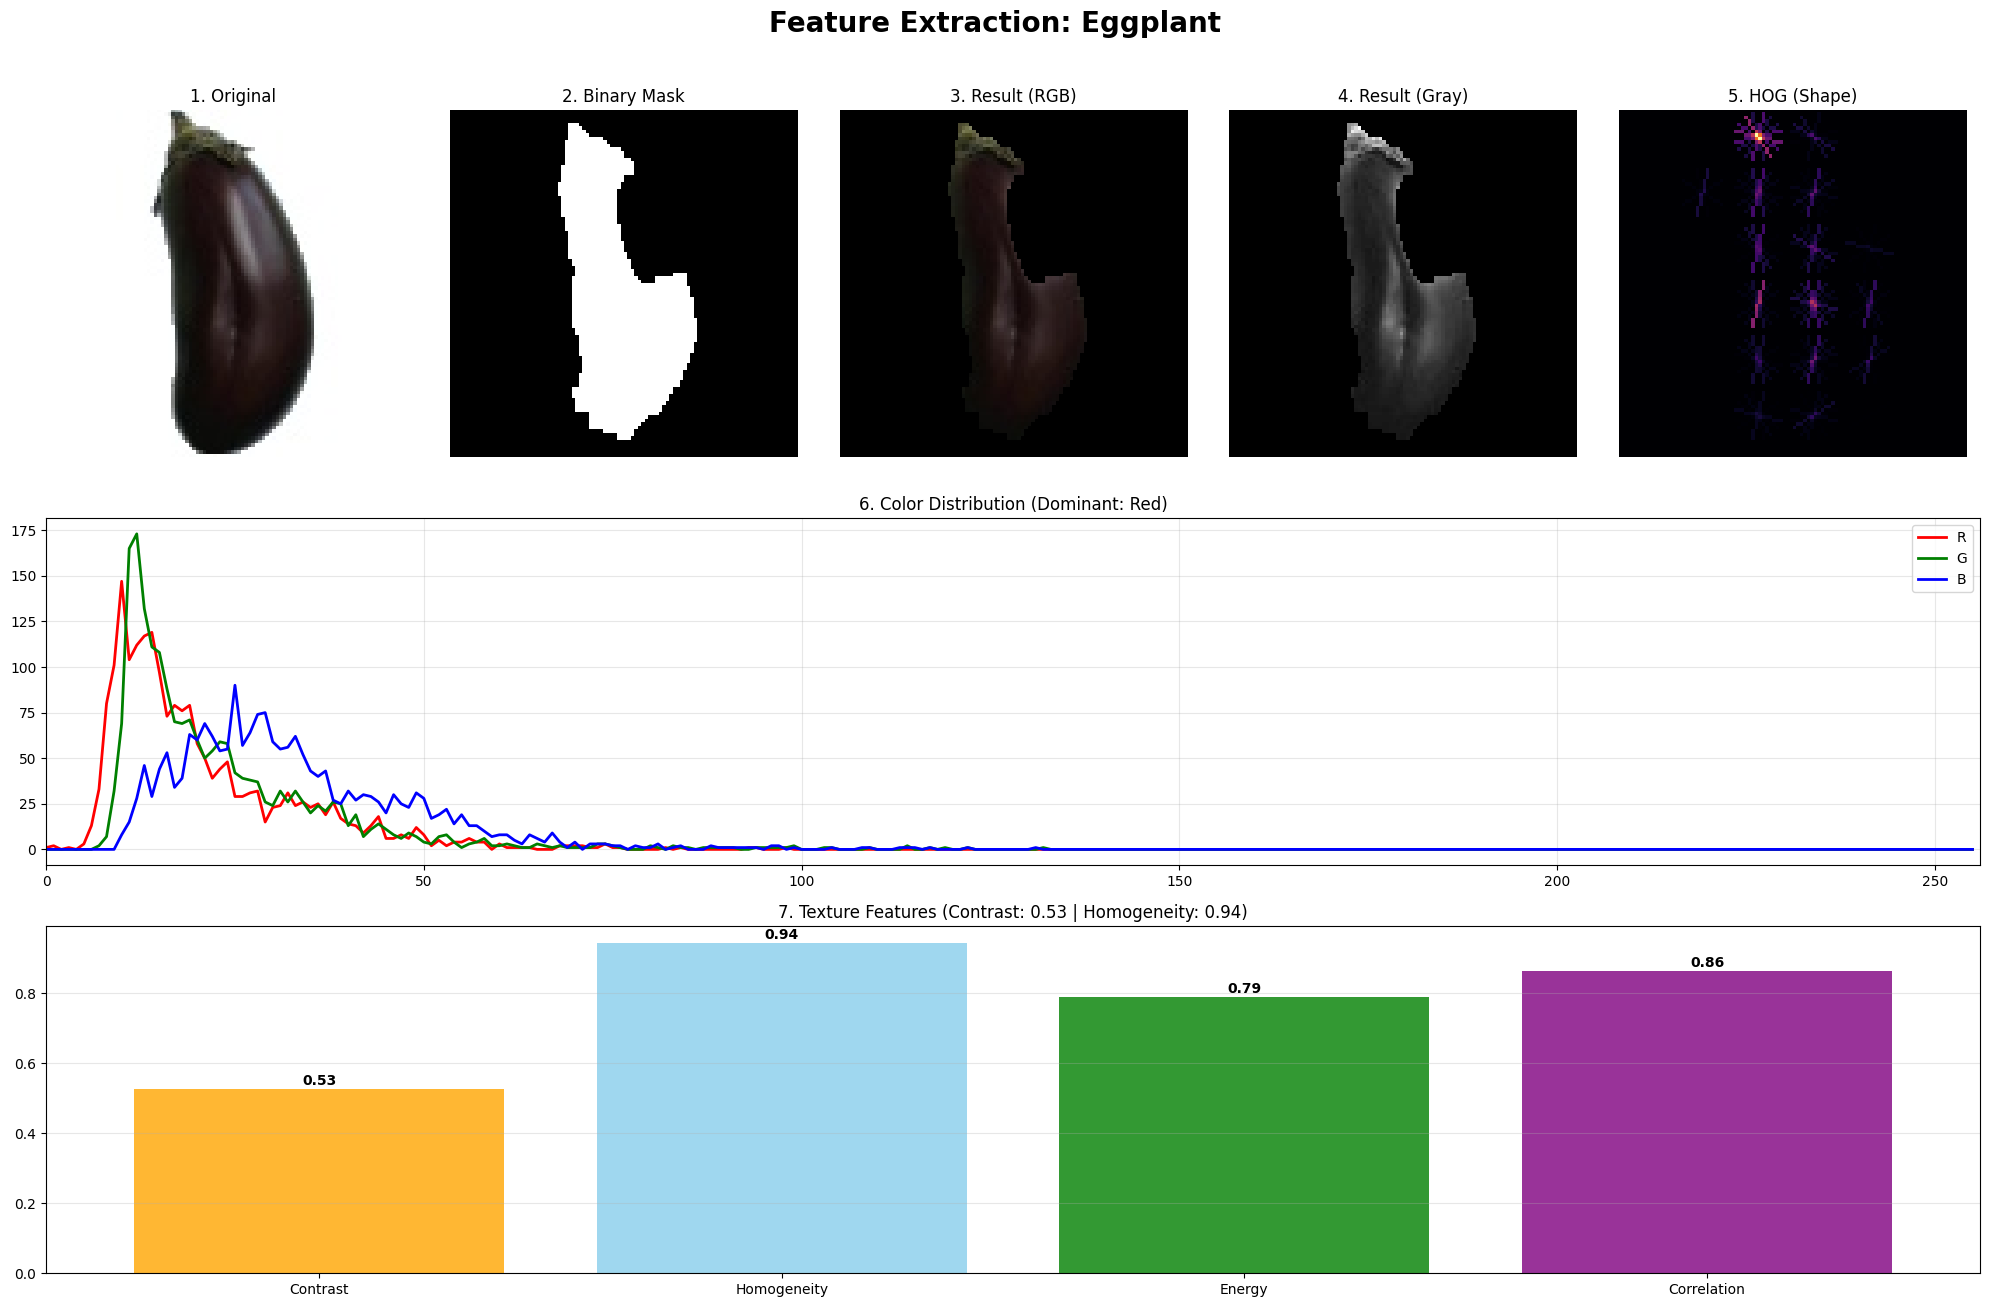

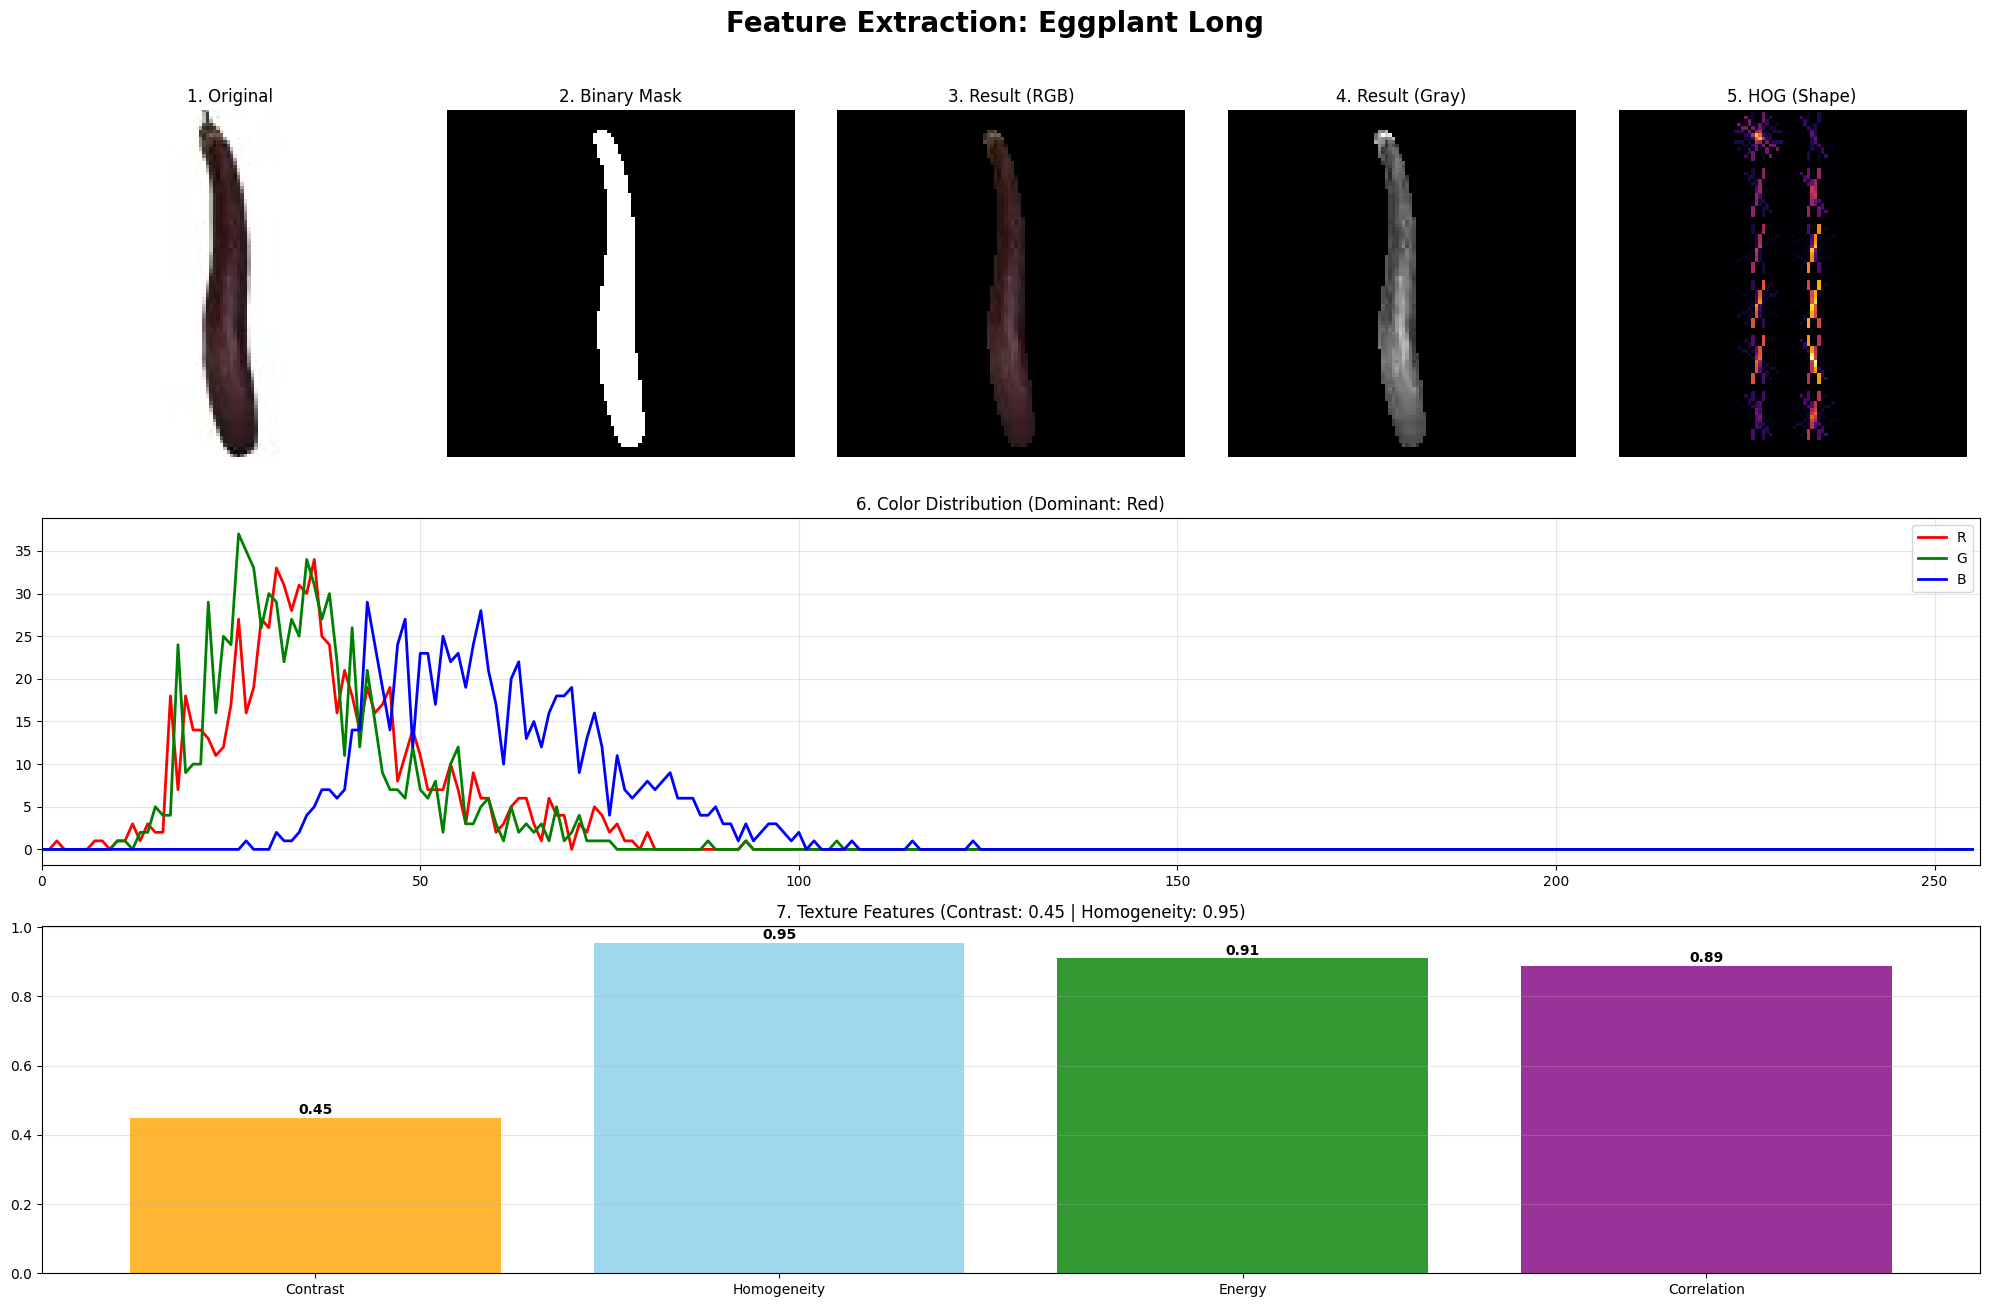

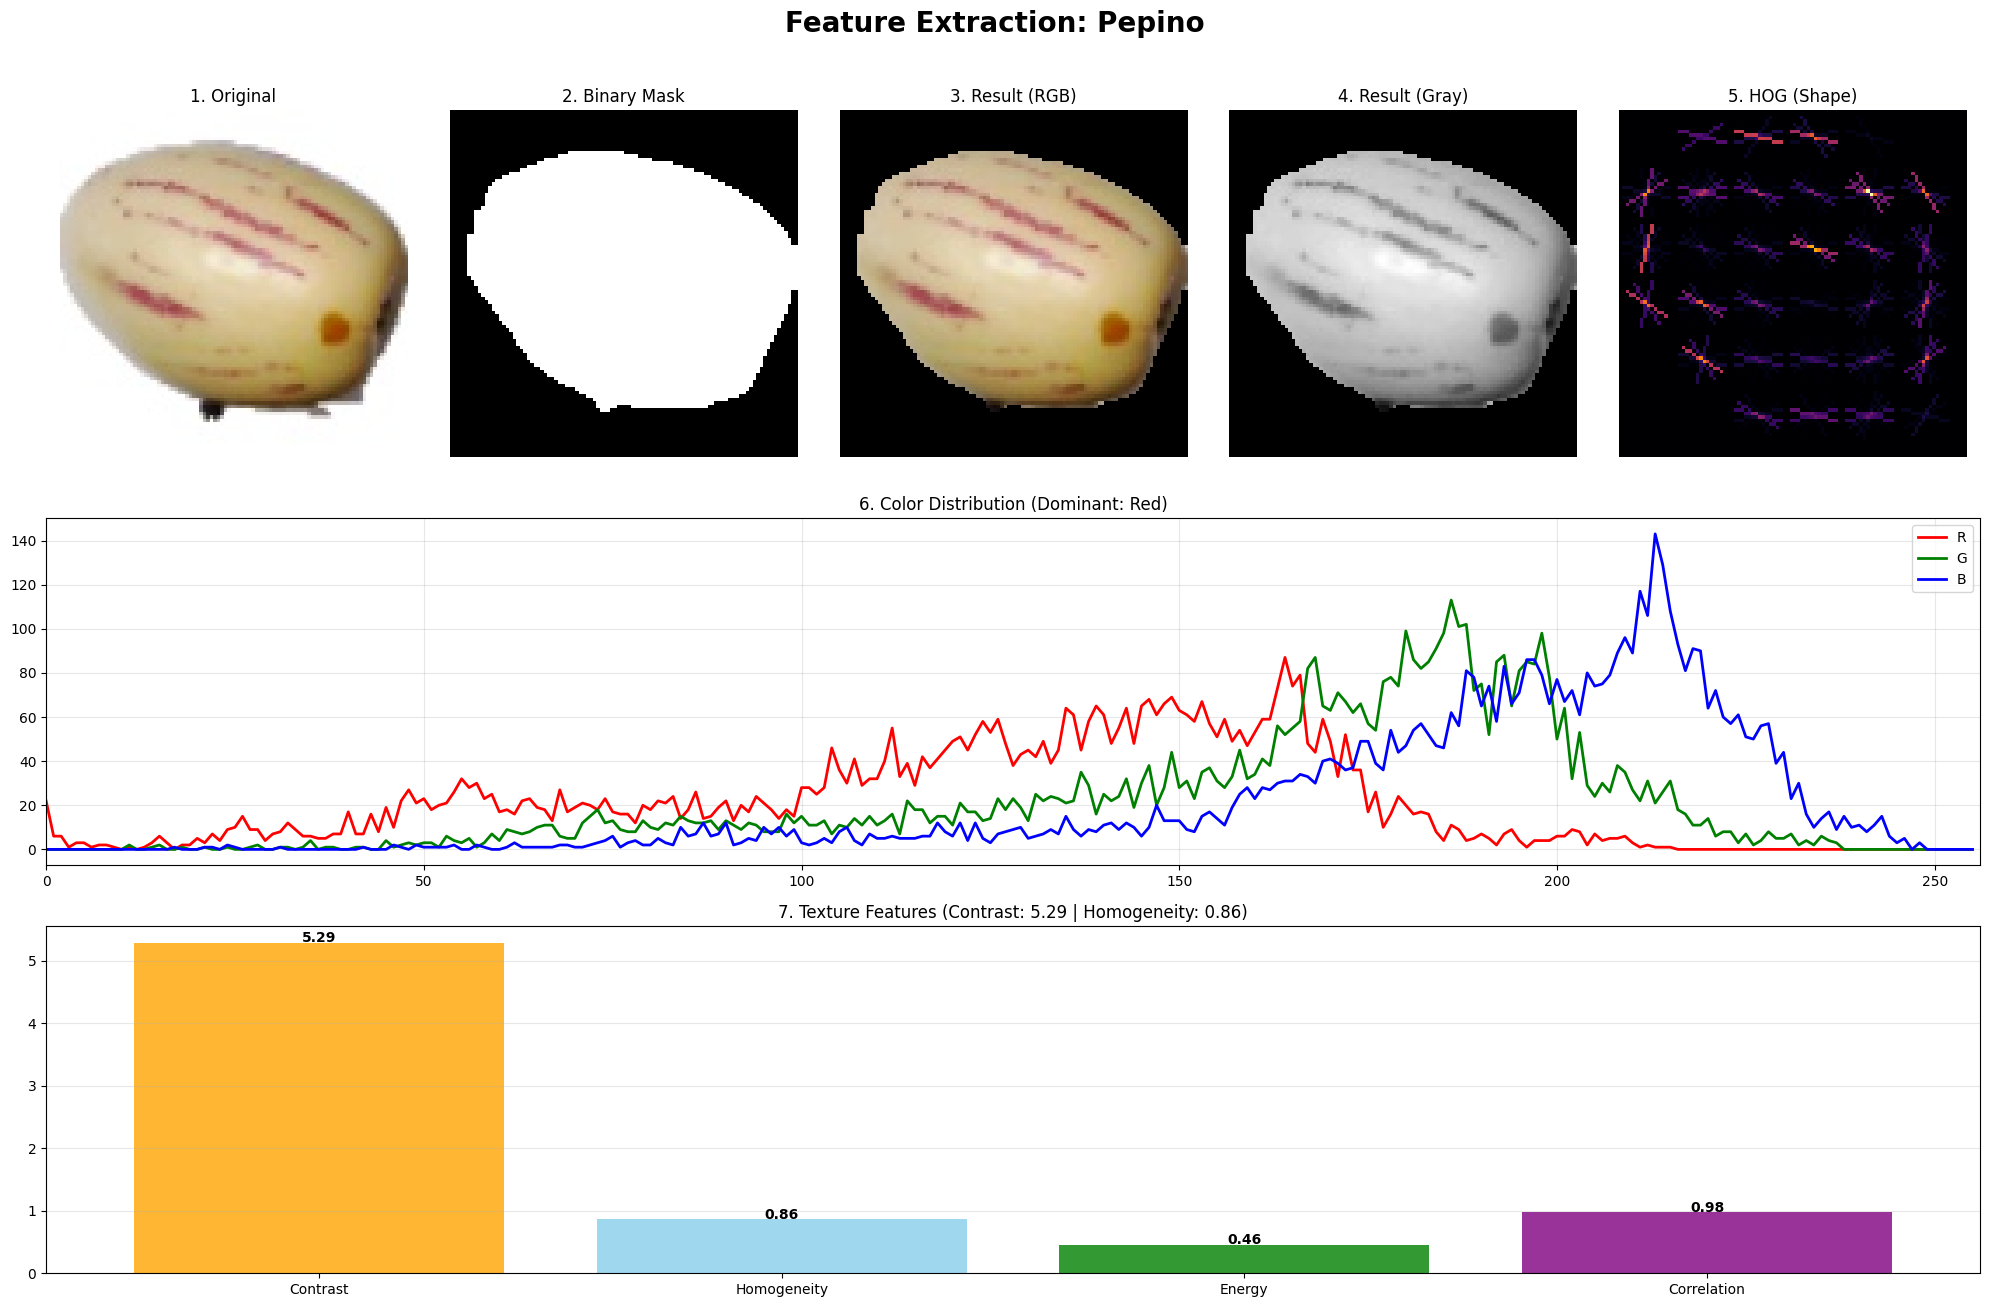

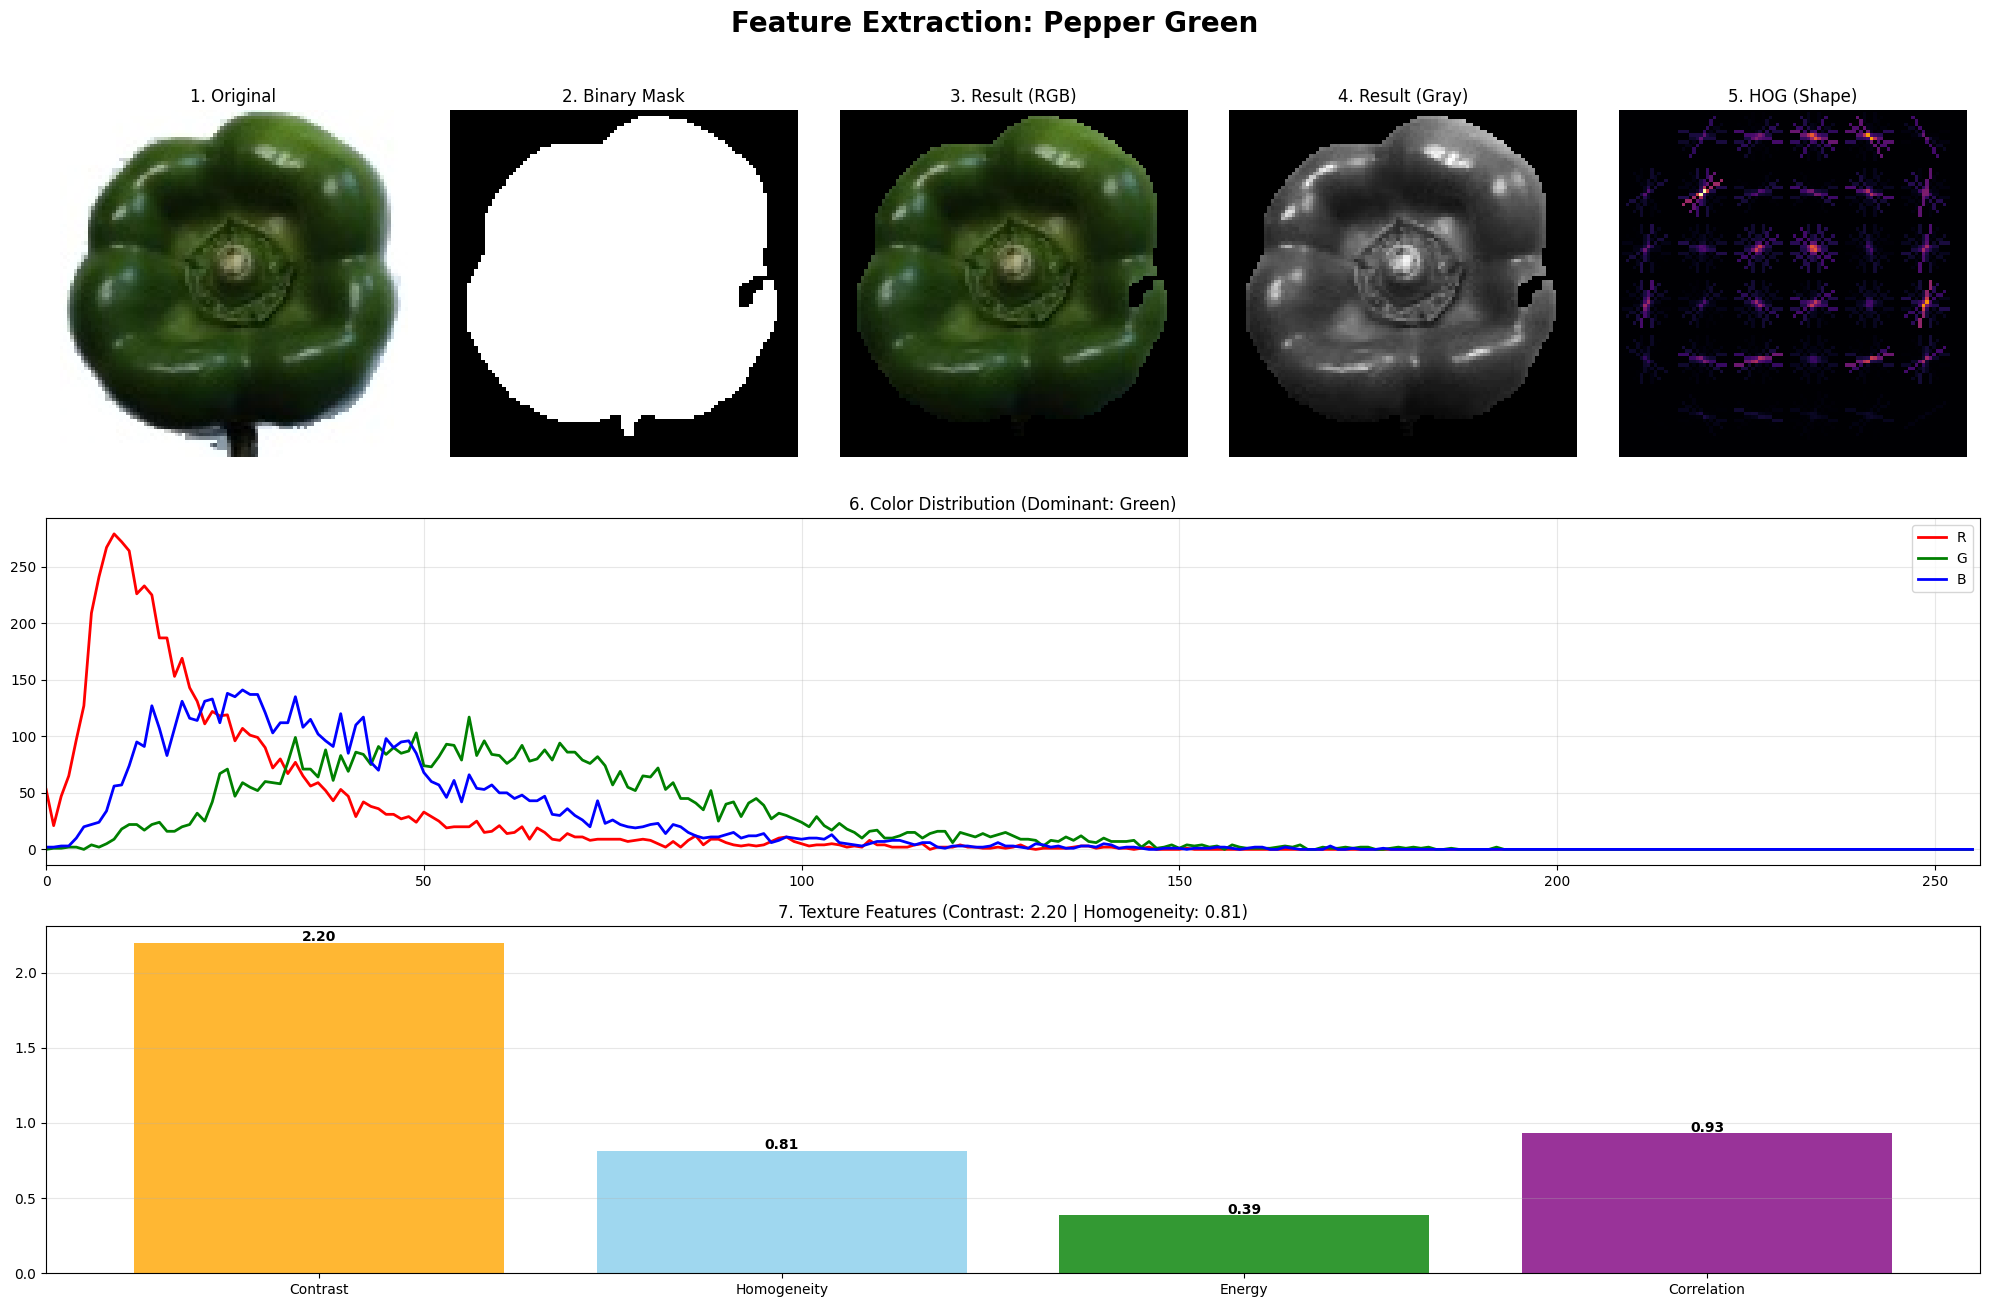

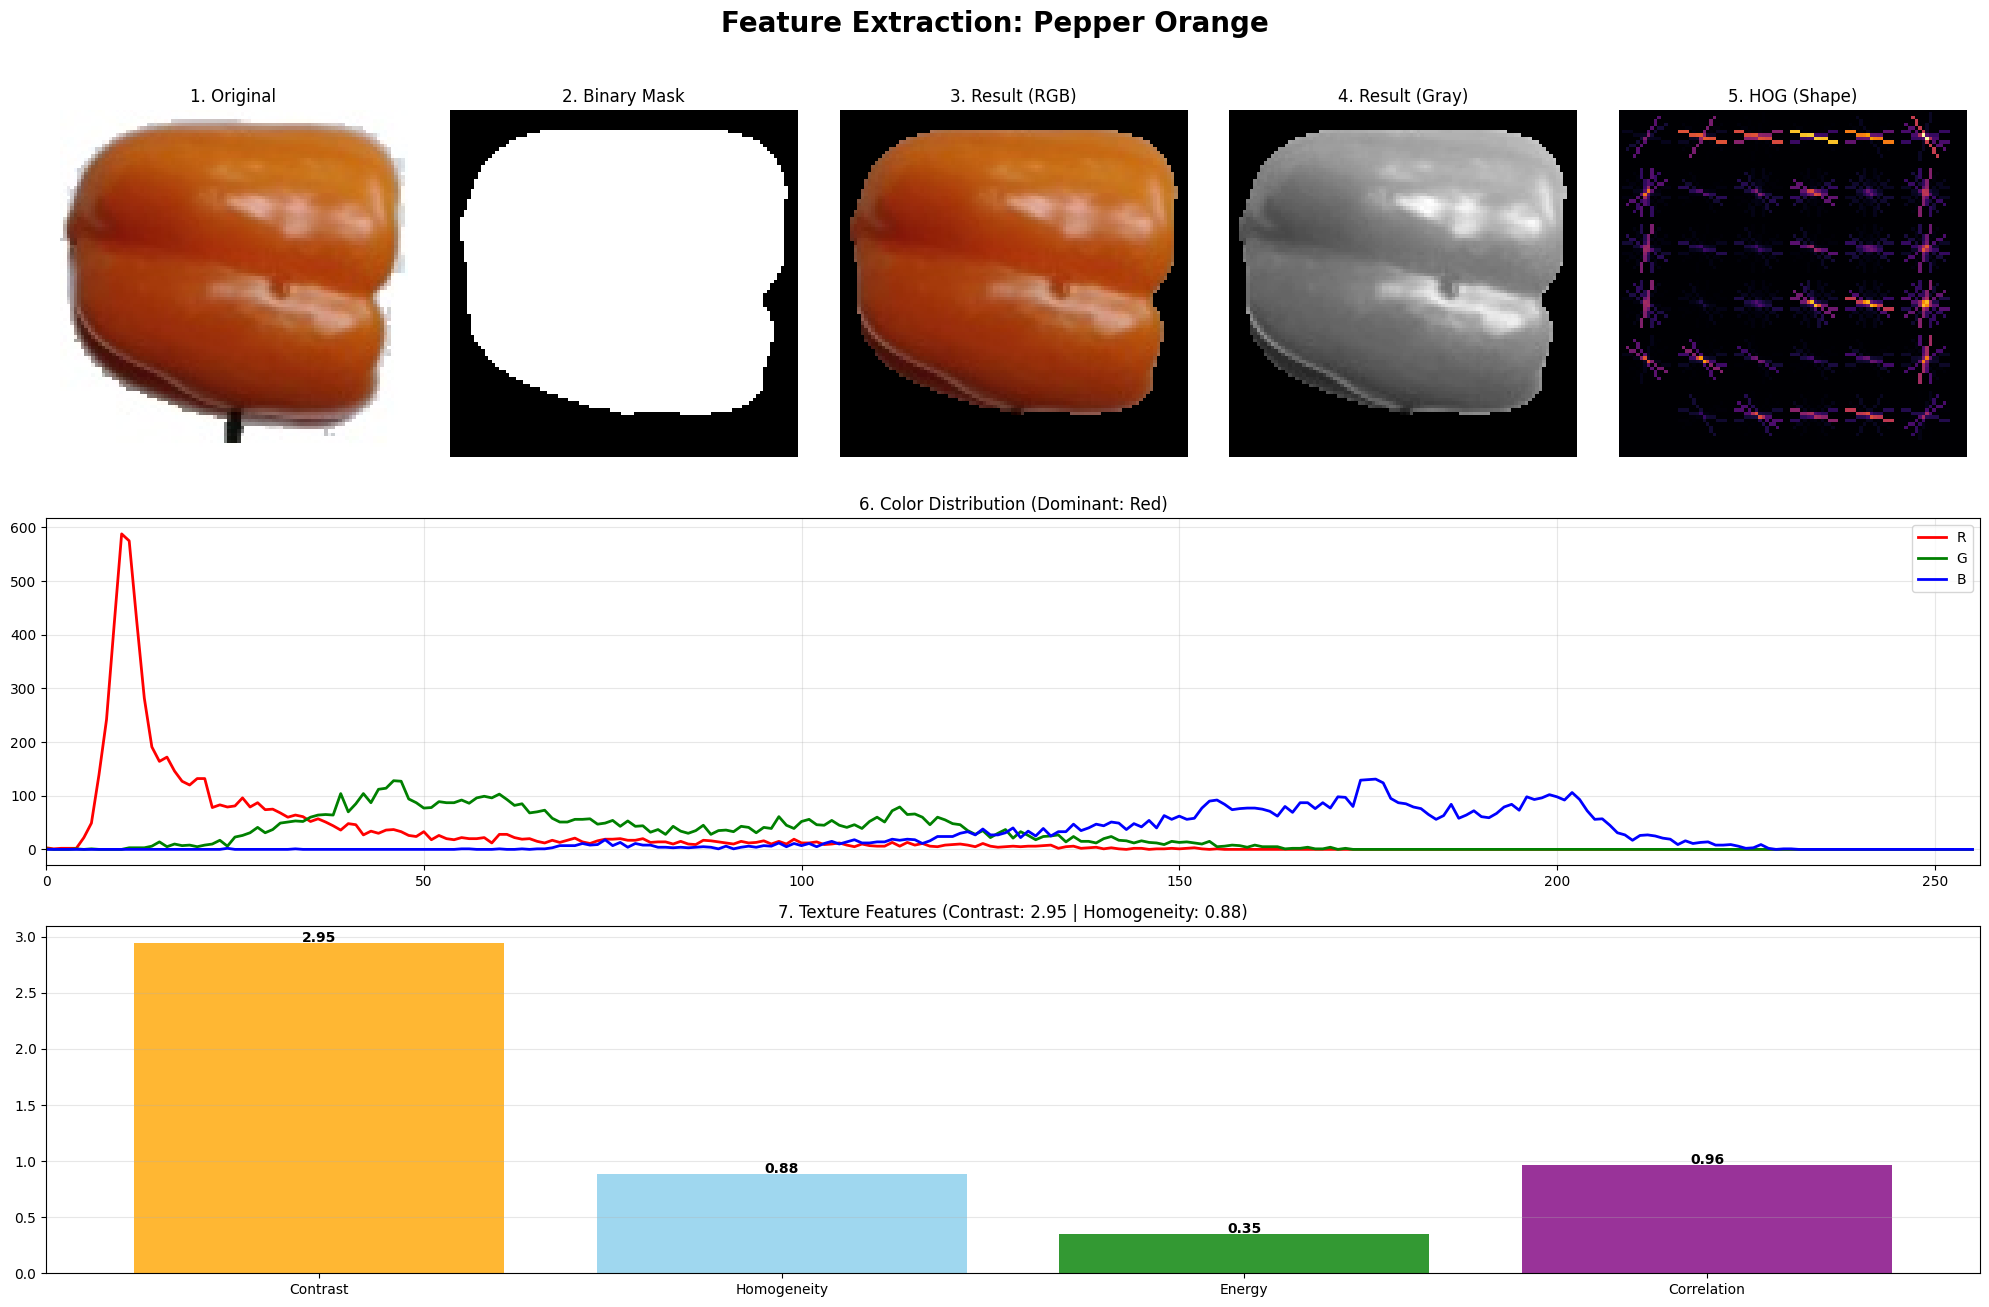

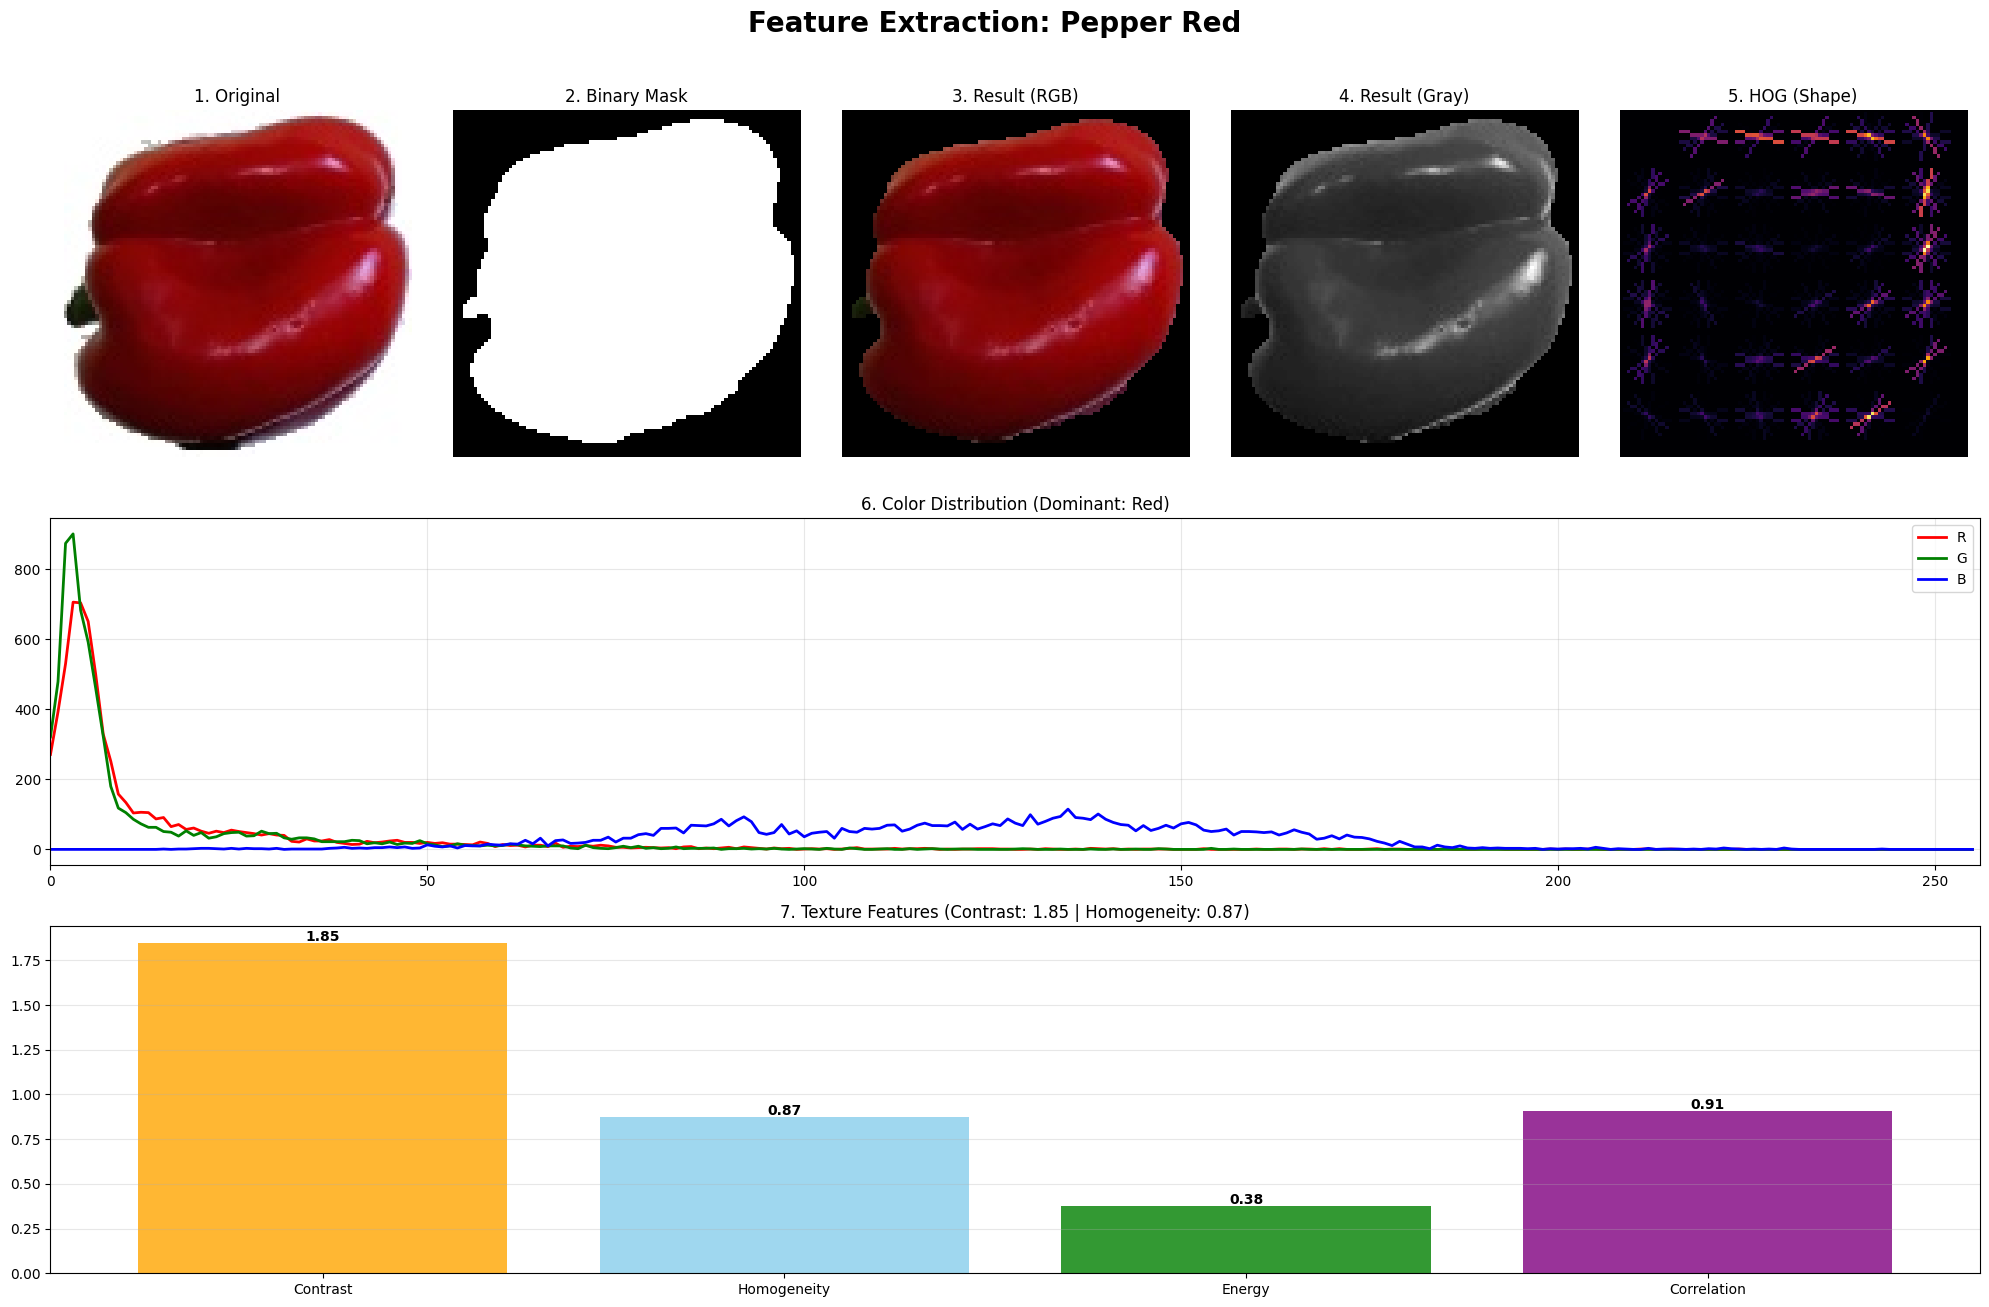

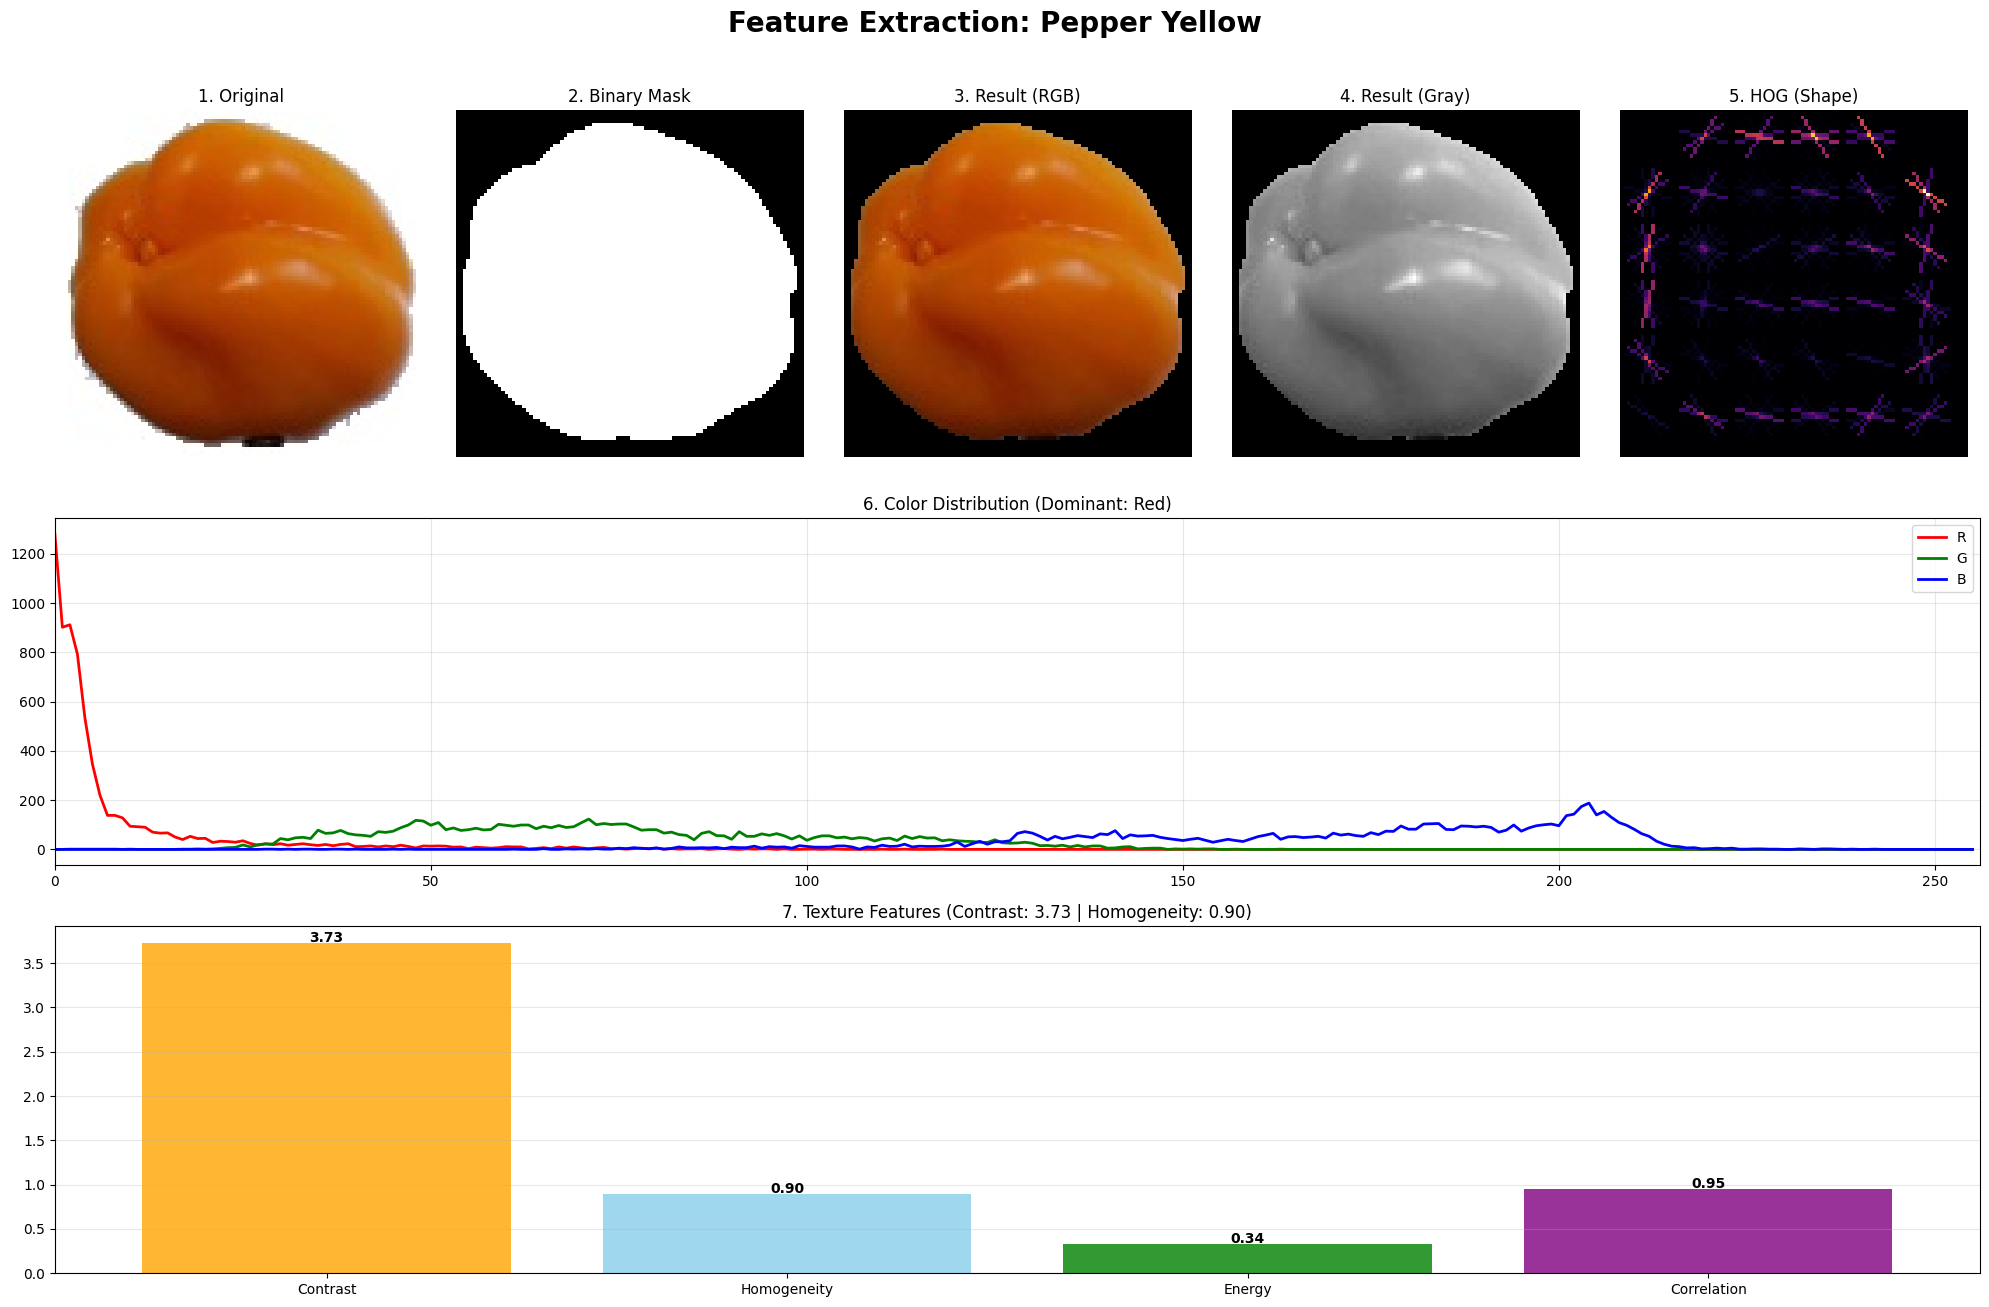

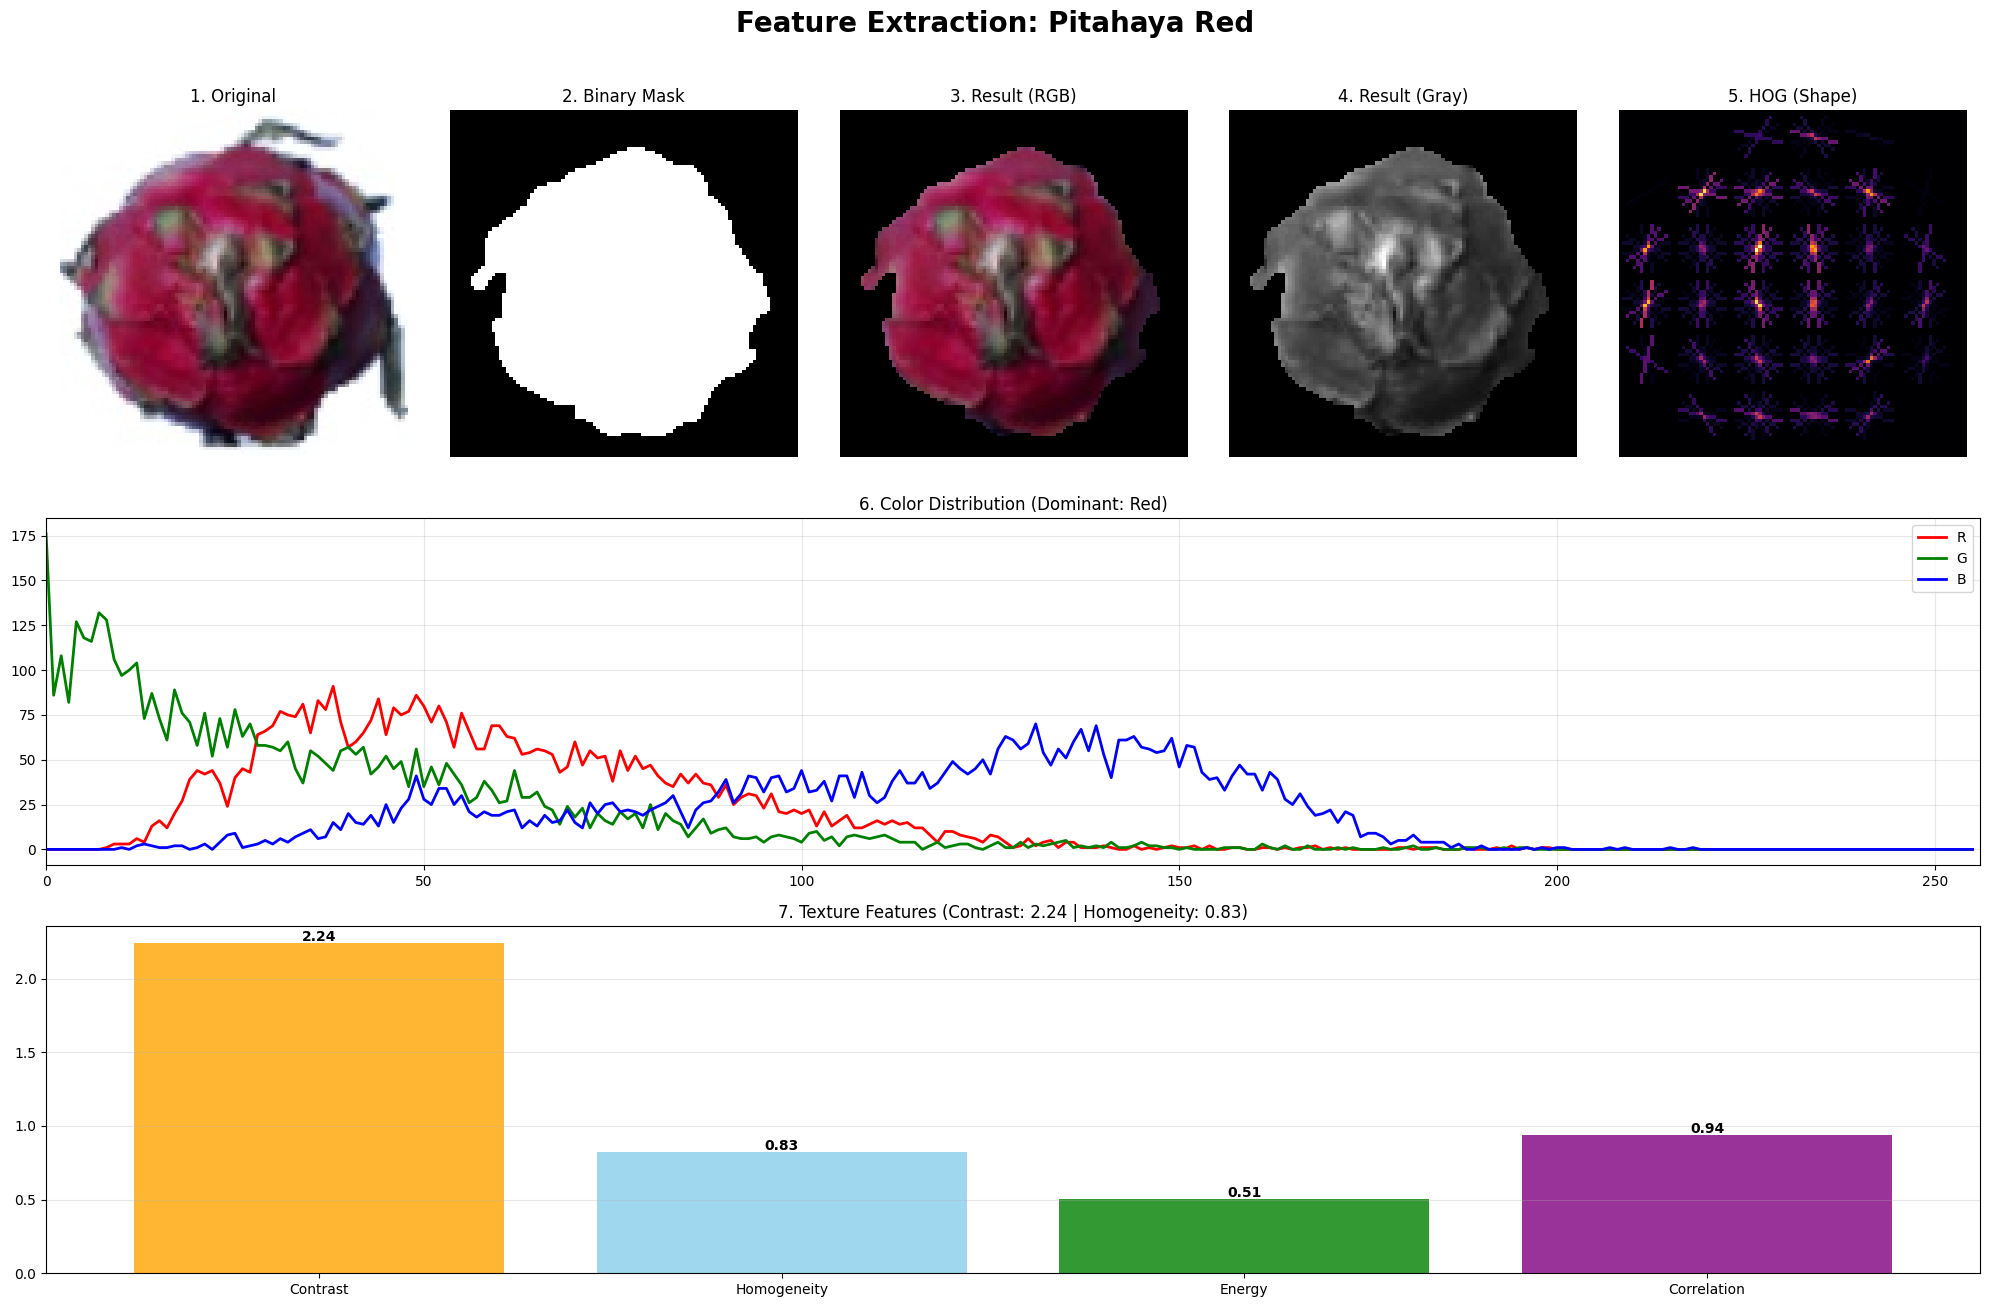

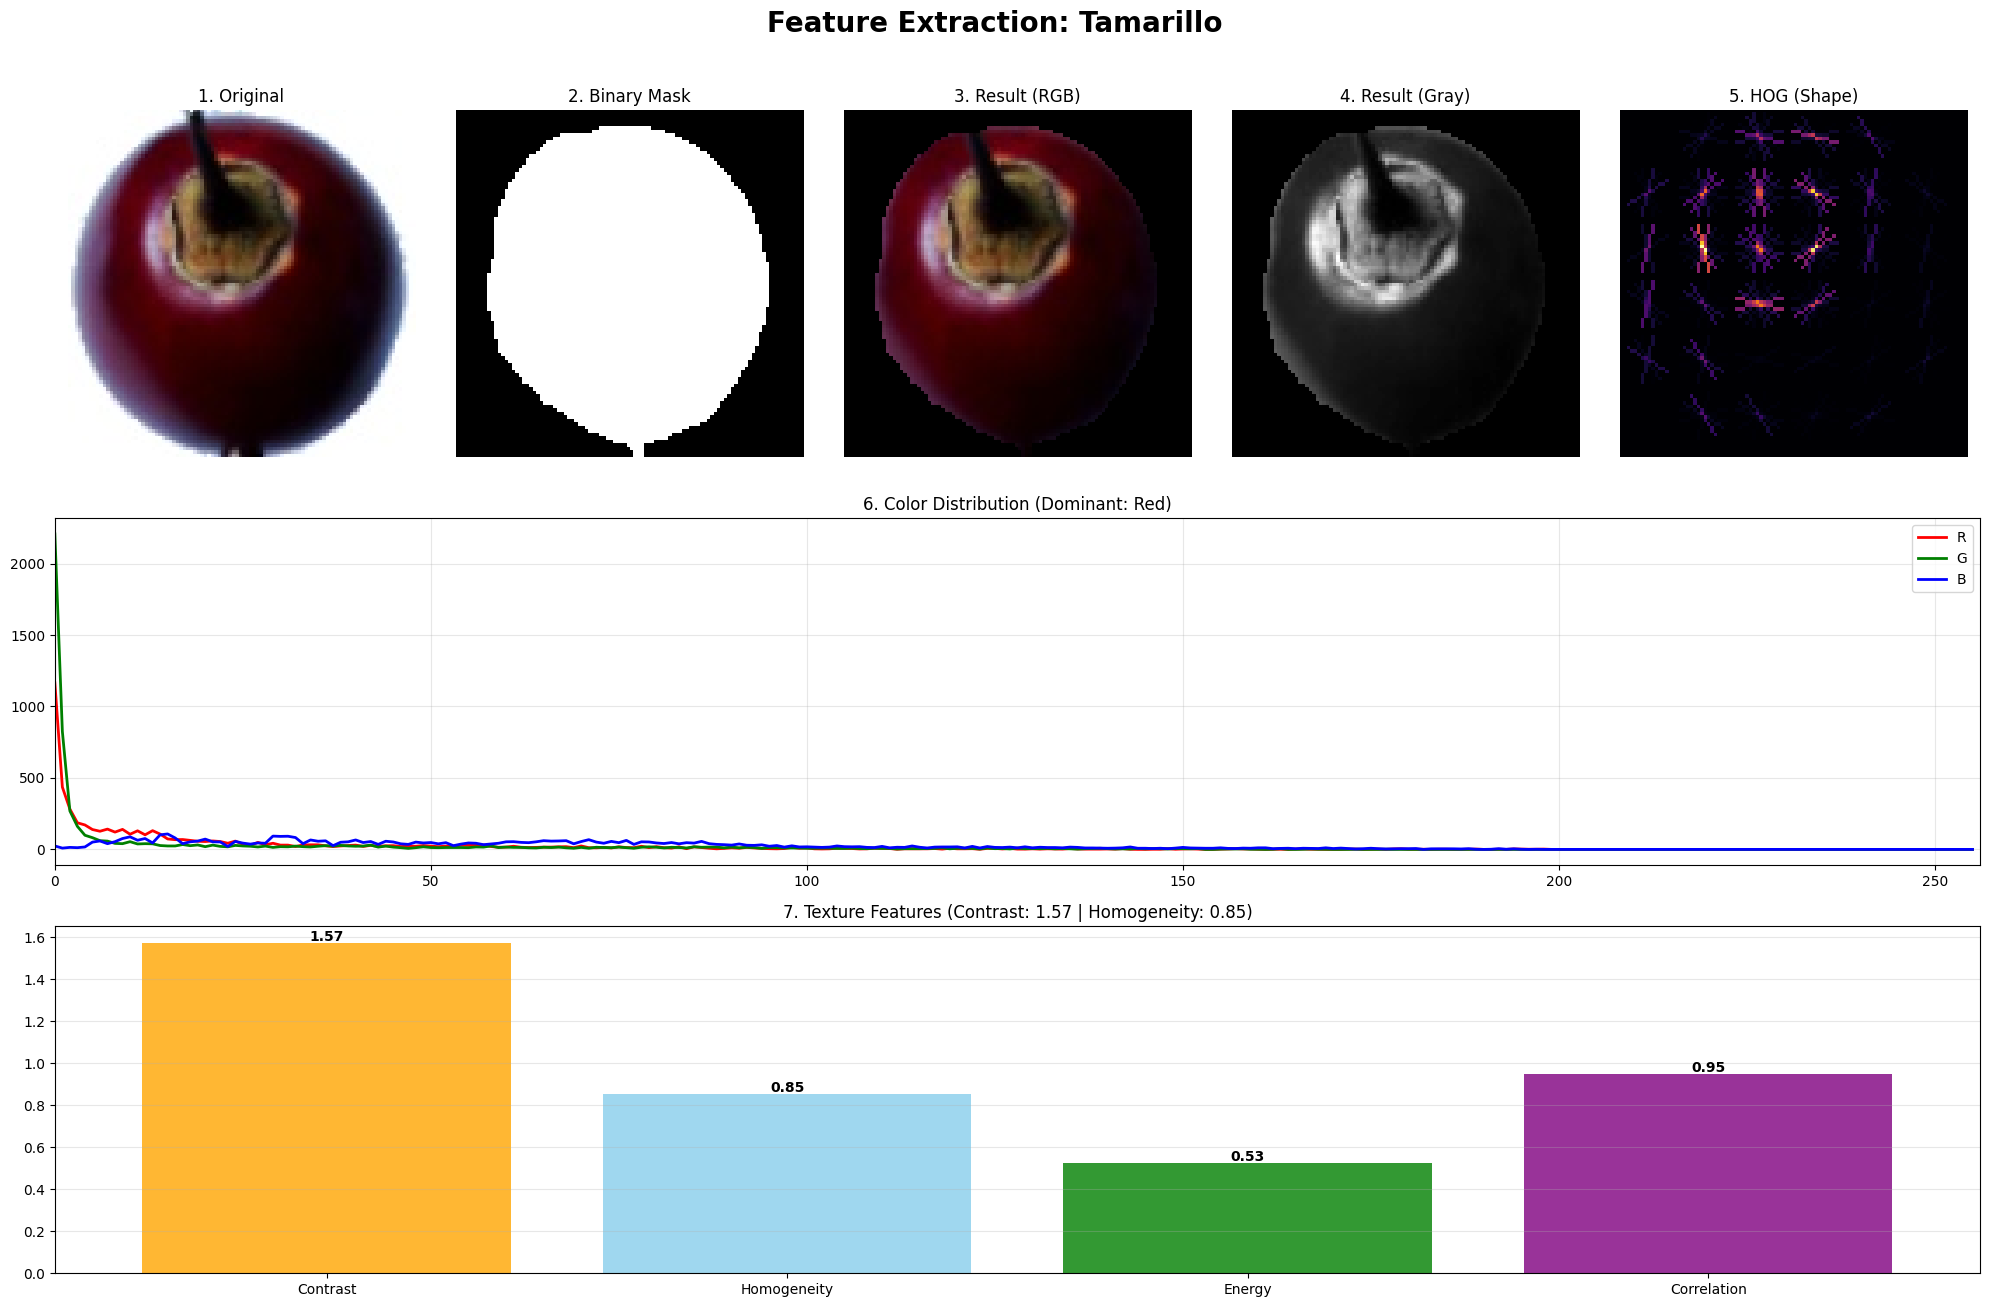

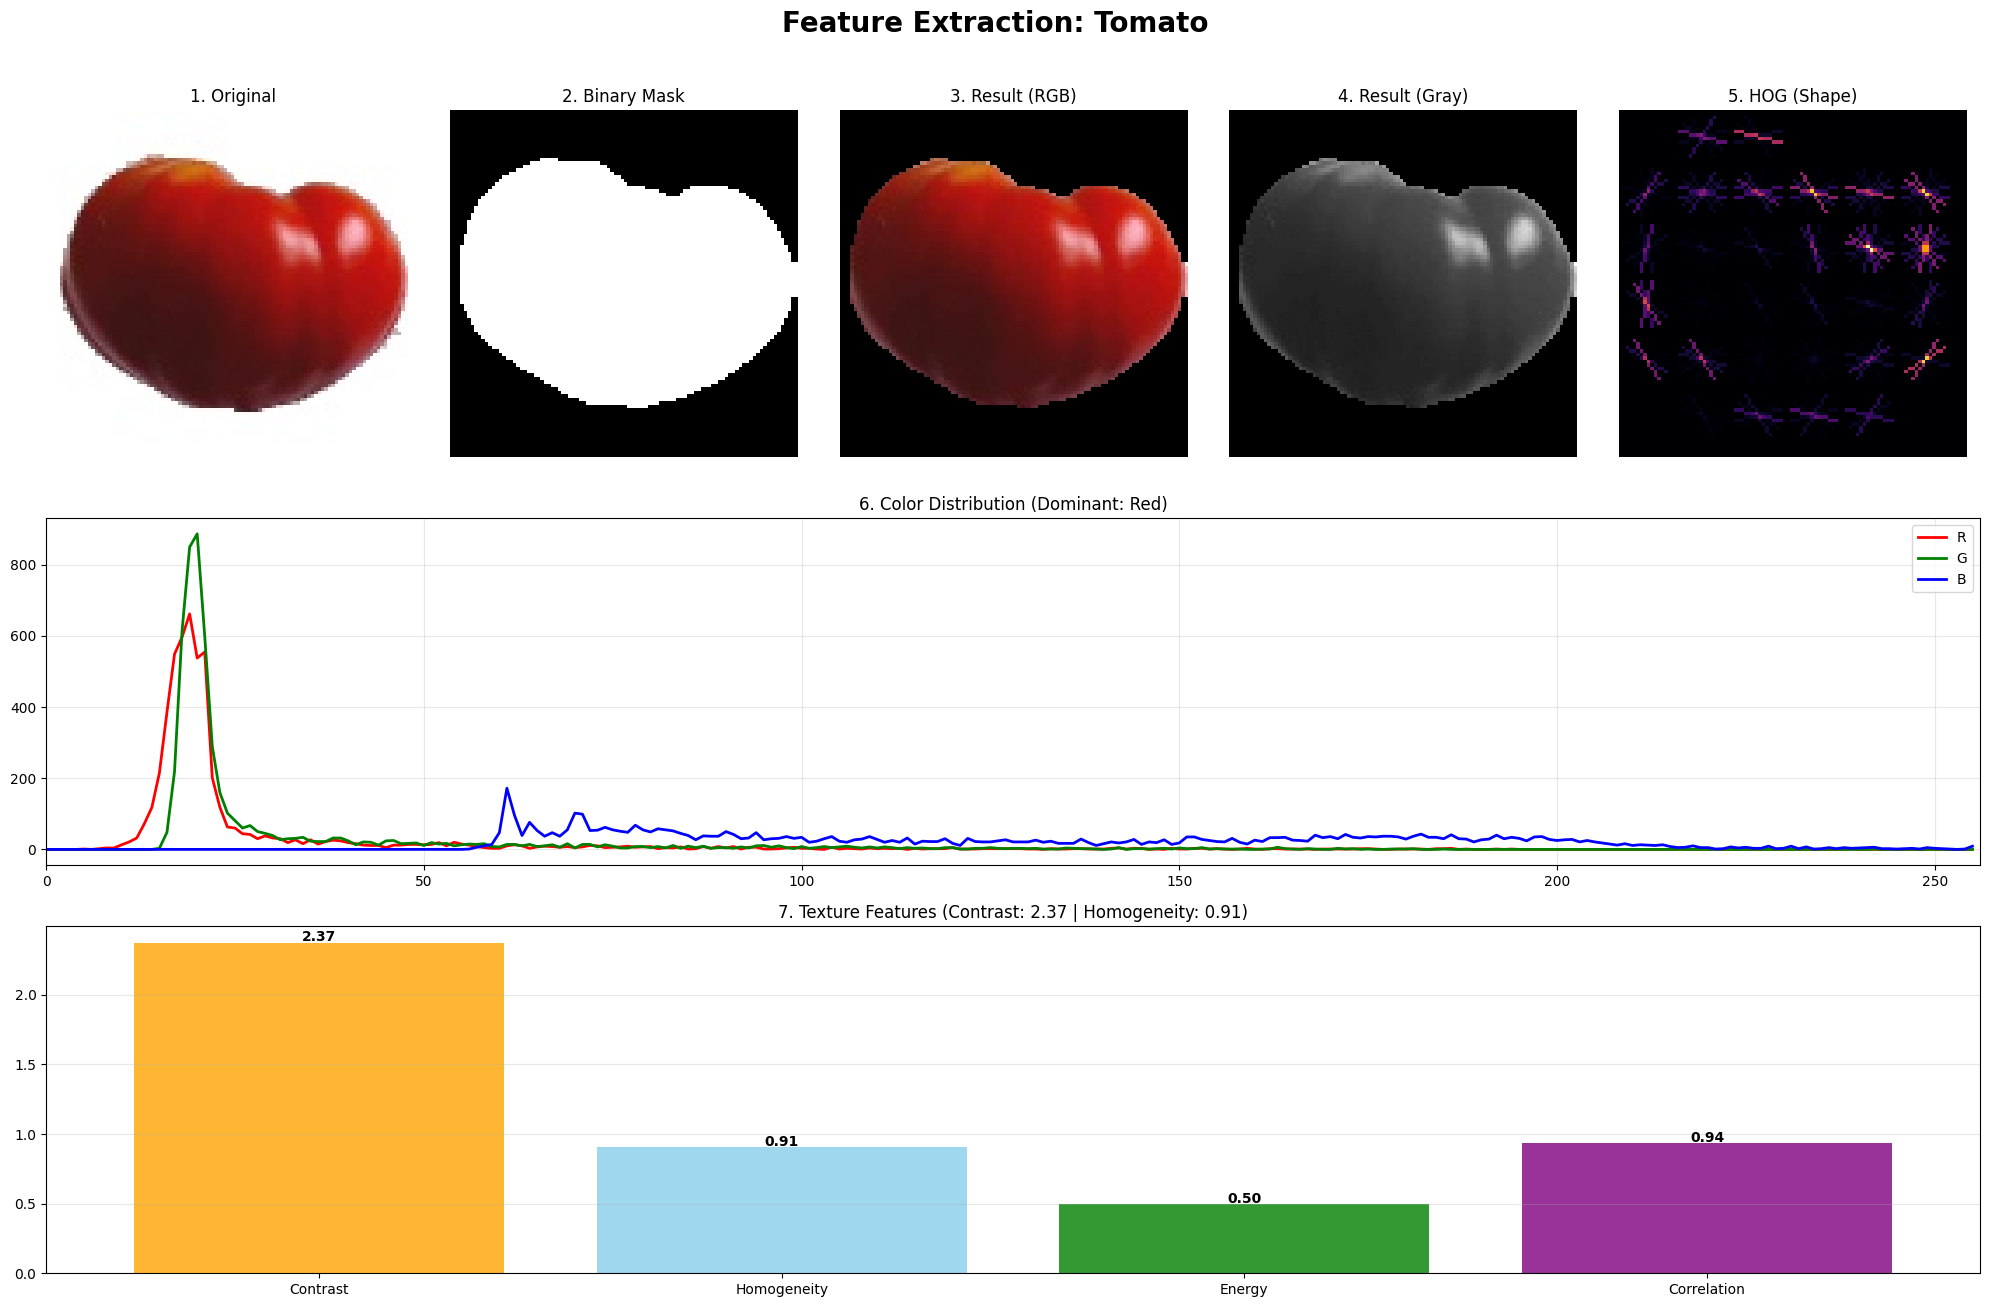

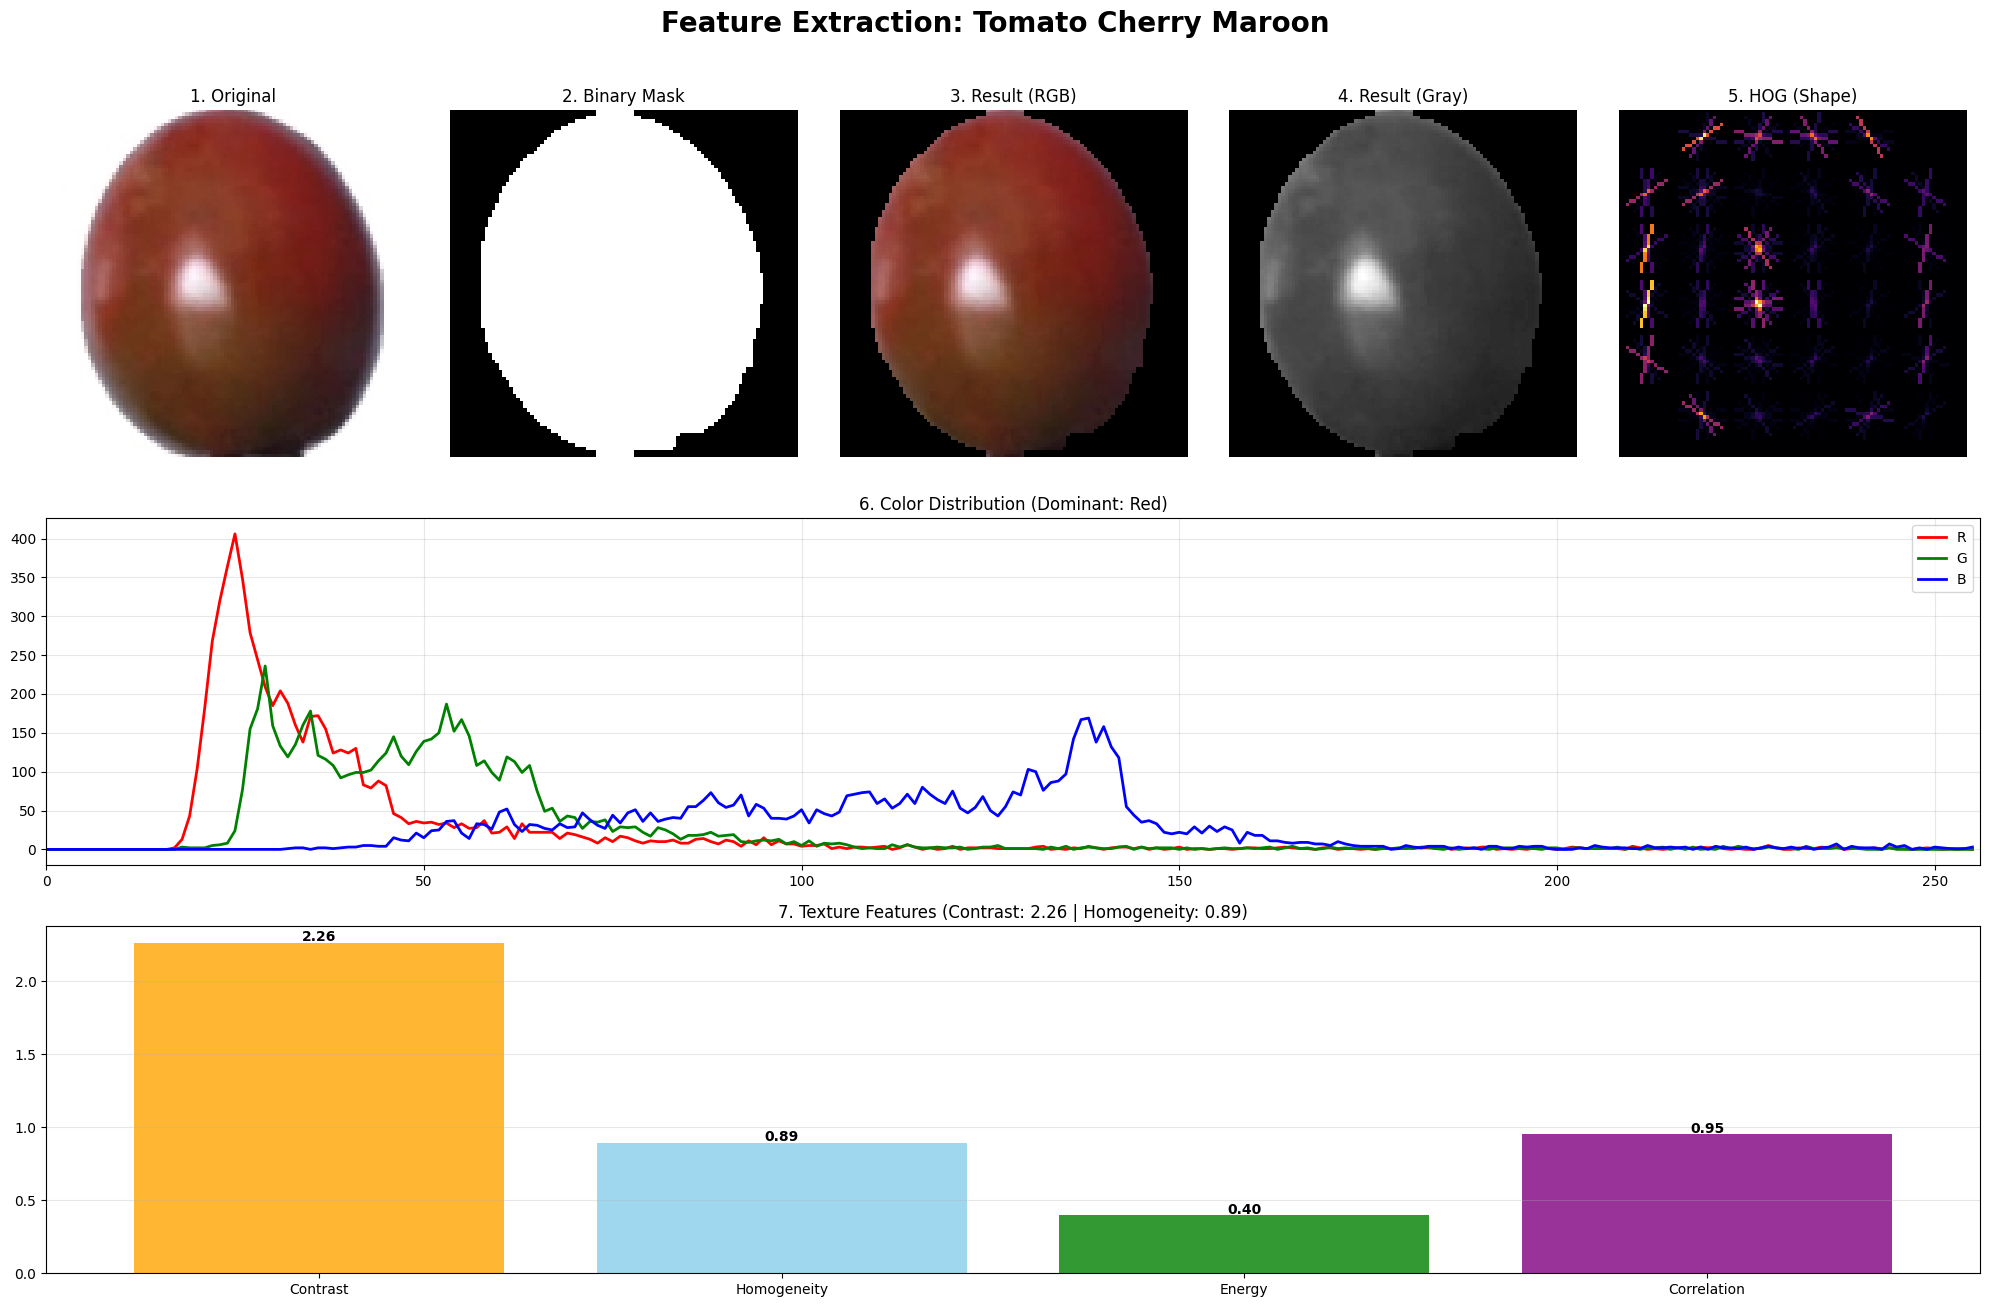

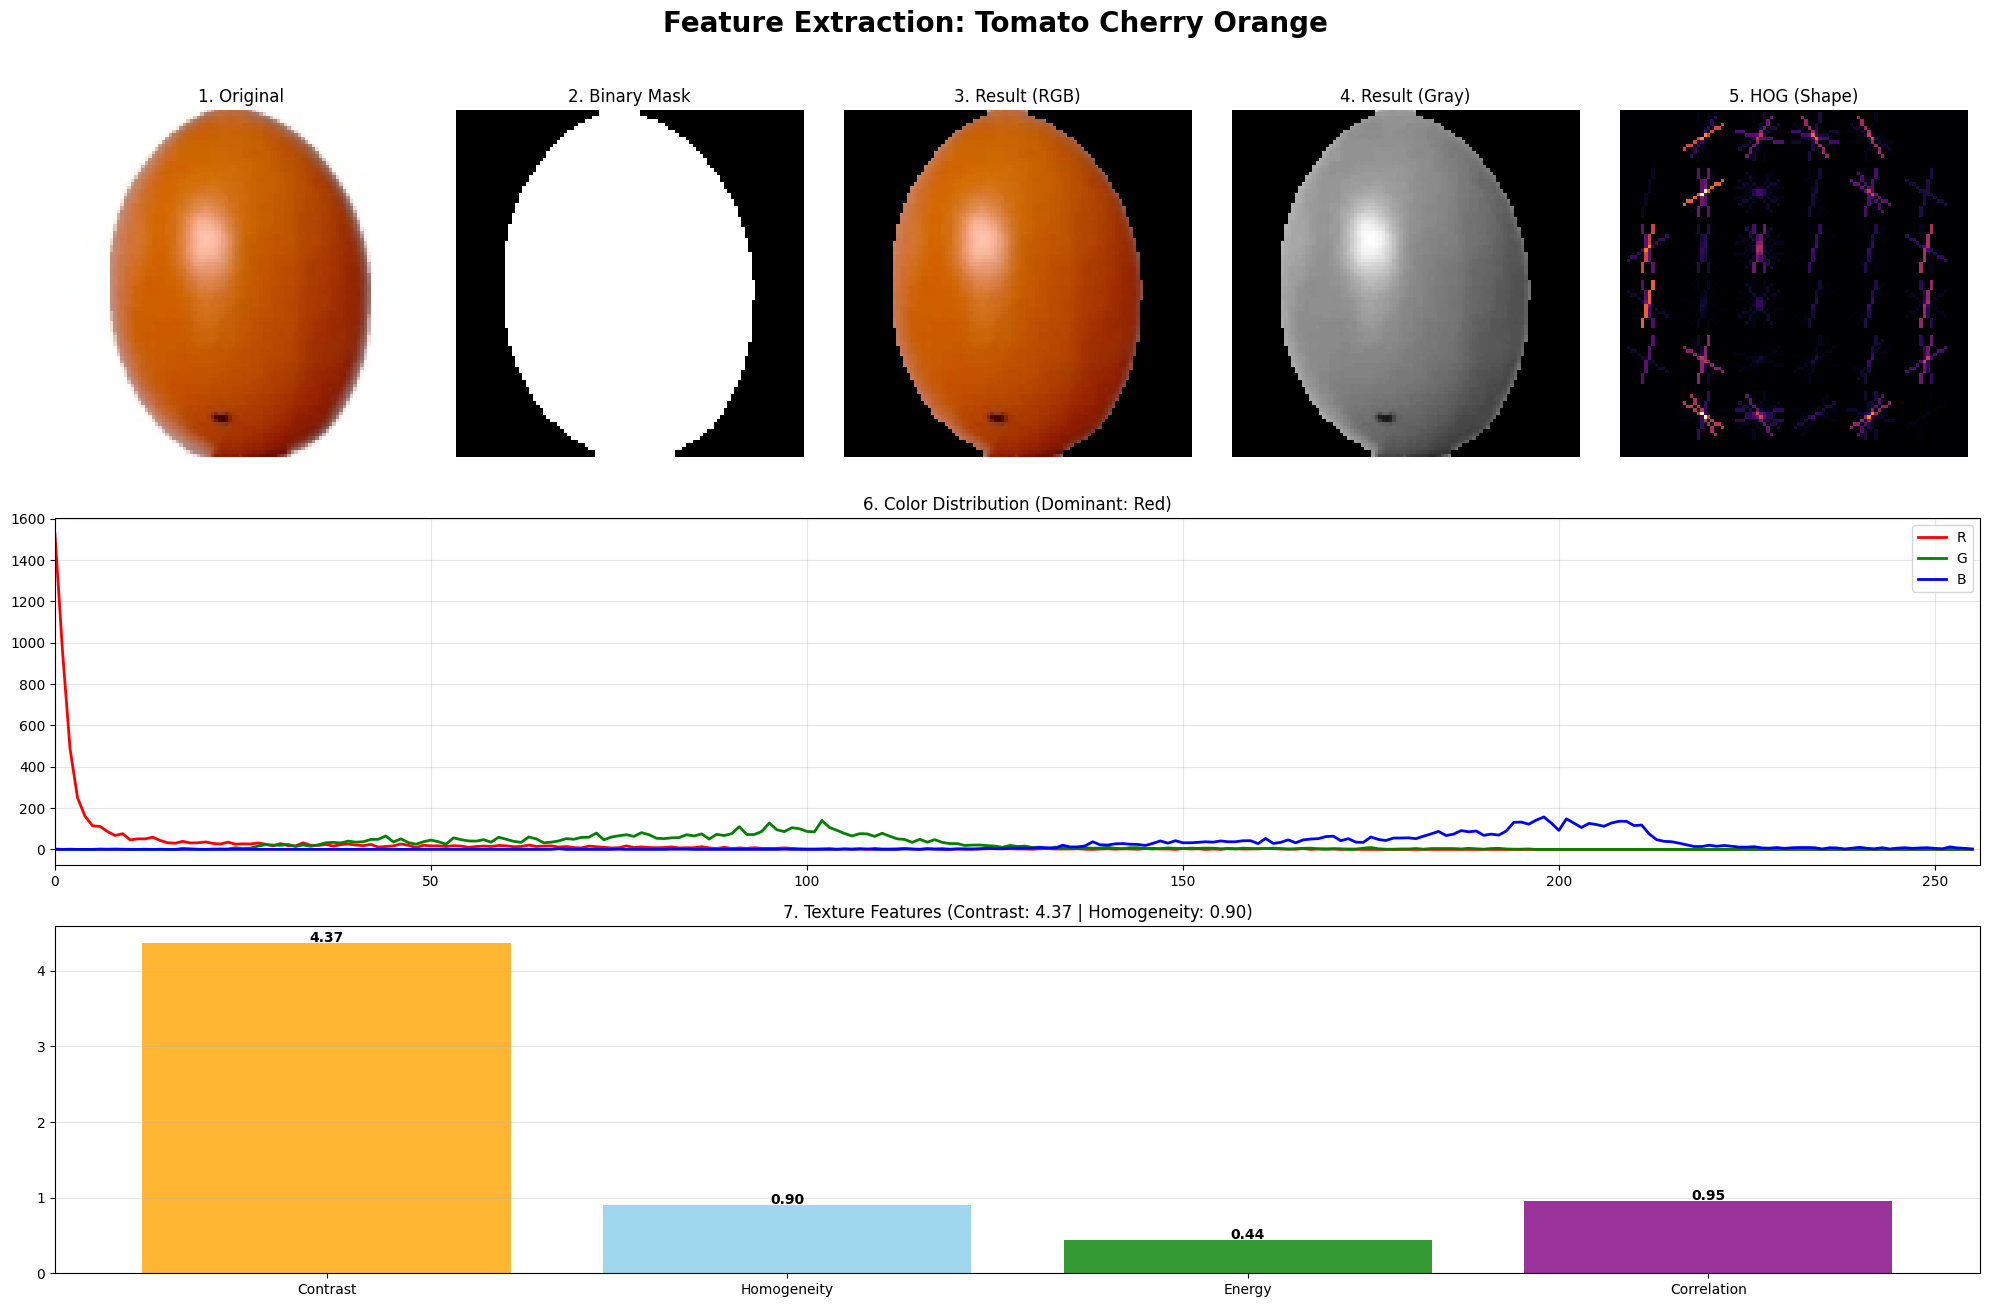

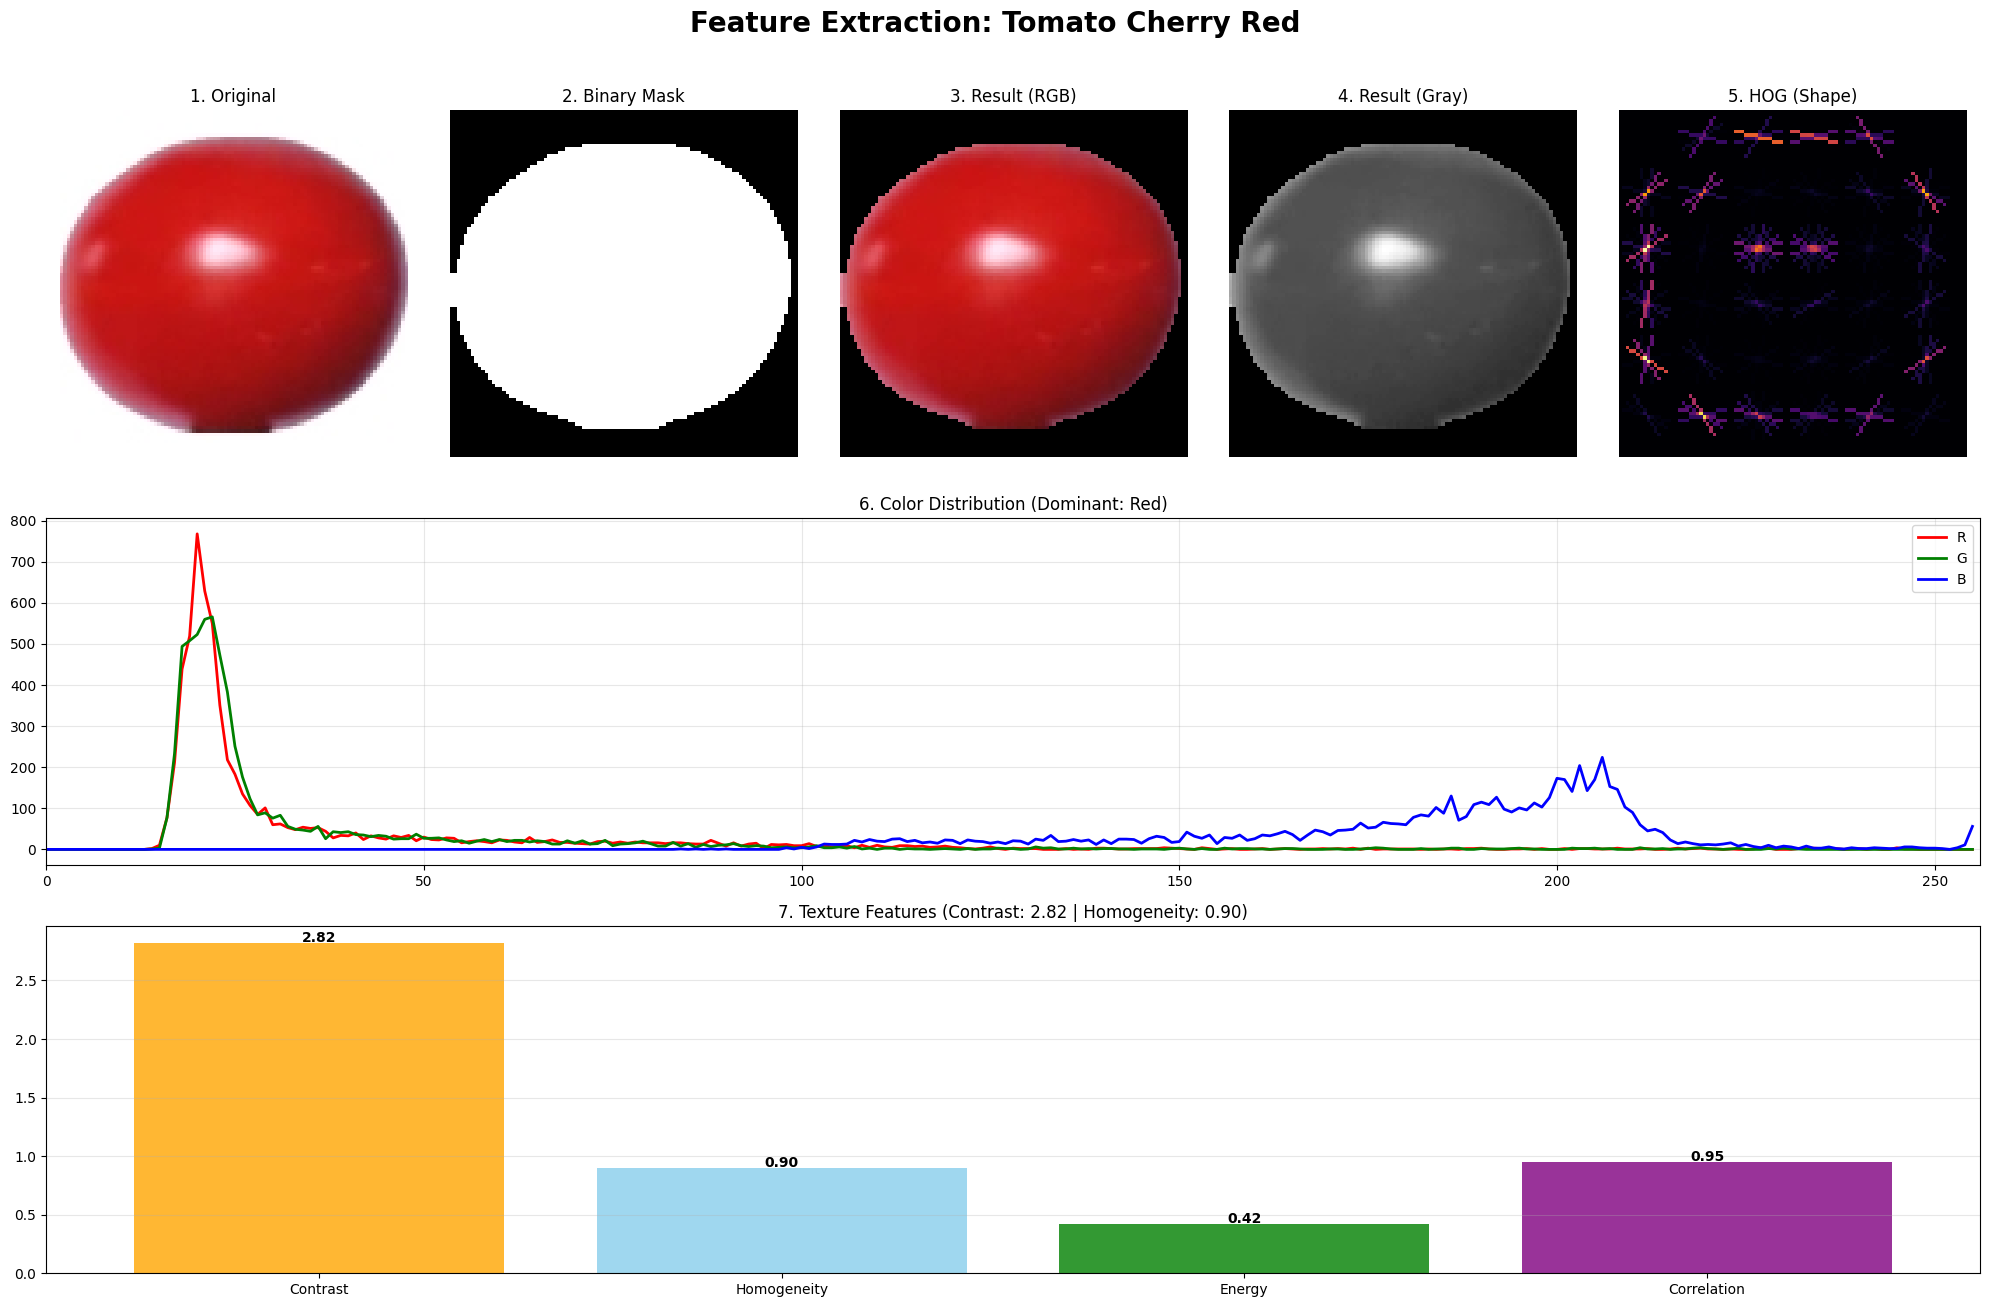

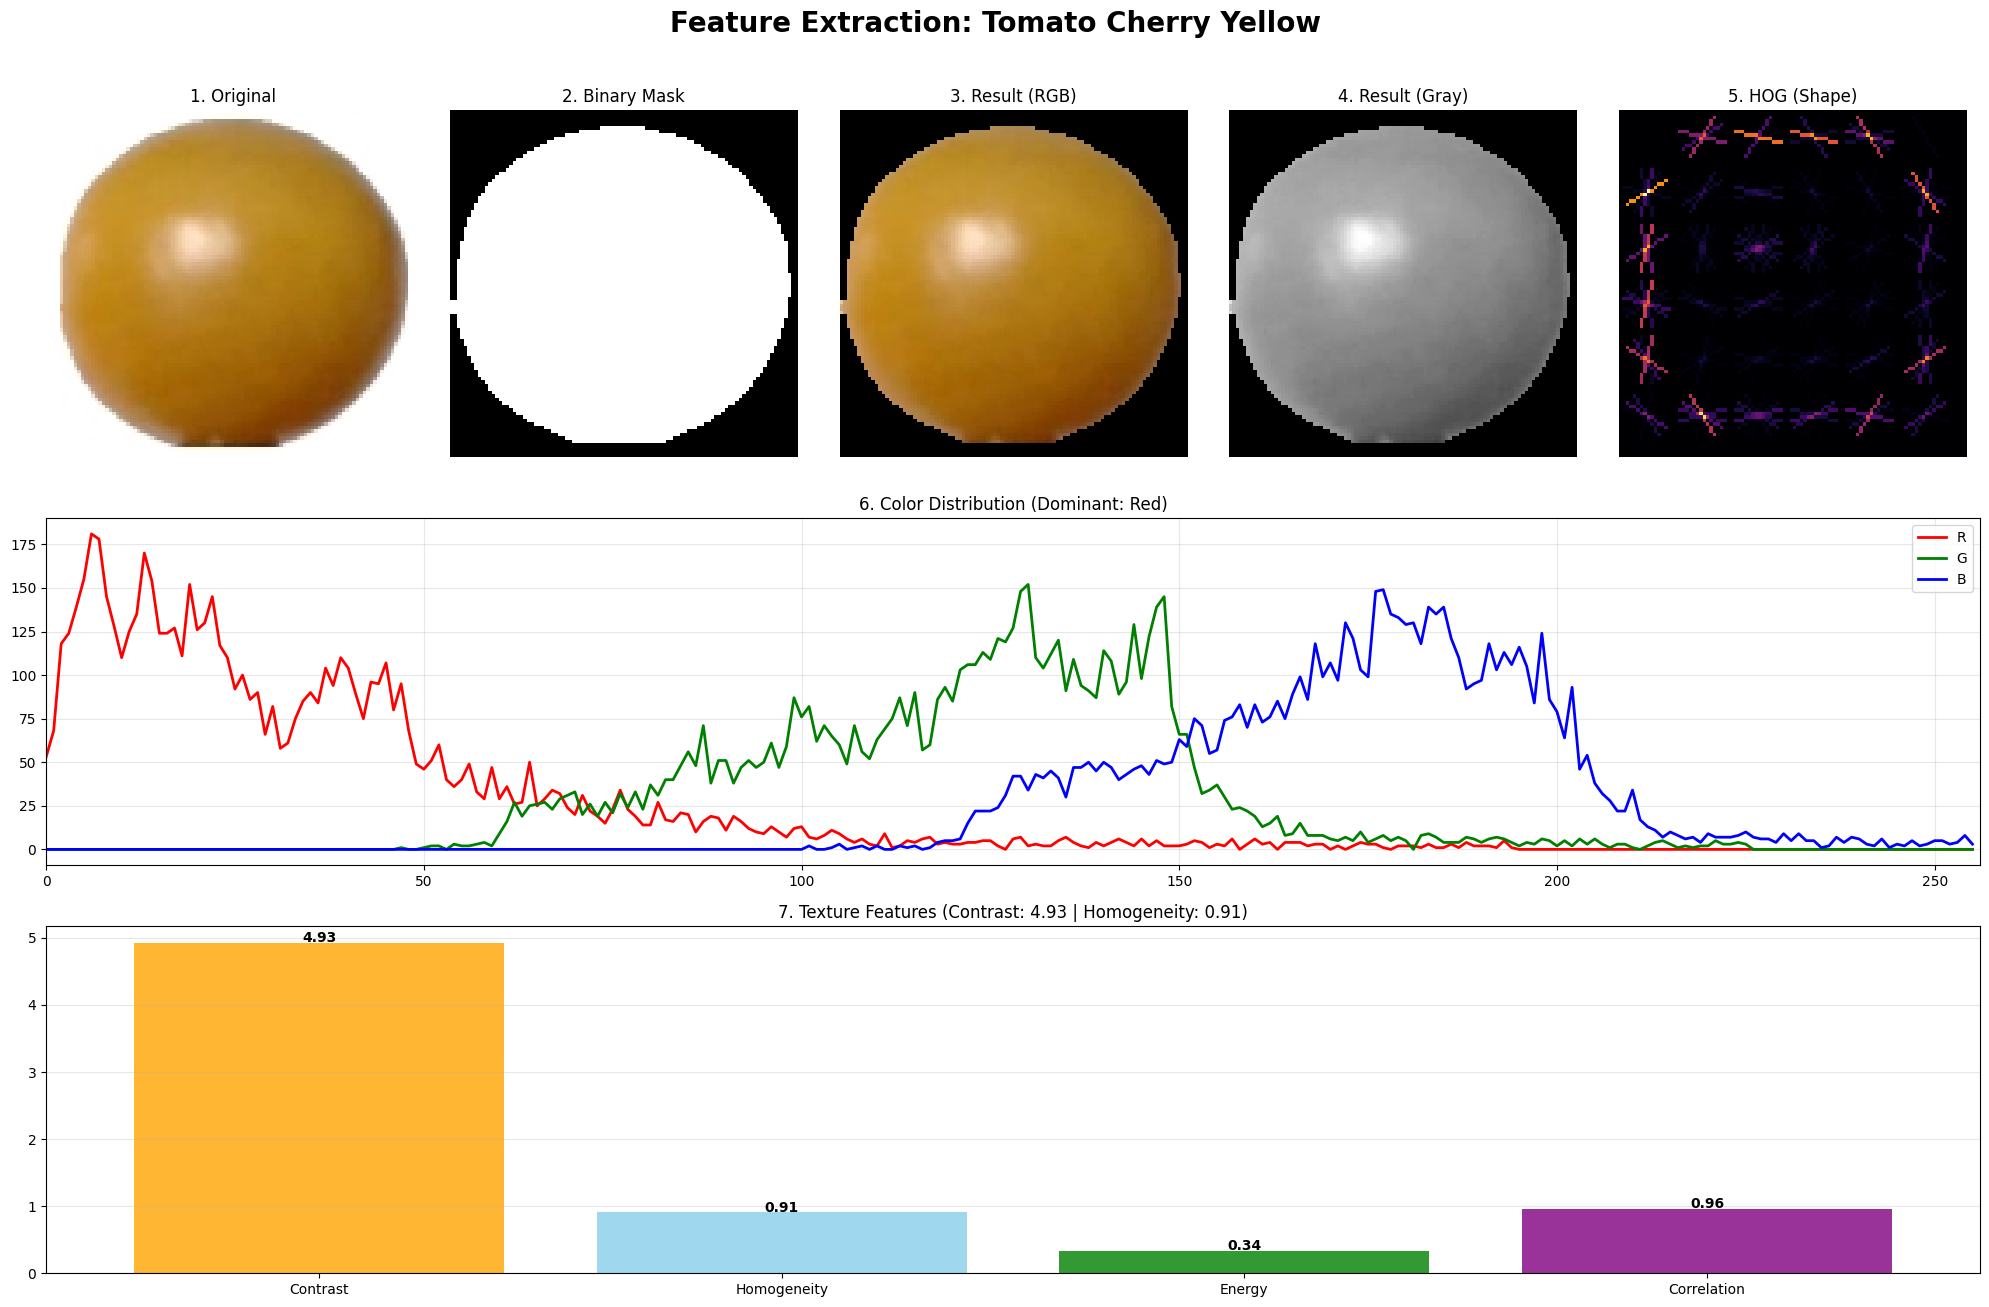

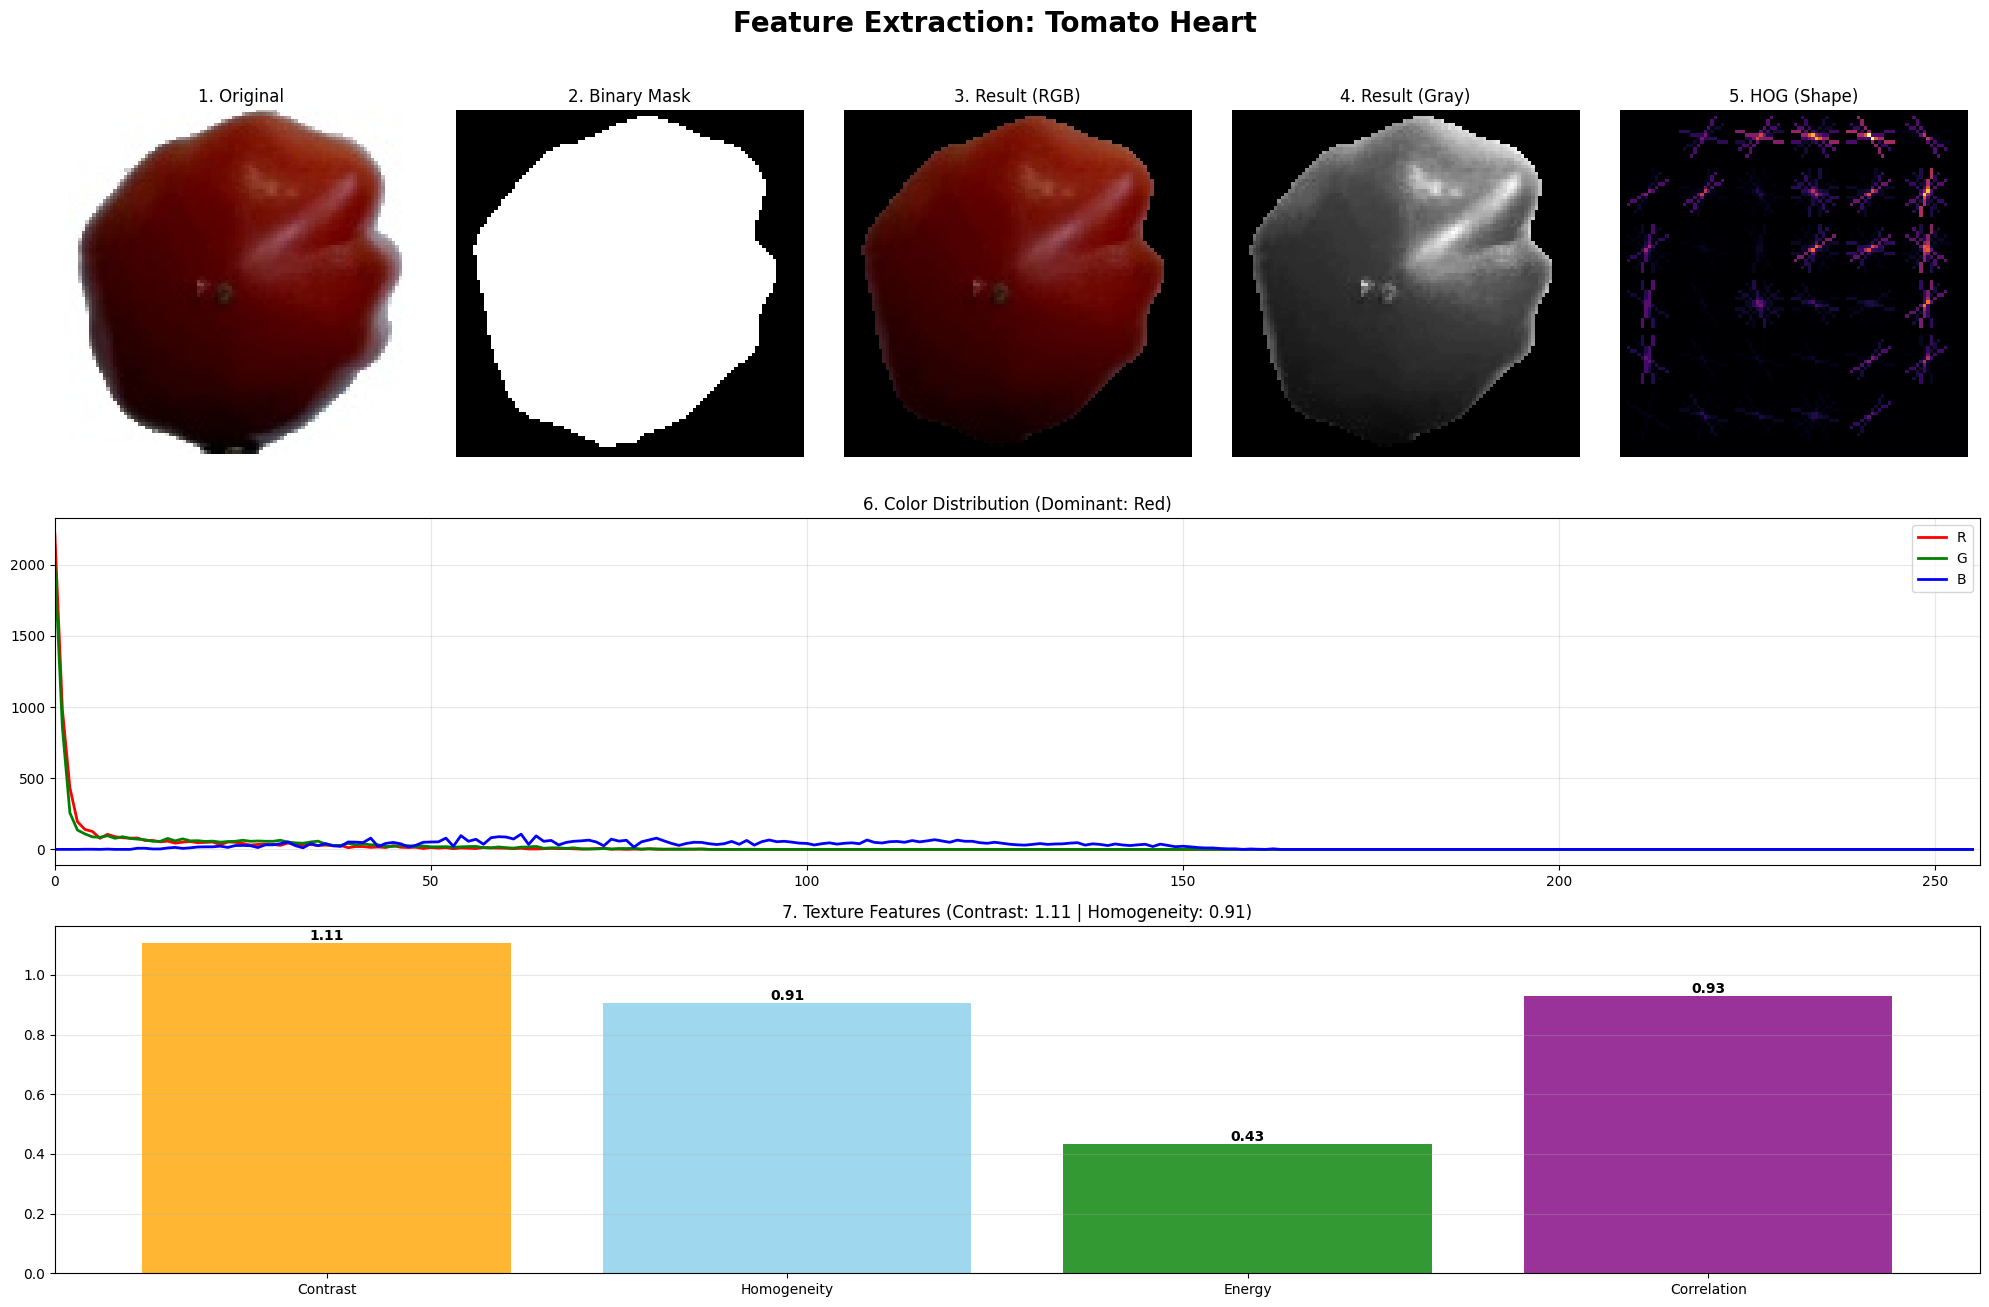

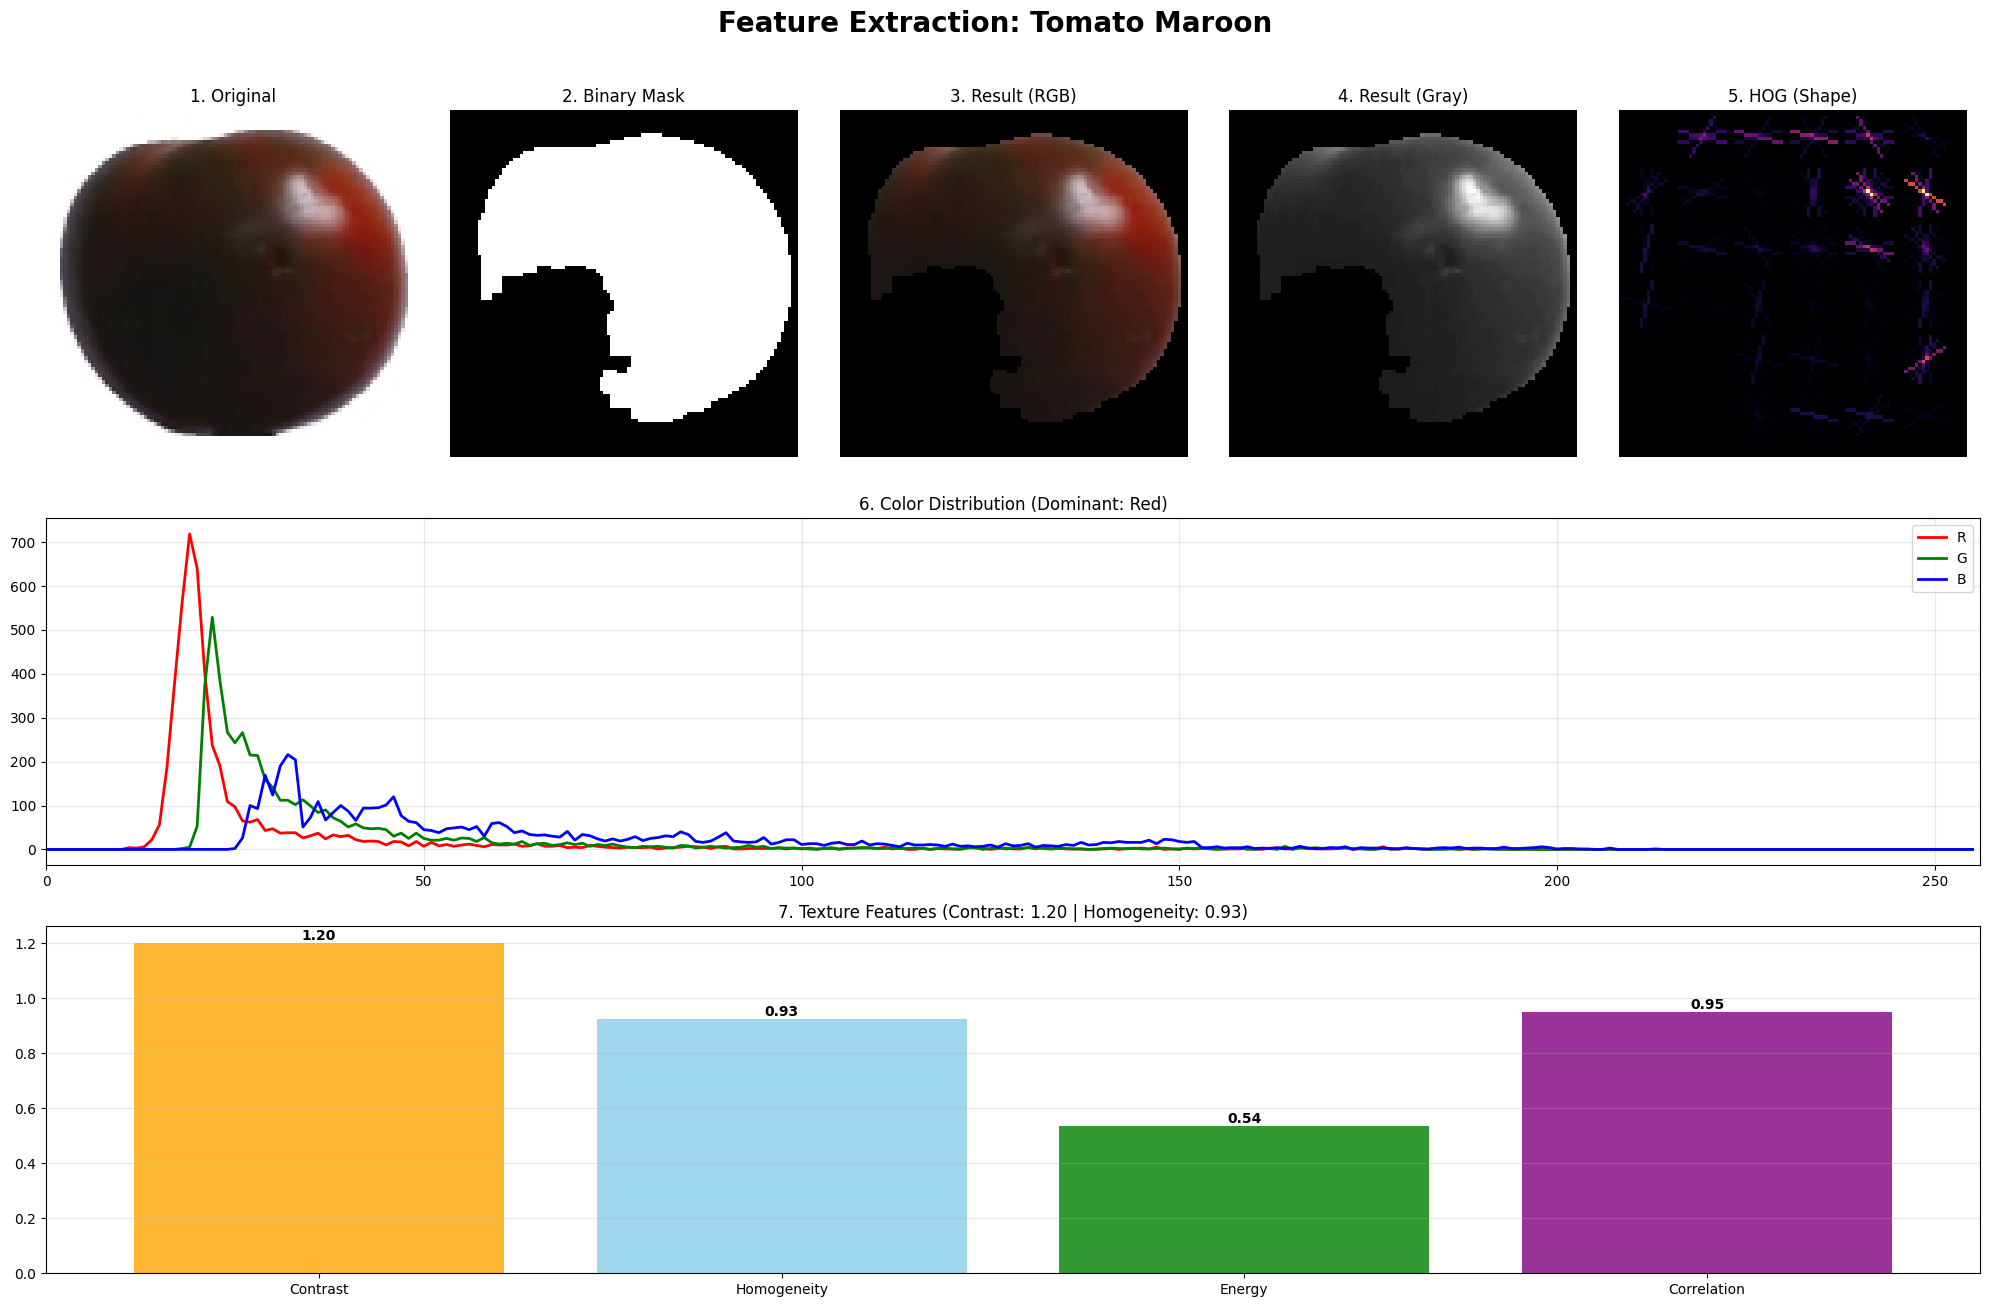

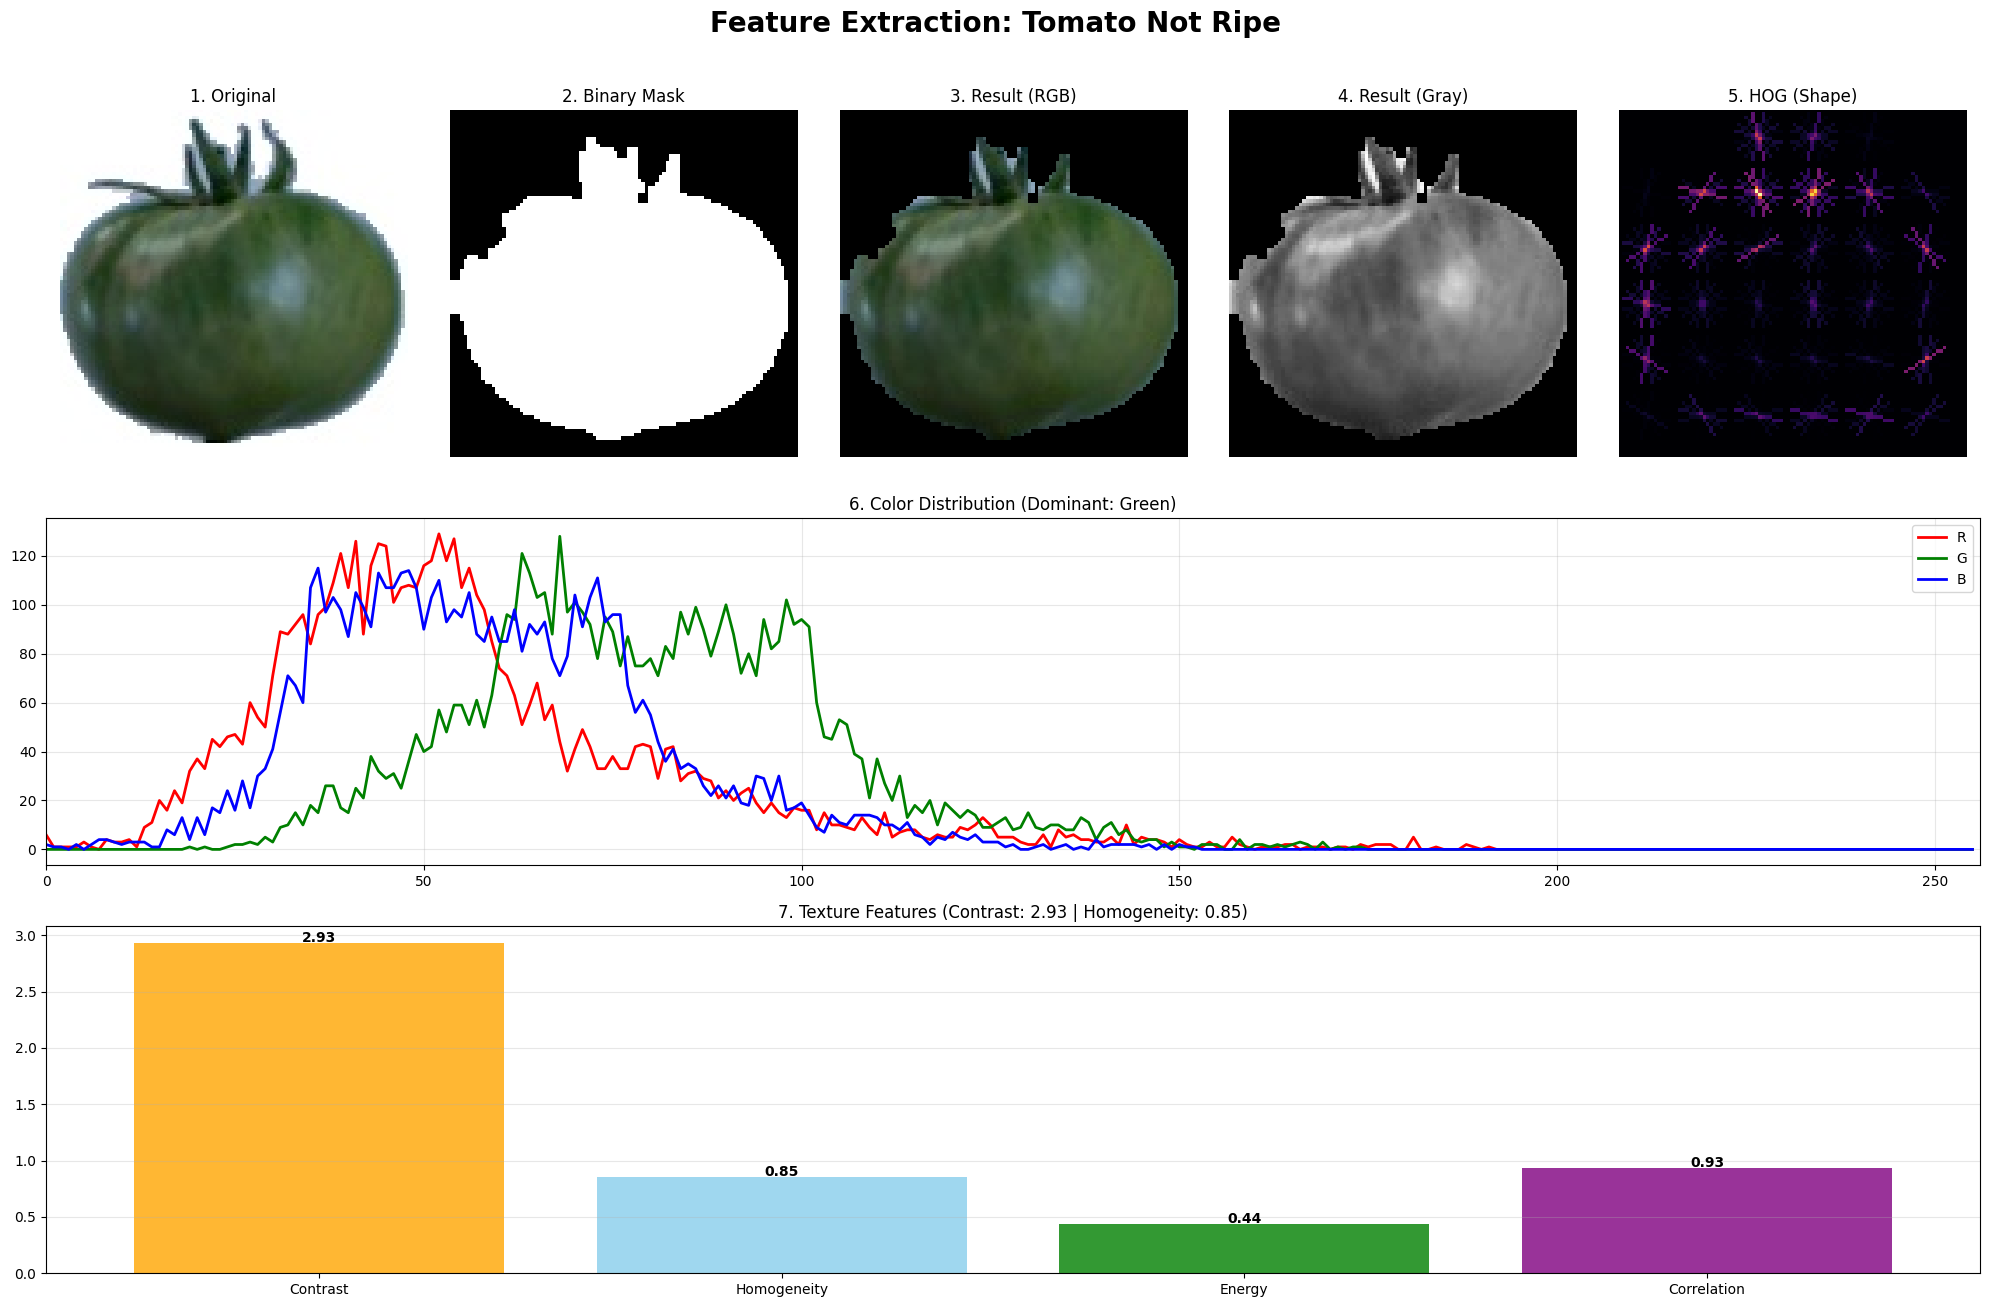

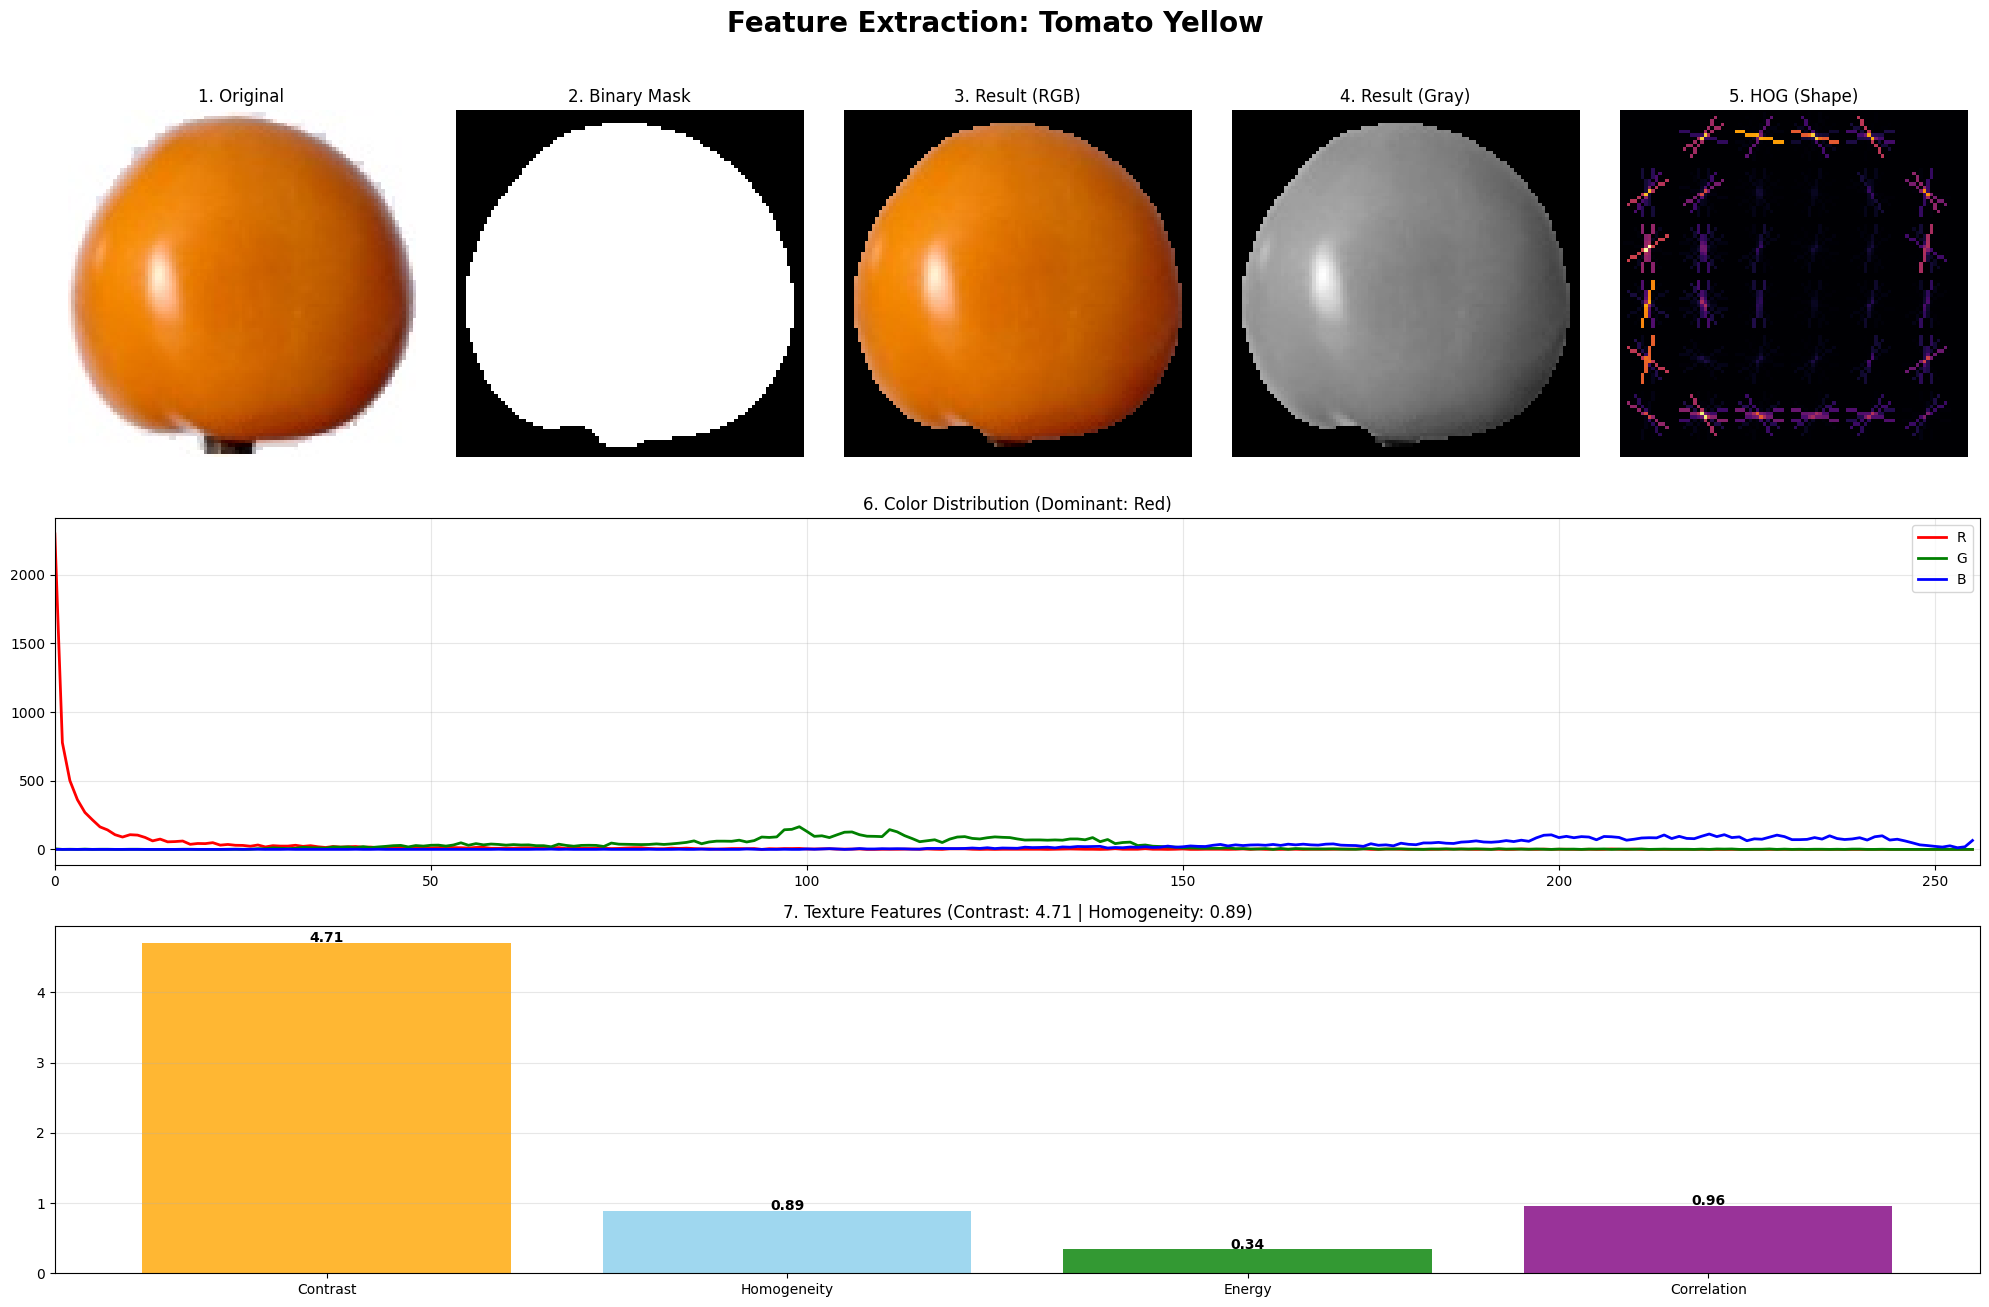

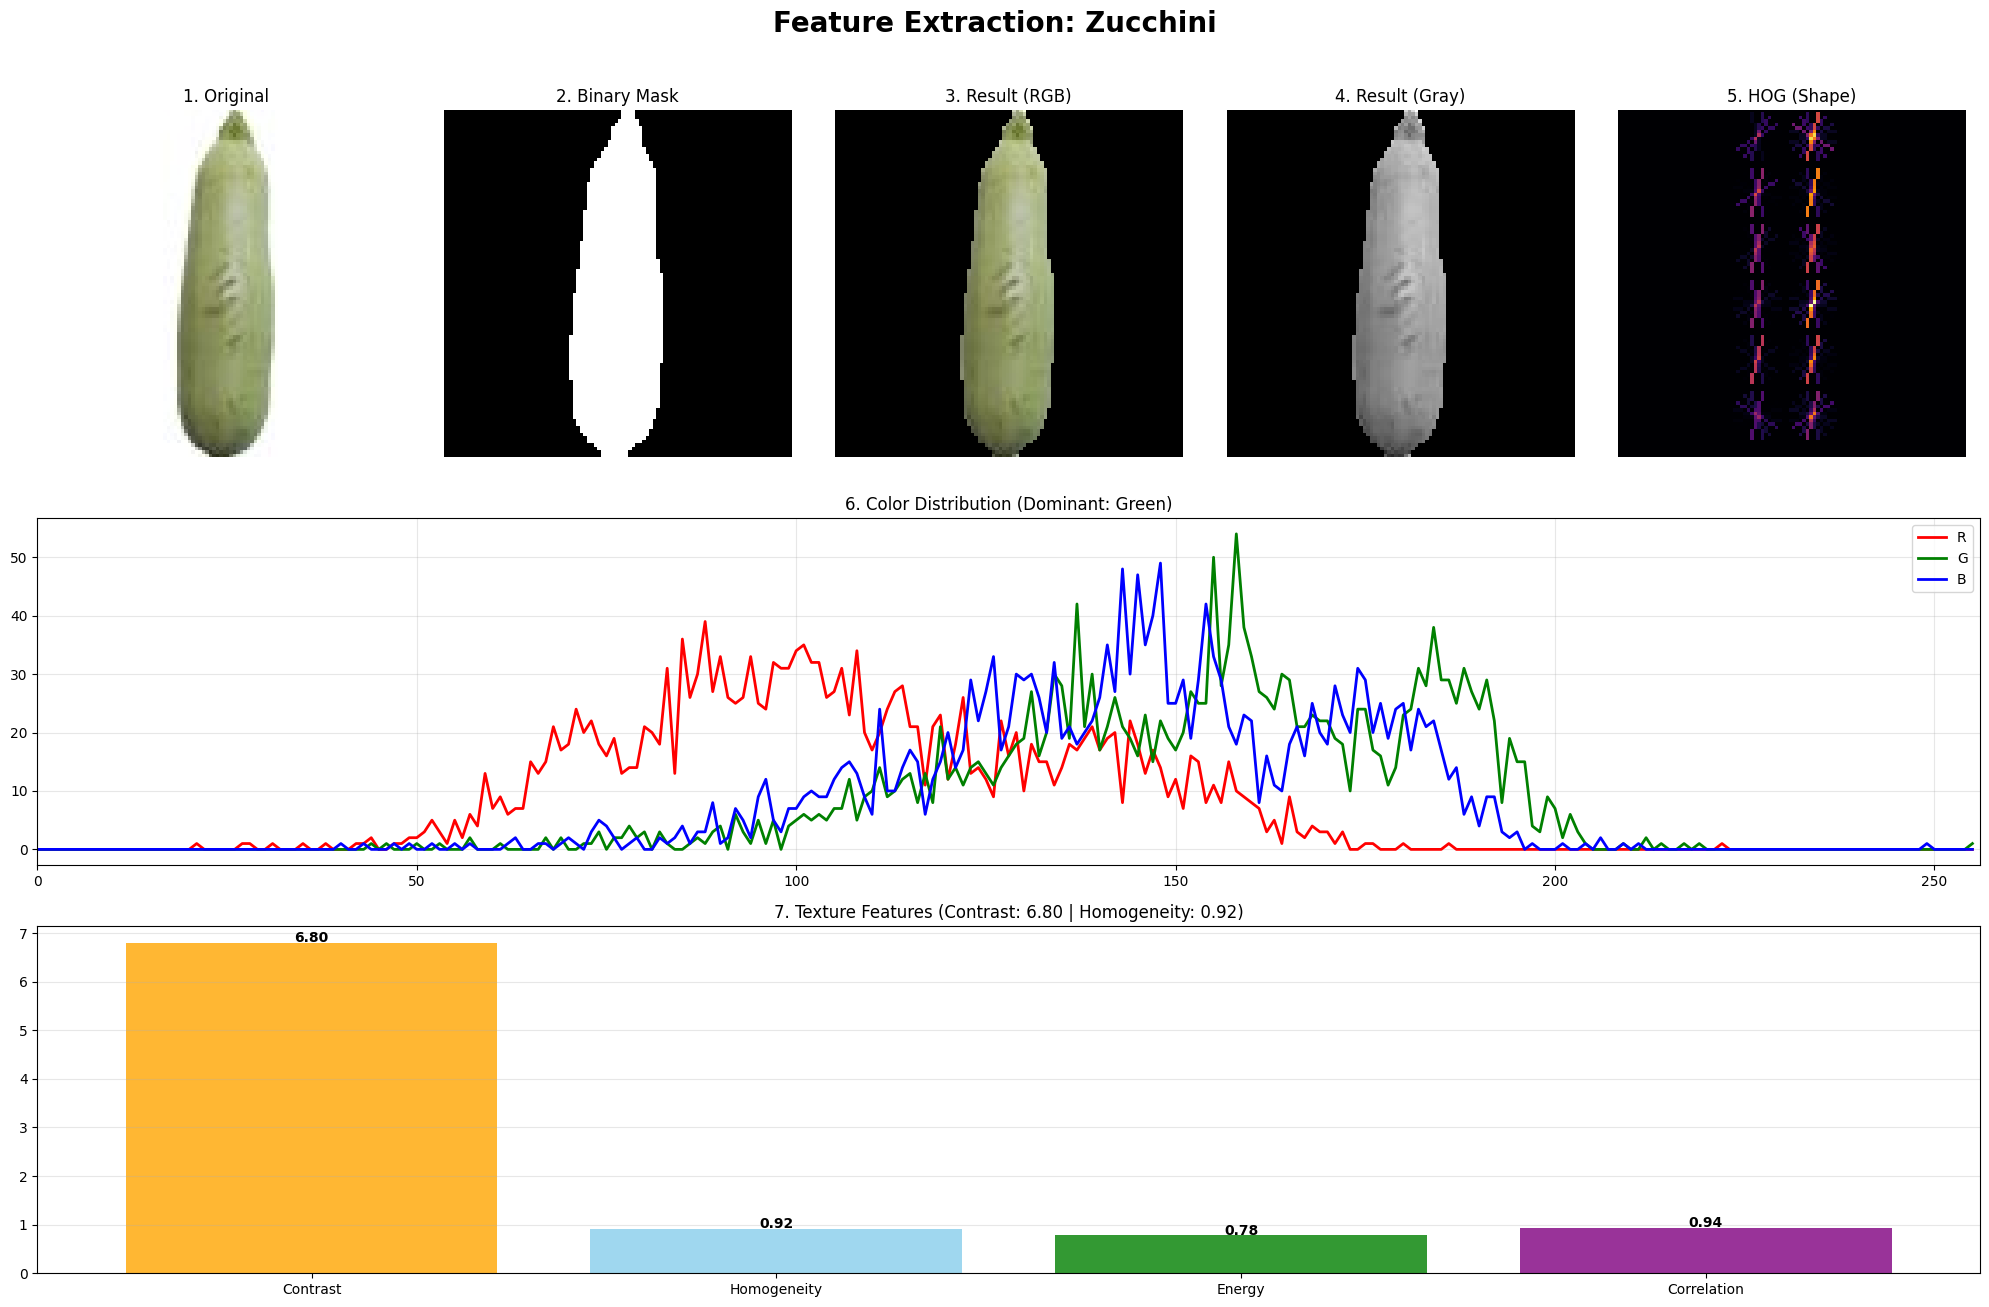

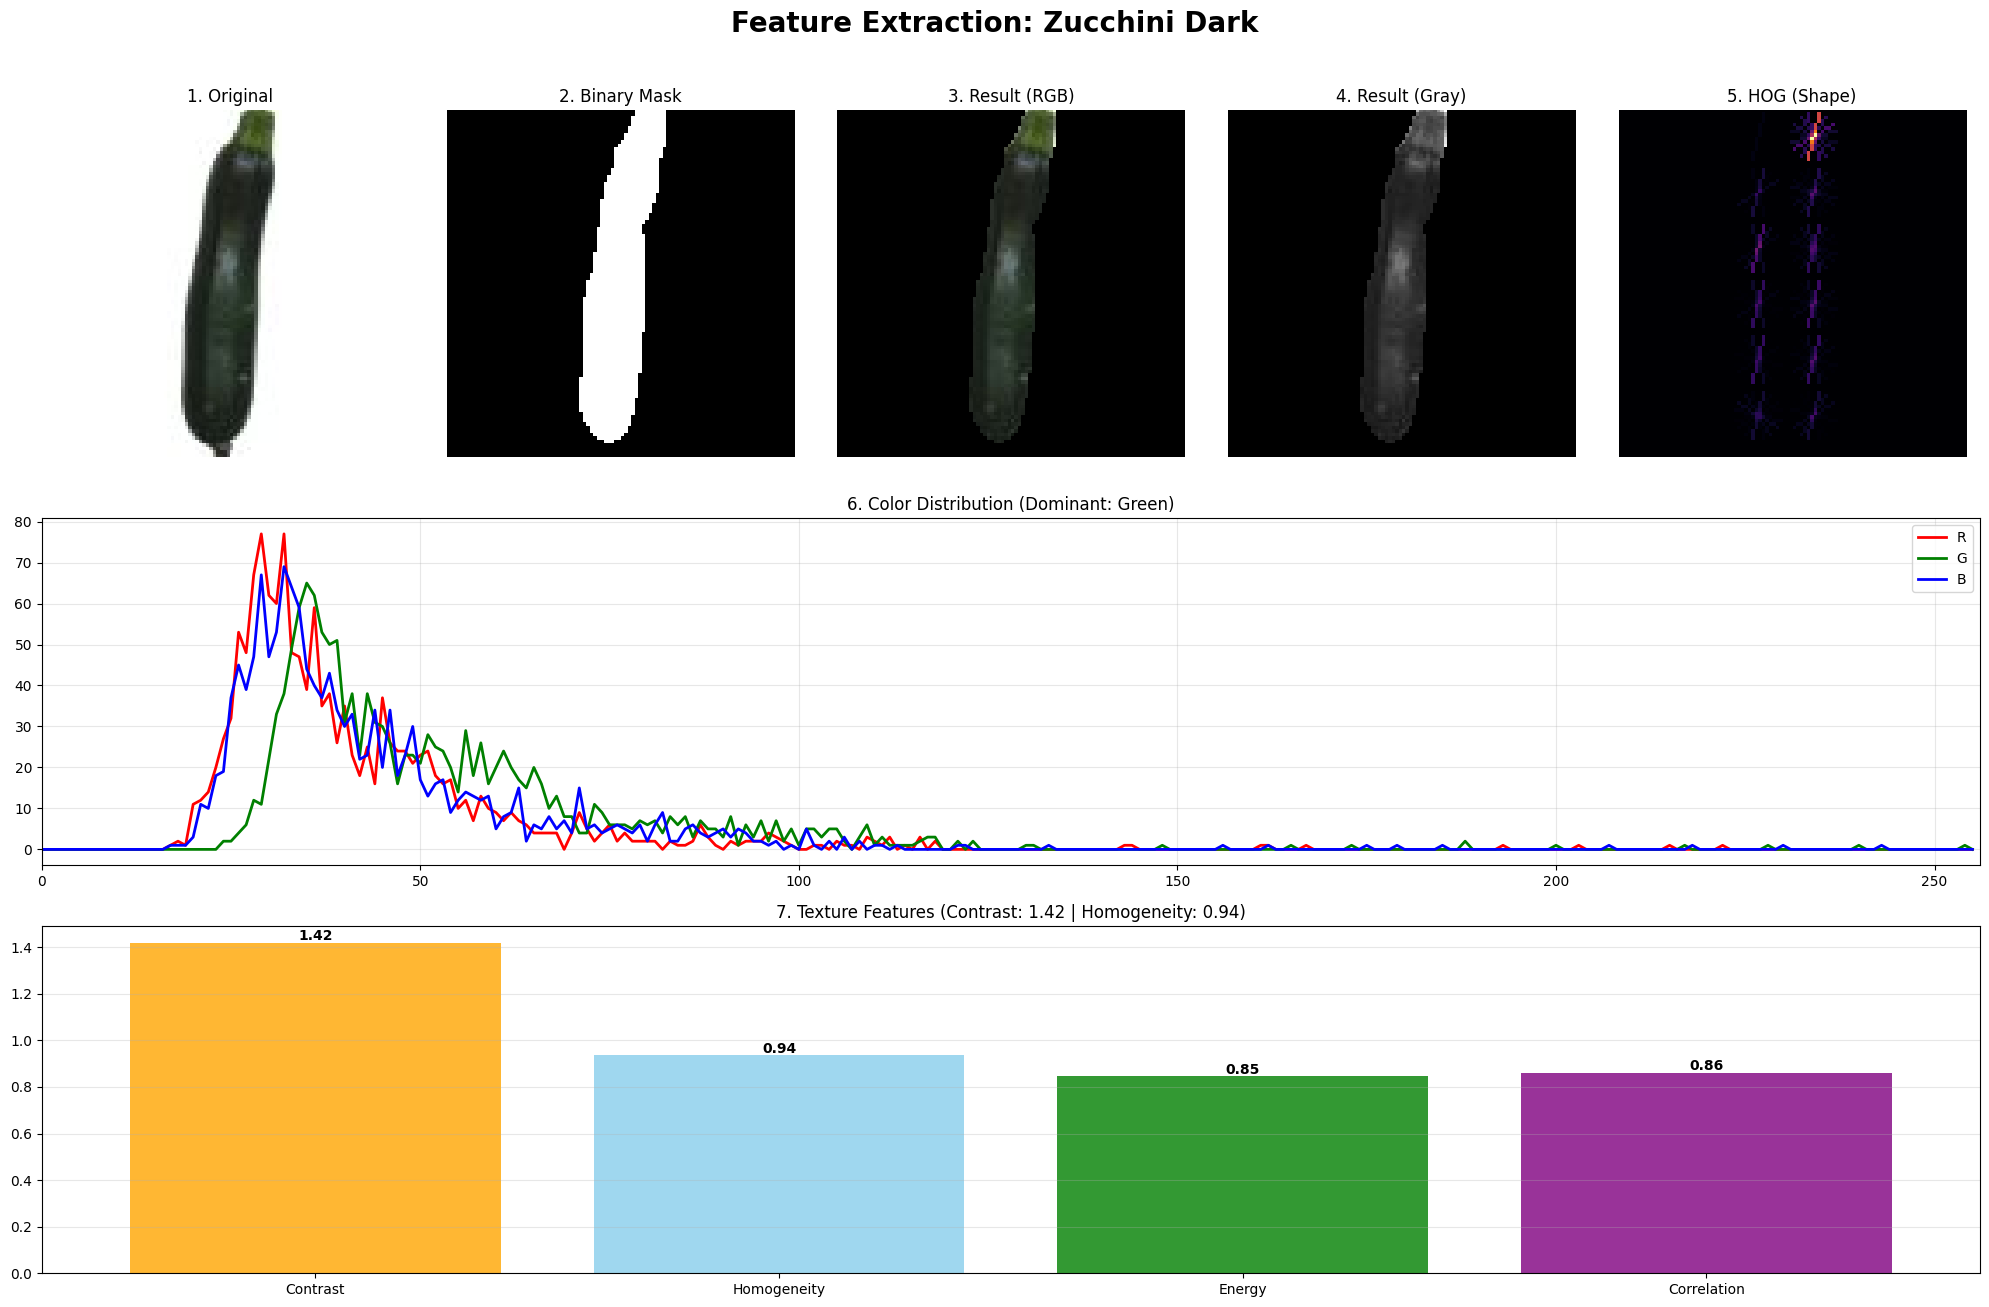


📊 KESIMPULAN ANALISIS FITUR (DATA SUMMARY)

🔹 ANALISIS TEKSTUR (Berdasarkan Nilai GLCM Contrast)
  (Nilai Contrast Tinggi = Permukaan Kasar/Banyak Tepi, Rendah = Halus)

  🏆 Top 3 Paling Kasar/Bertekstur:
     24. Zucchini (Val: 6.8020)
     2. Cactus Fruit (Val: 5.4339)
     8. Pepino (Val: 5.2866)

  🏆 Top 3 Paling Halus:
     7. Eggplant Long (Val: 0.4493)
     6. Eggplant (Val: 0.5271)
     4. Cucumber (Val: 0.6871)

🔹 ANALISIS WARNA (Berdasarkan Dominant Channel RGB)

  🎨 Dominan Red (19 Buah):
     Beans, Cactus Fruit, Cucumber Ripe, Eggplant, Eggplant Long, Pepino, Pepper Orange, Pepper Red, Pepper Yellow, Pitahaya Red, Tamarillo, Tomato, Tomato Cherry Maroon, Tomato Cherry Orange, Tomato Cherry Red, Tomato Cherry Yellow, Tomato Heart, Tomato Maroon, Tomato Yellow

  🎨 Dominan Green (6 Buah):
     Corn Husk, Cucumber, Pepper Green, Tomato Not Ripe, Zucchini, Zucchini Dark

  🎨 Dominan Blue: Tidak ada sampel.

🔹 TABEL DATA LENGKAP (5 Sampel Pertama)
                   Class  Con

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from skimage.feature import graycomatrix, graycoprops, hog

# ==========================================
# CONFIG
# ==========================================
DATASET_ROOT = '/content/fruit-clean/Training'

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def get_accurate_segmentation(img_bgr):
    """Mendapatkan mask dan hasil segmentasi"""
    blurred = cv2.GaussianBlur(img_bgr, (5, 5), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    s = hsv[:, :, 1]
    _, mask = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = img_bgr.copy()

    if contours:
        c = max(contours, key=cv2.contourArea)
        clean_mask = np.zeros_like(s)
        cv2.drawContours(clean_mask, [c], -1, 255, -1)
        result = cv2.bitwise_and(img_bgr, img_bgr, mask=clean_mask)
        return mask, clean_mask, result
    return mask, mask, result

def get_hog_vis(img_gray, pixels_per_cell):
    """Mendapatkan visualisasi HOG"""
    fd, hog_image = hog(img_gray, orientations=8, pixels_per_cell=pixels_per_cell,
                        cells_per_block=(2, 2), visualize=True, block_norm="L2-Hys")
    return hog_image

# ==========================================
# CORE EXTRACTION & VISUALIZATION
# ==========================================

def process_and_visualize(image_path, show_plot=True):
    img = cv2.imread(image_path)
    if img is None:
        return None

    folder_name = image_path.split(os.sep)[-2]
    file_name = image_path.split(os.sep)[-1]

    # --- 1. PREPROCESSING ---
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (100, 100))
    img_gray_fast = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Accurate Processing (Segmentation)
    raw_mask, clean_mask, img_seg = get_accurate_segmentation(img_resized)
    img_seg_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)
    img_gray_acc = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

    # HOG
    hog_acc = get_hog_vis(img_gray_acc, (16, 16))

    # --- 2. CALCULATE FEATURES (DATA COLLECTION) ---

    # A. GLCM Features (Texture)
    # Distance=1, Angle=0 (Horizontal)
    glcm_acc = graycomatrix(img_gray_acc // 8, [1], [0], 32, symmetric=True, normed=True)
    contrast = graycoprops(glcm_acc, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm_acc, 'homogeneity')[0, 0]
    energy = graycoprops(glcm_acc, 'energy')[0, 0]
    correlation = graycoprops(glcm_acc, 'correlation')[0, 0]

    # B. Color Features (Simple Dominant Channel Mean)
    # Hitung rata-rata RGB hanya di area Mask (bukan background hitam)
    mean_val = cv2.mean(img_seg, mask=clean_mask)[:3] # (B, G, R)
    mean_rgb = (mean_val[2], mean_val[1], mean_val[0]) # Convert to R, G, B

    # Tentukan Dominant Color
    channels = ['Red', 'Green', 'Blue']
    dominant_idx = np.argmax(mean_rgb)
    dominant_color = channels[dominant_idx]

    # Simpan Data
    stats = {
        'Class': folder_name,
        'File': file_name,
        'Contrast': contrast,
        'Homogeneity': homogeneity,
        'Energy': energy,
        'Correlation': correlation,
        'Dominant_Color': dominant_color,
        'R_Mean': mean_rgb[0],
        'G_Mean': mean_rgb[1],
        'B_Mean': mean_rgb[2]
    }

    if not show_plot:
        return stats

    # --- 3. VISUALIZATION (ONLY IF REQUESTED) ---

    fig = plt.figure(figsize=(20, 14))
    plt.suptitle(f"Feature Extraction: {folder_name}", fontsize=20, fontweight='bold', y=0.96)

    # ROW 1: IMAGES
    ax1 = plt.subplot2grid((3, 5), (0, 0)); ax1.imshow(img_rgb); ax1.set_title("1. Original"); ax1.axis('off')
    ax2 = plt.subplot2grid((3, 5), (0, 1)); ax2.imshow(clean_mask, cmap='gray'); ax2.set_title("2. Binary Mask"); ax2.axis('off')
    ax3 = plt.subplot2grid((3, 5), (0, 2)); ax3.imshow(img_seg_rgb); ax3.set_title("3. Result (RGB)"); ax3.axis('off')
    ax4 = plt.subplot2grid((3, 5), (0, 3)); ax4.imshow(img_gray_acc, cmap='gray'); ax4.set_title("4. Result (Gray)"); ax4.axis('off')
    ax5 = plt.subplot2grid((3, 5), (0, 4)); ax5.imshow(hog_acc, cmap='inferno'); ax5.set_title("5. HOG (Shape)"); ax5.axis('off')

    # ROW 2: COLOR HISTOGRAM
    ax6 = plt.subplot2grid((3, 5), (1, 0), colspan=5)
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist_acc = cv2.calcHist([img_seg], [i], clean_mask, [256], [0, 256])
        ax6.plot(hist_acc, color=color, linewidth=2, label=f'{color.upper()}')
    ax6.set_title(f"6. Color Distribution (Dominant: {dominant_color})")
    ax6.legend(); ax6.grid(True, alpha=0.3); ax6.set_xlim([0, 256])

    # ROW 3: TEXTURE
    ax7 = plt.subplot2grid((3, 5), (2, 0), colspan=5)
    props_name = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']
    props_val = [contrast, homogeneity, energy, correlation]
    x = np.arange(len(props_name))
    ax7.bar(x, props_val, color=['orange', 'skyblue', 'green', 'purple'], alpha=0.8)
    ax7.set_xticks(x); ax7.set_xticklabels(props_name)

    # Menambahkan nilai di atas batang diagram
    for i, v in enumerate(props_val):
        ax7.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

    ax7.set_title(f"7. Texture Features (Contrast: {contrast:.2f} | Homogeneity: {homogeneity:.2f})")
    ax7.grid(axis='y', alpha=0.3)

    # Layout Adjustment
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

    return stats

# ==========================================
# MAIN EXECUTION & CONCLUSION
# ==========================================

def run_analysis_one_per_folder(root_path):
    print(f"📂 Memindai dataset di: {root_path}...\n")

    if not os.path.exists(root_path):
        print("❌ Path tidak ditemukan.")
        return

    # Ambil semua nama folder (kelas buah)
    folders = [f for f in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, f))]
    folders.sort()

    if not folders:
        print("❌ Tidak ada folder kelas ditemukan.")
        return

    print(f"✅ Ditemukan {len(folders)} Kelas Buah.")
    print("⏳ Memproses 1 gambar dari setiap kelas...\n")

    dataset_stats = []

    # Loop setiap folder, ambil 1 gambar acak
    for folder in folders:
        folder_path = os.path.join(root_path, folder)
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        if files:
            selected_file = random.choice(files)
            full_path = os.path.join(folder_path, selected_file)

            # Visualisasikan dan ambil datanya
            # Note: show_plot=True akan menampilkan 25 gambar ke bawah.
            stats = process_and_visualize(full_path, show_plot=True)
            if stats:
                dataset_stats.append(stats)
        else:
            print(f"⚠️ Folder {folder} kosong!")

    # ==========================================
    # KESIMPULAN (CONCLUSION)
    # ==========================================

    if not dataset_stats:
        return

    df = pd.DataFrame(dataset_stats)

    print("\n" + "="*80)
    print("📊 KESIMPULAN ANALISIS FITUR (DATA SUMMARY)")
    print("="*80)

    # 1. Analisis Tekstur (Contrast)
    print("\n🔹 ANALISIS TEKSTUR (Berdasarkan Nilai GLCM Contrast)")
    print("  (Nilai Contrast Tinggi = Permukaan Kasar/Banyak Tepi, Rendah = Halus)")

    top_contrast = df.nlargest(3, 'Contrast')[['Class', 'Contrast']]
    low_contrast = df.nsmallest(3, 'Contrast')[['Class', 'Contrast']]

    print("\n  🏆 Top 3 Paling Kasar/Bertekstur:")
    for i, row in top_contrast.iterrows():
        print(f"     {i+1}. {row['Class']} (Val: {row['Contrast']:.4f})")

    print("\n  🏆 Top 3 Paling Halus:")
    for i, row in low_contrast.iterrows():
        print(f"     {i+1}. {row['Class']} (Val: {row['Contrast']:.4f})")

    # 2. Analisis Warna
    print("\n🔹 ANALISIS WARNA (Berdasarkan Dominant Channel RGB)")
    color_groups = df.groupby('Dominant_Color')['Class'].apply(list)

    for color in ['Red', 'Green', 'Blue']:
        if color in color_groups:
            fruits = color_groups[color]
            print(f"\n  🎨 Dominan {color} ({len(fruits)} Buah):")
            print(f"     {', '.join(fruits)}")
        else:
            print(f"\n  🎨 Dominan {color}: Tidak ada sampel.")

    # 3. Dataframe Preview
    print("\n🔹 TABEL DATA LENGKAP (5 Sampel Pertama)")
    print(df[['Class', 'Contrast', 'Homogeneity', 'Dominant_Color']].head(25))

# Jalankan
run_analysis_one_per_folder(DATASET_ROOT)